# Experimentación - DryGrEncoder



## 1. Obtención de datos



In [1]:
import torch
print(torch.__version__)

2.3.0


In [2]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [3]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [4]:
results_save_path = "./results"
name_model = "DryGrEncoder"

In [5]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:  row_132
Processing: 

## Funciones auxiliares - entrenamiento

In [6]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from utils.dygrae import DyGrEncoder
from sklearn.metrics import r2_score

from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.utils_graph import format_plot
from utils.utils_graph import reconstruir_predictions, plot_training_and_eval_losses, plot_predictions

from utils.trainer import TrainerModel
from utils import trainer
dtype = torch.float
device = torch.device("mps")

In [7]:
from importlib import reload  # Python 3.4+
import utils.dygrae
dygrae = reload(utils.dygrae)


In [8]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, name, node_features, node_count, n_target, num_conv=1,  num_lstm=1, aggr="mean"):
        self.name  =name
        self.n_nodes = node_count
        self.n_target = n_target
        self.n_features = node_features
        super(RecurrentGCN, self).__init__()
        self.recurrent = dygrae.DyGrEncoder(conv_out_channels=100, conv_num_layers=num_conv, conv_aggr=aggr, lstm_out_channels=self.n_features, lstm_num_layers=num_lstm)
        self.linear = torch.nn.Linear(self.n_features, n_target)
        self.h =None

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h, h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h)
        h = self.linear(h)
        self.h = h
        return h, h_0, c_0


In [9]:
def eval(model, dataloader, h):
    model.eval()
    loss_eval, r2_eval = [], []
    h, c = None, None
    for time, snapshot in enumerate(dataloader['val']):
        x = snapshot.x.to(device)  # [num_nodes, num_time_steps] -> [23, 100]
        edge_index = snapshot.edge_index.permute(2, 1, 0).to(device)  # [2, num_edges, num_time_steps]-> [2, 30, 100]
        edge_attr = snapshot.edge_attr.permute(1, 0, 2).to(device)  # [num_edges, num_time_steps, num_edge_features] -> [30, 100, 2]
        y = snapshot.y.to(device)

        y_hat, h, c = model(x, edge_index[:,:,0],edge_attr, h, c)
        loss = F.mse_loss(y_hat, y).item()
        r2_eval.append(r2_score(y.cpu(), y_hat.cpu()))
        loss_eval.append(loss)
    return loss_eval, r2_eval




def train(model,dataloader, num_early_stop, num_epochs, lr, device= torch.device("cpu")):

    print("\n==================== TRAIN INFO ===================\n")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    lr_schedule = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=0.001)
    early_stop_counter = 0
    best_eval_r2score = -100.0
    best_eval_loss = float('inf')
    losses = []
    eval_losses, r2scores = [], []
    is_best = False

    for epoch in range(num_epochs):
        model.train()
        cost = 0
        h,c=None, None
        for time, snapshot in enumerate(dataloader['train']):
            x = snapshot.x.to(device)  # Mover a GPU
            edge_index = snapshot.edge_index.permute(2, 1, 0).to(device)  # Mover a GPU
            edge_attr = snapshot.edge_attr.permute(1, 0, 2).to(device)  # Mover a GPU
            y = snapshot.y.to(device)  # Mover a GPU

            y_hat, h, c = model(x, edge_index[:,:,0],edge_attr, h, c)
            cost = cost + F.mse_loss(y_hat, y)
        
        cost = cost / (time+1)
        cost.backward(retain_graph=False)
        losses.append(cost.item())
        optimizer.step()
        optimizer.zero_grad()
            
        train_loss = cost

    
        with torch.no_grad():
            e_loss_batch, r2_loss_batch = eval(model, dataloader, h)
            eval_loss = torch.FloatTensor(e_loss_batch).mean().item()
            eval_r2score = torch.FloatTensor(r2_loss_batch).mean().item()
            eval_losses.append(e_loss_batch)
            r2scores.append(r2_loss_batch)
        
        print(f"Epoch {epoch + 1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Eval Loss: {eval_loss:.4f} | "
            f"Eval R2: {eval_r2score:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if num_early_stop > 0:
            if eval_loss <= best_eval_loss:
                best_eval_loss = eval_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1
            if epoch > num_epochs / 2 and early_stop_counter > num_early_stop:
                print("Early stopping triggered.")
                break
            
        if lr_schedule:
            lr_schedule.step(eval_loss)

        if best_eval_r2score < eval_r2score:
            is_best = True
            best_eval_r2score = eval_r2score
        recording = {"epoch": epoch, "is_best": str(is_best)}
    print("\nTraining completed.")
    return losses, eval_losses, r2scores, h
    


def test(model, dataloader, h, save_predictions=True):
    
    print("\n==================== TEST INFO ===================\n")
    
    model.eval()
    predictions = []
    real =[]
    losses_tst, r2score_tst, loss_nodes = [], [], []
    h,c=None, None
    for time, snapshot in enumerate(dataloader['test']):
        x = snapshot.x.to(device)  # [num_nodes, num_time_steps] -> [23, 100]
        edge_index = snapshot.edge_index.permute(2, 1, 0).to(device)  # [2, num_edges, num_time_steps]-> [2, 30, 100]
        edge_attr = snapshot.edge_attr.permute(1, 0, 2).to(device)  # [num_edges, num_time_steps, num_edge_features] -> [30, 100, 2]
        y = snapshot.y.to(device)

        y_hat, h, c = model(x, edge_index[:,:,0],edge_attr, h, c)
        loss = F.mse_loss(y_hat, y).item()

        loss_per_node = F.mse_loss(y_hat, y, reduction='none').mean(dim=1).cpu().detach().numpy()
        loss_nodes.append(loss_per_node)
        preds = y_hat.view(model.n_nodes, model.n_target)
        r2score_tst.append(r2_score(y.detach().cpu(), y_hat.detach().cpu()))
        losses_tst.append(loss)
        if save_predictions:
            real.append(y.view(model.n_nodes, model.n_target).cpu().detach().numpy())
            predictions.append(preds.cpu().detach().numpy())

        
    test_loss = torch.tensor(losses_tst).mean().item()
    test_r2score = np.mean(r2score_tst)

    print(f"Test_loss:{test_loss:.4f}, Test_r2:{test_r2score:.4f}")
    return r2score_tst, losses_tst, loss_nodes, predictions, real

In [22]:
import itertools


def entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader, num_early_stop, num_epochs, lr):
    """
    Entrena y evalúa modelos con diferentes combinaciones de hiperparámetros, y devuelve el mejor modelo,
    los mejores parámetros y un DataFrame con los resultados.

    Args:
        param_grid (dict): Diccionario con listas de valores de los hiperparámetros a probar.
        n_features (int): Número de características del nodo.
        n_nodes (int): Número de nodos.
        n_target (int): Número de objetivos.
        dataloader (object): Objeto que proporciona los datos para entrenamiento y evaluación.
        num_early_stop (int): Número de épocas para detenerse tempranamente si no hay mejora.
        num_epochs (int): Número de épocas para entrenar.
        lr (float): Tasa de aprendizaje.

    Returns:
        mejor_modelo (object): El mejor modelo entrenado.
        mejores_parametros (tuple): Los mejores parámetros (aggr, conv, lstm).
        resultados_gt (pd.DataFrame): DataFrame con los resultados de todas las combinaciones de hiperparámetros.
    """
    resultados_list = []

    #Vamos a guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_modelo = None
    mejores_parametros = None
    mejor_h = None
    mejores_resultados = None

    device =torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for aggr, conv, lstm in tqdm(list(itertools.product(param_grid["aggr"], param_grid["conv"], param_grid["lstm"]))):
        model = RecurrentGCN("DyGrEncoder", node_features=n_features, node_count=n_nodes, n_target=n_target, num_conv=conv, num_lstm=lstm, aggr=aggr)
        losses, eval_losses, r2scores, h = train(model, dataloader, num_early_stop, num_epochs, lr, device=device)
        r2score_tst, losses_tst,loss_nodes, _, _ = test(model, dataloader, h, save_predictions=False)

        results_intermedio = {
            "Aggr": aggr,
            "Conv": conv,
            "LSTM": lstm,
            "loss_final": losses[-1],
            "r2_eval_final": np.mean(r2scores[-1]),
            "loss_eval_final": np.mean(eval_losses[-1]),
            "r2_test": np.mean(r2score_tst),
            "loss_test": np.mean(losses_tst),
            "loss_nodes": np.mean(loss_nodes, axis=0).tolist()
        }
        # Añade los resultados a la lista
        resultados_list.append(results_intermedio)

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_modelo = model
            mejores_parametros = (aggr, conv, lstm)
            mejor_h = h
            mejores_resultados = results_intermedio

        print("Parámetros: ", aggr, conv, lstm)
        print("Resultados: ", resultados_list[-1])

    resultados_gt = pd.DataFrame(resultados_list)

    return mejor_modelo, mejores_parametros, mejores_resultados, resultados_gt, mejor_h


In [16]:

def guardar_resultados(modelo, name_modelo, problem, resultados_mejor_modelo, results_path = "./results",path_save_experiment=None, params_gt=None):
    
    print("\n==================== GUARDANDO RESULTADOS ===================\n")
    path_model = results_path+f"/{problem}"+ f"/{name_modelo}.pt"
    torch.save(modelo.state_dict(), path_model)


    resultados_general_save = {"Modelo": name_modelo, 
                            "Params": params_gt, 
                           "Fichero_resultados_experimento": path_save_experiment, 
                            "Loss_tst": resultados_mejor_modelo["loss_test"],
                            "R2_tst": resultados_mejor_modelo["r2_test"],
                            "Loss_nodes": resultados_mejor_modelo["loss_nodes"],
                            "R2_eval": resultados_mejor_modelo["r2_eval_final"],
                            "Loss_eval": resultados_mejor_modelo["loss_eval_final"],
                            "Loss_final": resultados_mejor_modelo["loss_final"]
                            }


    path_general_problem = results_path+f"/{problem}"+ "/results.csv"

    if os.path.exists(path_general_problem):
        df = pd.read_csv(path_general_problem)
    else:
        # Crear un DataFrame vacío con las columnas del diccionario
        df = pd.DataFrame(columns=resultados_general_save.keys())

    new_data_df = pd.DataFrame([resultados_general_save])

    df = pd.concat([df, new_data_df], ignore_index=True)
    print(df)
    df.to_csv(path_general_problem, index=False)

    print("\n==================== RESULTADOS GUARDADOS ===================\n")



## Prueba - predicción por tipos

In [29]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}


num_early_stop = 0
num_epochs = 30
lr = 0.01

### Gen trip

In [30]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [39]:
n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
embedding_dim =5


dataloader_gt = trainer.train_test_val_split(dataset_gt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])



==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942


#### Sencilla 


==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0902 | Eval Loss: 0.6045 | Eval R2: -282.9975 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5943 | Eval Loss: 0.1254 | Eval R2: -44.3431 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1300 | Eval Loss: 0.1823 | Eval R2: -85.4093 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1964 | Eval Loss: 0.1231 | Eval R2: -51.8920 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1338 | Eval Loss: 0.0808 | Eval R2: -25.2032 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0870 | Eval Loss: 0.1011 | Eval R2: -32.9455 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.1038 | Eval Loss: 0.1120 | Eval R2: -38.0702 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.1135 | Eval Loss: 0.0928 | Eval R2: -28.8036 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0946 | Eval Loss: 0.0895 | Eval R2: -27.2487 | LR: 0.001000
Epoch 10/30 | Train Loss: 0.0914 | Eval Loss

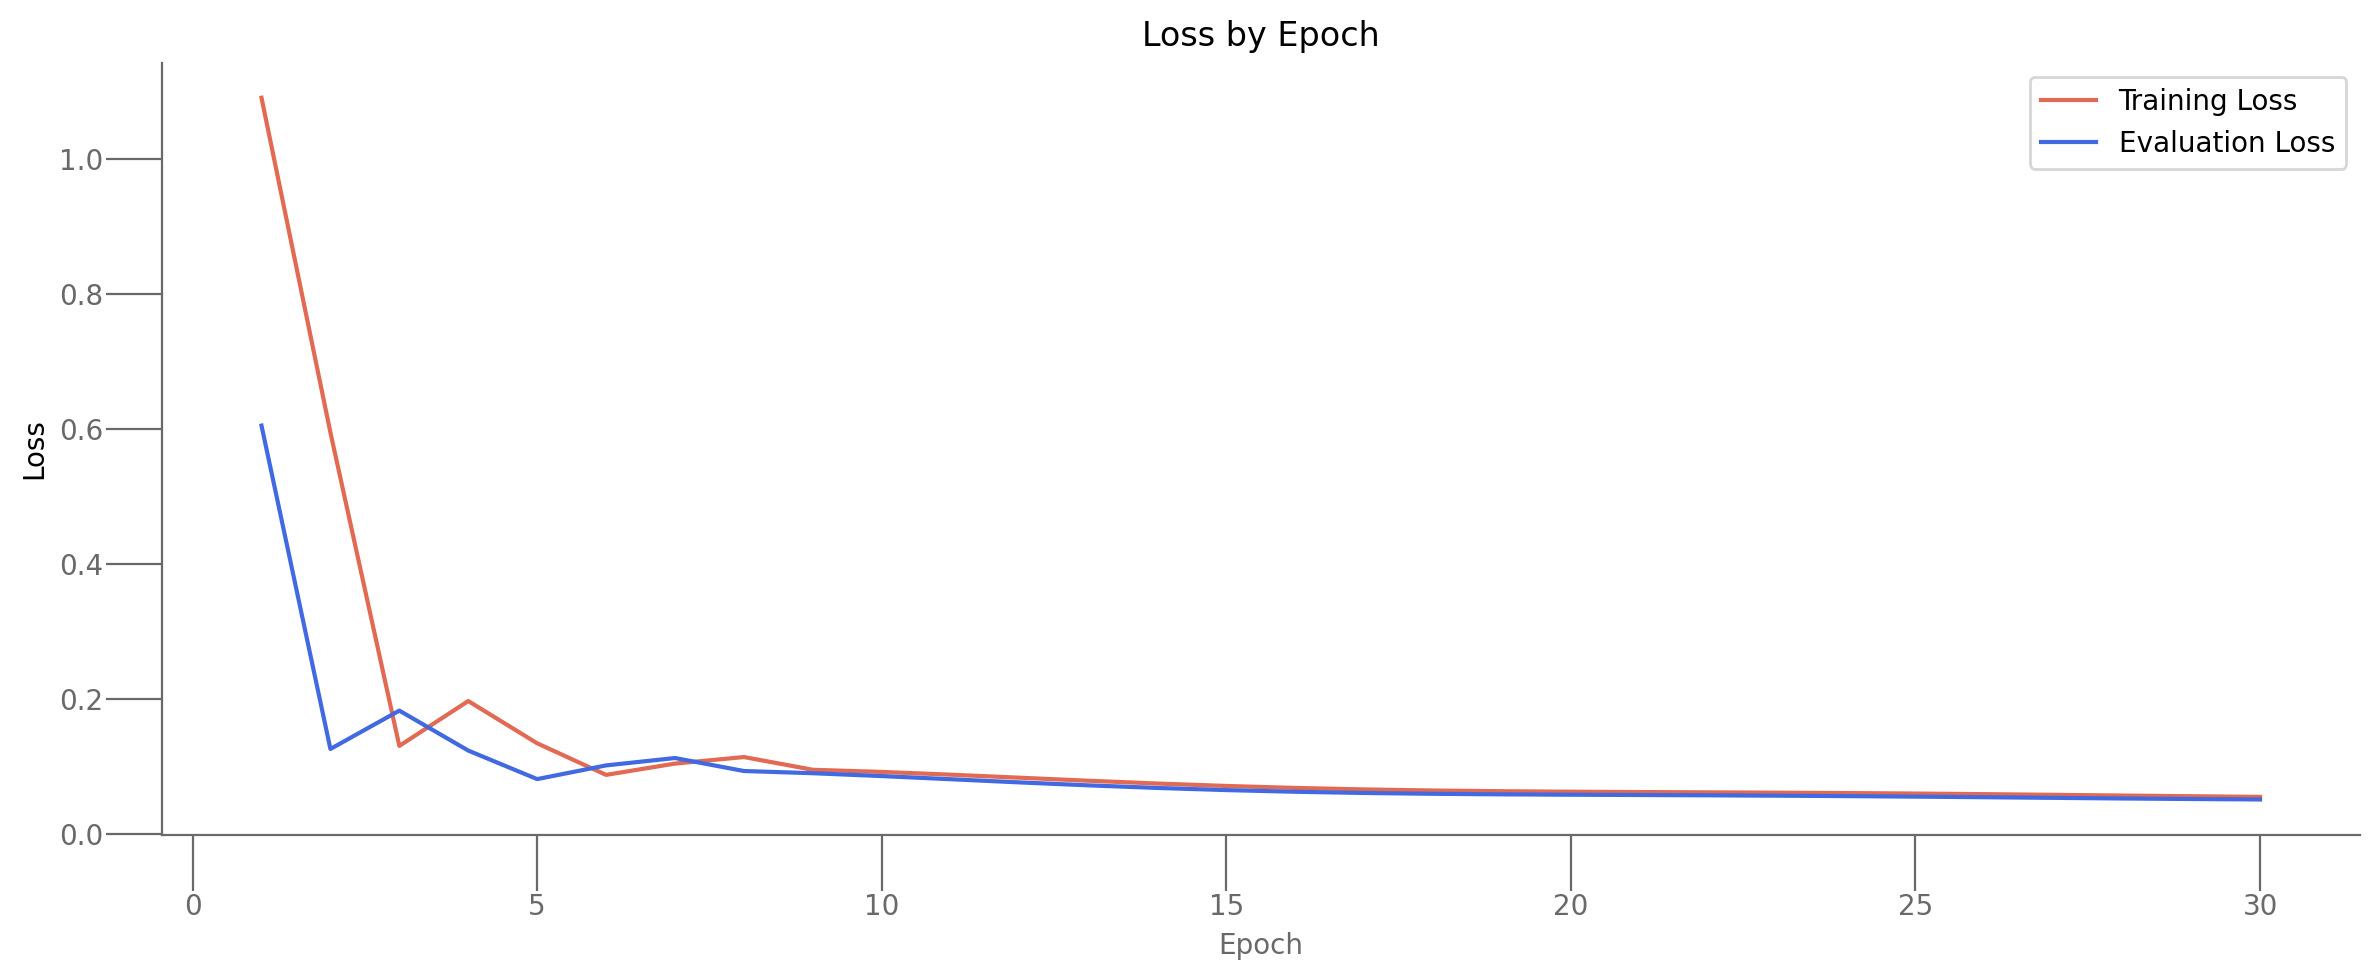


==================== TEST INFO ===================

Test_loss:0.0401, Test_r2:-14.1714


In [48]:



model = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, num_conv=1, num_lstm=1, aggr="add")

losses,eval_losses, r2scores, h = train(model, dataloader_gt, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions, real = test(model, dataloader_gt, h)


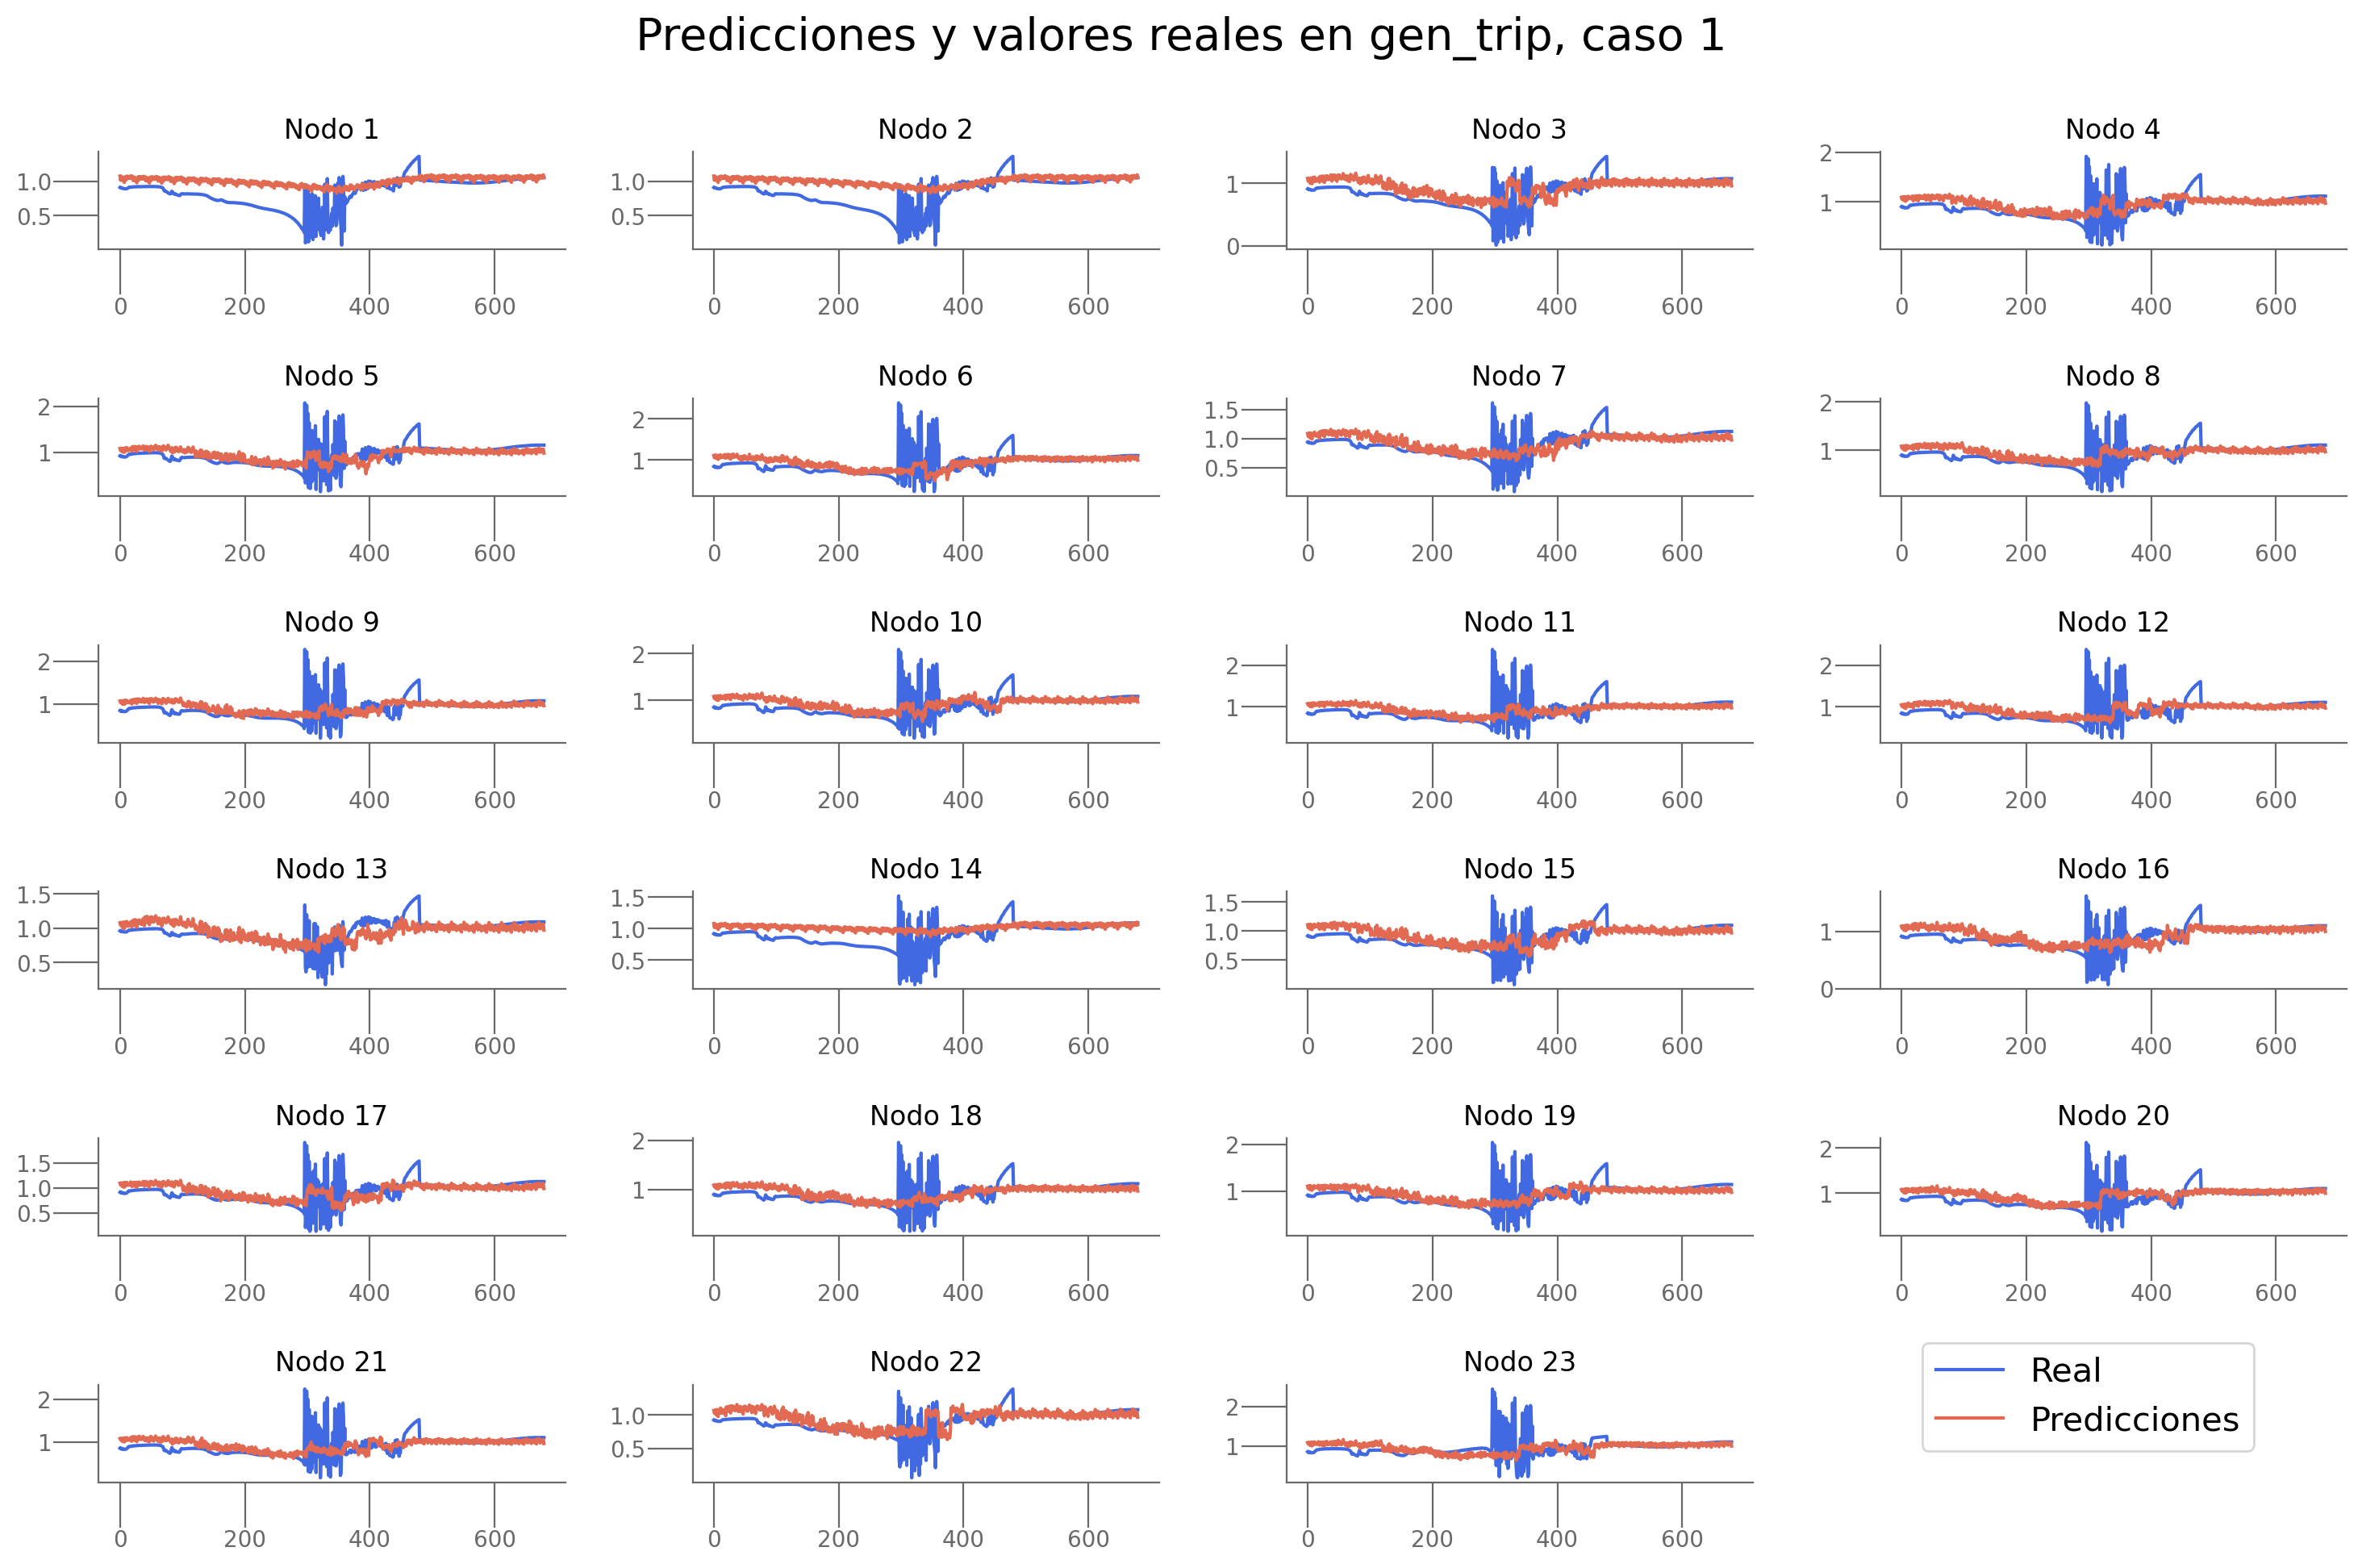

In [49]:
plot_predictions(predictions, real, n_target, 1, n_div_gt, problem_gt)

#### Ajuste de parámetros 

In [123]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

modelo_gt,params_gt, resultados_final_gt, resultados_gt, h = entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader_gt, num_early_stop, num_epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]


==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.2102 | Eval Loss: 0.6467 | Eval R2: -302.0855 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6367 | Eval Loss: 0.1649 | Eval R2: -62.0415 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1668 | Eval Loss: 0.1794 | Eval R2: -83.2962 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1920 | Eval Loss: 0.1347 | Eval R2: -59.1787 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1456 | Eval Loss: 0.0854 | Eval R2: -29.7565 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0930 | Eval Loss: 0.0802 | Eval R2: -24.5977 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0852 | Eval Loss: 0.0945 | Eval R2: -30.8067 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0974 | Eval Loss: 0.0985 | Eval R2: -32.7918 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.1005 | Eval Loss: 0.0873 | Eval R2: -27.5167 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0893 | Eval Loss: 0.0854 | Eval R2: -26.5856 | LR: 0.001000
Epoch 11/30 | Train Loss: 0.0874 | Eval Loss: 0.0828 | Eval R2: -25.3545 |

 12%|█▎        | 1/8 [19:39<2:17:38, 1179.74s/it]

Test_loss:0.0411, Test_r2:-14.4254
Parámetros:  add 1 1
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.0539621002972126, 'r2_eval_final': -12.565533488077008, 'loss_eval_final': 0.05035443146905852, 'r2_test': -14.425381882399714, 'loss_test': 0.0411445792982426, 'loss_nodes': [0.05015013366937637, 0.0494048036634922, 0.03975518420338631, 0.04450570419430733, 0.050516411662101746, 0.04772716760635376, 0.03936566039919853, 0.04340211674571037, 0.04619242995977402, 0.04101666063070297, 0.04729728773236275, 0.041783273220062256, 0.025252006947994232, 0.04168449714779854, 0.035393524914979935, 0.03394622728228569, 0.04136982560157776, 0.04120299965143204, 0.048429351300001144, 0.0416962094604969, 0.04102526232600212, 0.029158717021346092, 0.02604999952018261]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1332 | Eval Loss: 0.7780 | Eval R2: -374.5797 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7684 | Eval Loss: 0.2507 | Eval R2: -105.435

 25%|██▌       | 2/8 [39:05<1:57:10, 1171.70s/it]

Parámetros:  add 1 2
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.08843062818050385, 'r2_eval_final': -20.790859881862062, 'loss_eval_final': 0.0807814595111776, 'r2_test': -23.692536960124624, 'loss_test': 0.06660197608246055, 'loss_nodes': [0.07851915806531906, 0.07731927931308746, 0.0728904977440834, 0.07193688303232193, 0.07757087051868439, 0.07542542368173599, 0.06556341797113419, 0.07280200719833374, 0.07619976997375488, 0.06975553184747696, 0.07440061122179031, 0.06749420613050461, 0.04350747913122177, 0.05656387656927109, 0.058367740362882614, 0.058765657246112823, 0.06828971952199936, 0.06721396744251251, 0.07406868785619736, 0.06761825829744339, 0.06713517010211945, 0.049998294562101364, 0.04043906554579735]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1809 | Eval Loss: 0.8607 | Eval R2: -412.2791 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.8435 | Eval Loss: 0.2195 | Eval R2: -86.0789 | LR: 0.010000
Epoch 3/30 | Train L

 38%|███▊      | 3/8 [1:06:56<1:56:37, 1399.52s/it]

Parámetros:  add 2 1
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.05049031972885132, 'r2_eval_final': -12.965572538628463, 'loss_eval_final': 0.04835524222042452, 'r2_test': -14.380696104099458, 'loss_test': 0.039184571528558136, 'loss_nodes': [0.048663027584552765, 0.047917261719703674, 0.03858101740479469, 0.04210236668586731, 0.04628278315067291, 0.04477003589272499, 0.03736962750554085, 0.0410178042948246, 0.042893145233392715, 0.0371713787317276, 0.04342798516154289, 0.039288997650146484, 0.024530382826924324, 0.04095984995365143, 0.034931693226099014, 0.03365672007203102, 0.040664102882146835, 0.03802157938480377, 0.04755733907222748, 0.0389740951359272, 0.03839205950498581, 0.028804151341319084, 0.02526778355240822]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1315 | Eval Loss: 0.8983 | Eval R2: -436.9440 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.8818 | Eval Loss: 0.2145 | Eval R2: -85.2423 | LR: 0.010000
Epoch 3/30 | Tr

 50%|█████     | 4/8 [1:44:27<1:55:42, 1735.71s/it]

Parámetros:  add 2 2
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.08510350435972214, 'r2_eval_final': -19.91750722471289, 'loss_eval_final': 0.077886325772351, 'r2_test': -22.705869084976094, 'loss_test': 0.0642347290025403, 'loss_nodes': [0.076063372194767, 0.07495023310184479, 0.06983984261751175, 0.06925766915082932, 0.07501386851072311, 0.07263866811990738, 0.06300217658281326, 0.0698910504579544, 0.07328895479440689, 0.06671476364135742, 0.07186471670866013, 0.06510602682828903, 0.04137919098138809, 0.05566111579537392, 0.057047586888074875, 0.056083232164382935, 0.06590338796377182, 0.06452163308858871, 0.07205910235643387, 0.06497886031866074, 0.06463415175676346, 0.048729028552770615, 0.0387704037129879]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1293 | Eval Loss: 0.5422 | Eval R2: -249.2195 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5331 | Eval Loss: 0.1549 | Eval R2: -64.0027 | LR: 0.010000
Epoch 3/30 | Train Loss: 0

 62%|██████▎   | 5/8 [2:09:51<1:22:58, 1659.35s/it]

Parámetros:  mean 1 1
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.019128665328025818, 'r2_eval_final': -5.467112829019486, 'loss_eval_final': 0.02004136393980814, 'r2_test': -5.912705694187206, 'loss_test': 0.015451253532625303, 'loss_nodes': [0.00934156309813261, 0.00910430122166872, 0.014003883115947247, 0.016773872077465057, 0.019649717956781387, 0.02021816000342369, 0.01427291240543127, 0.016086062416434288, 0.018618281930685043, 0.01499076746404171, 0.0202287919819355, 0.01685796119272709, 0.011577649973332882, 0.010279414243996143, 0.014251057989895344, 0.012811379507184029, 0.01612415350973606, 0.016769155859947205, 0.017700070515275, 0.017150437459349632, 0.018324177712202072, 0.012072098441421986, 0.018172945827245712]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0858 | Eval Loss: 0.8148 | Eval R2: -394.2860 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.8021 | Eval Loss: 0.1807 | Eval R2: -69.9328 | LR: 0.010000
Epoch 3/

 75%|███████▌  | 6/8 [2:33:55<52:51, 1585.99s/it]  

Parámetros:  mean 1 2
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.08545555174350739, 'r2_eval_final': -20.17976433594464, 'loss_eval_final': 0.07805210048450477, 'r2_test': -22.714422075311795, 'loss_test': 0.06358931186206583, 'loss_nodes': [0.07773102074861526, 0.07662339508533478, 0.06896715611219406, 0.06835382431745529, 0.07369521260261536, 0.07187999784946442, 0.06214692443609238, 0.06881897896528244, 0.072050079703331, 0.06574420630931854, 0.07077301293611526, 0.06408809125423431, 0.04129756614565849, 0.05605349689722061, 0.05527044087648392, 0.05576815828680992, 0.06502354890108109, 0.06384188681840897, 0.07070682942867279, 0.06432940810918808, 0.0637398436665535, 0.047092076390981674, 0.038559019565582275]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1097 | Eval Loss: 0.6763 | Eval R2: -320.0207 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6654 | Eval Loss: 0.1650 | Eval R2: -63.2946 | LR: 0.010000
Epoch 3/30 | Train Lo

 88%|████████▊ | 7/8 [3:00:55<26:37, 1597.41s/it]

Parámetros:  mean 2 1
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.018802180886268616, 'r2_eval_final': -4.8184760020928845, 'loss_eval_final': 0.01959977457049473, 'r2_test': -5.223568519212215, 'loss_test': 0.014867042047599421, 'loss_nodes': [0.01353246159851551, 0.01328863762319088, 0.011167298071086407, 0.015856606885790825, 0.016447074711322784, 0.01713106967508793, 0.013905494473874569, 0.014364663511514664, 0.018284479156136513, 0.014586995355784893, 0.018365897238254547, 0.016864050179719925, 0.01110188290476799, 0.01381038036197424, 0.014293516054749489, 0.010518956929445267, 0.01487988792359829, 0.015374508686363697, 0.017717508599162102, 0.015830688178539276, 0.0154778603464365, 0.011660643853247166, 0.017481409013271332]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1525 | Eval Loss: 1.0245 | Eval R2: -502.2559 | LR: 0.010000
Epoch 2/30 | Train Loss: 1.0091 | Eval Loss: 0.3368 | Eval R2: -143.0301 | LR: 0.010000
Ep

100%|██████████| 8/8 [3:31:09<00:00, 1583.66s/it]

Test_loss:0.0621, Test_r2:-21.4391
Parámetros:  mean 2 2
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.08285495638847351, 'r2_eval_final': -19.079825550938725, 'loss_eval_final': 0.07566728203542411, 'r2_test': -21.439080111772117, 'loss_test': 0.062094506409193236, 'loss_nodes': [0.07422036677598953, 0.0730937123298645, 0.06523191183805466, 0.06670209020376205, 0.07366970181465149, 0.07130017131567001, 0.06041384115815163, 0.06755255907773972, 0.07051049917936325, 0.06432051956653595, 0.07004167139530182, 0.062100719660520554, 0.03988320380449295, 0.05488669499754906, 0.05385981872677803, 0.05409855768084526, 0.0641956627368927, 0.06275752186775208, 0.0704023614525795, 0.0634378120303154, 0.0627155676484108, 0.0453416146337986, 0.03743717074394226]}


In [130]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)

In [131]:
guardar_resultados(modelo_gt, "DryGrEncoder", problem_gt, resultados_final_gt, results_save_path, path_save_experiment_gt, params_gt)


==================== GUARDANDO RESULTADOS ===================

         Modelo        Params  \
0          LSTM           NaN   
1          LSTM           NaN   
2  DryGrEncoder  (mean, 2, 1)   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.007442  0.358250   
1                                                NaN  0.007442  0.358250   
2  ./results/gen_trip/ajustes/DryGrEncoder_result...  0.014867 -5.223569   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.00292401 0.00315184 0.00446385 0.0074707  0... -8.137170   0.086898   
1  [0.00292401 0.00315184 0.00446385 0.0074707  0... -8.137170   0.086898   
2  [0.01353246159851551, 0.01328863762319088, 0.0... -4.818476   0.019600   

   Loss_final  
0    0.007102  
1    0.007102  
2    0.018802  

==================== RESULTADOS GUARDADOS ===================



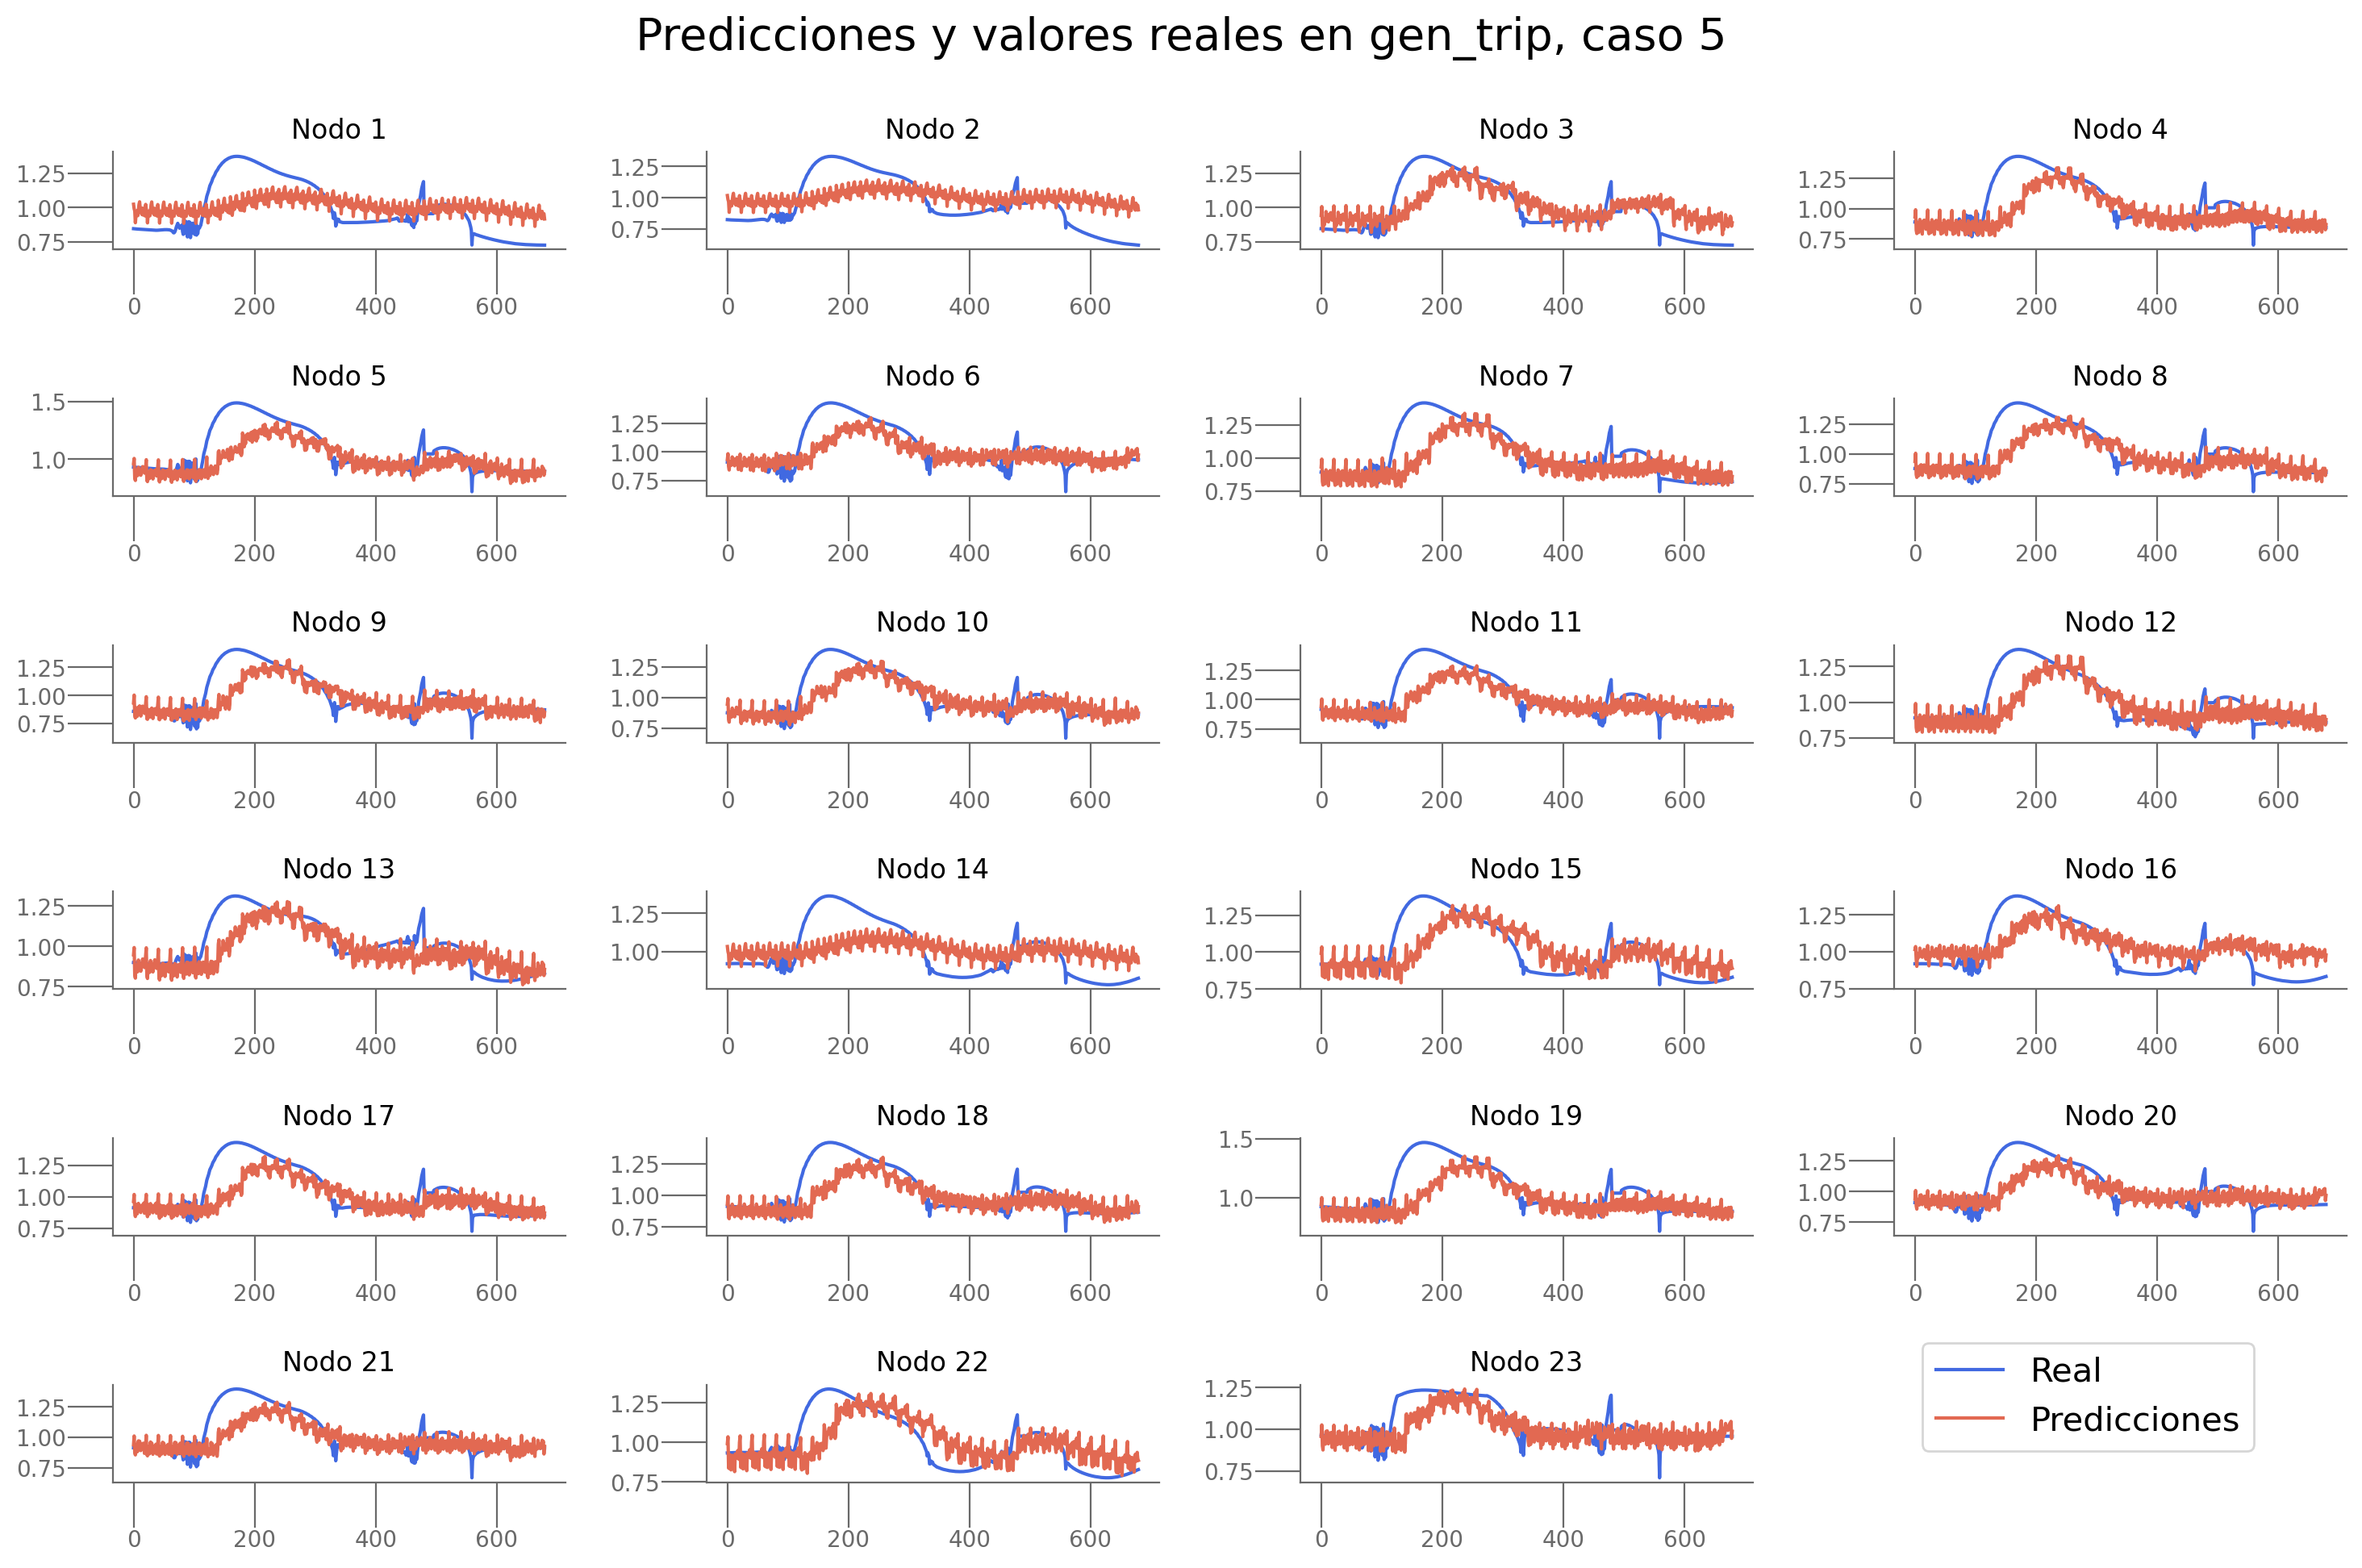

In [139]:
plot_predictions(predictions, real, n_target, 5, n_div_gt, problem_gt)

#### Carga de modelo

In [52]:
dataloader_gt_2 = trainer.train_test_val_split(dataset_gt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=True)


==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 870
DataLoader for val set:
Number of batches: 186
DataLoader for test set:
Number of batches: 188


In [64]:
import utils.utils_graph
utils.utils_graph = reload(utils.utils_graph)

In [65]:
from utils.train_lstm import LSTMModel, test_lstm
from utils.utils_graph import plot_multiple_models

In [43]:
path_results_gt = results_save_path+f"/{problem_gt}"+ "/results.csv"
results_gt = pd.read_csv(path_results_gt)
params_dry = results_gt[results_gt["Modelo"]=="DryGrEncoder"].iloc[-1]["Params"].replace("(","").replace(")","").replace("'","").split(", ")


['mean', '2', '1']

In [55]:
path_model1 = results_save_path+f"/{problem_gt}"+ f"/{name_model}.pt" 
path_model2 = results_save_path+f"/{problem_gt}"+ f"/LSTM.pt"
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


model1 = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, num_conv=int(params_dry[1]), num_lstm=int(params_dry[2]), aggr=params_dry[0])
model1.load_state_dict(torch.load(path_model1))
model1.to(device)

model2 = utils.train_lstm.LSTMModel(name="LSTM", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=50, num_layers=2)
model2.load_state_dict(torch.load(path_model2))
model2.to(device)

LSTMModel(
  (lstm): LSTM(100, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=20, bias=True)
)

In [57]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

losses_tst, r2score_tst, _, predictions1, real1 = test(model1, dataloader_gt, model1.h)


losses_tst, r2score_tst, _, predictions2, real2 = utils.train_lstm.test_lstm(model2, dataloader_gt_2)



==================== TEST INFO ===================

Test_loss:0.0149, Test_r2:-5.2236

==================== TEST INFO ===================

Test_loss:0.0074, Test_r2:0.3582


In [66]:
plot_multiple_models([predictions1, predictions2], real1, n_target, 5, n_div_gt, problem_gt, ["DryGrEncoder", "LSTM"])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

### Bus trip

In [13]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [27]:
n_div_bt = loader.div

In [19]:
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]
embedding_dim =5


dataloader_bt = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430


#### Sencilla 


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1089 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5601 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8616 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0742 | Eval Loss: 0.0858 | Eval R2: -1.1448 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0872 | Eval Loss: 0.0867 | Eval R2: -1.1407 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0678 | Eval R2: -0.5723 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0695 | Eval Loss: 0.0509 | Eval R2: -0.1620 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0527 | Eval Loss: 0.0490 

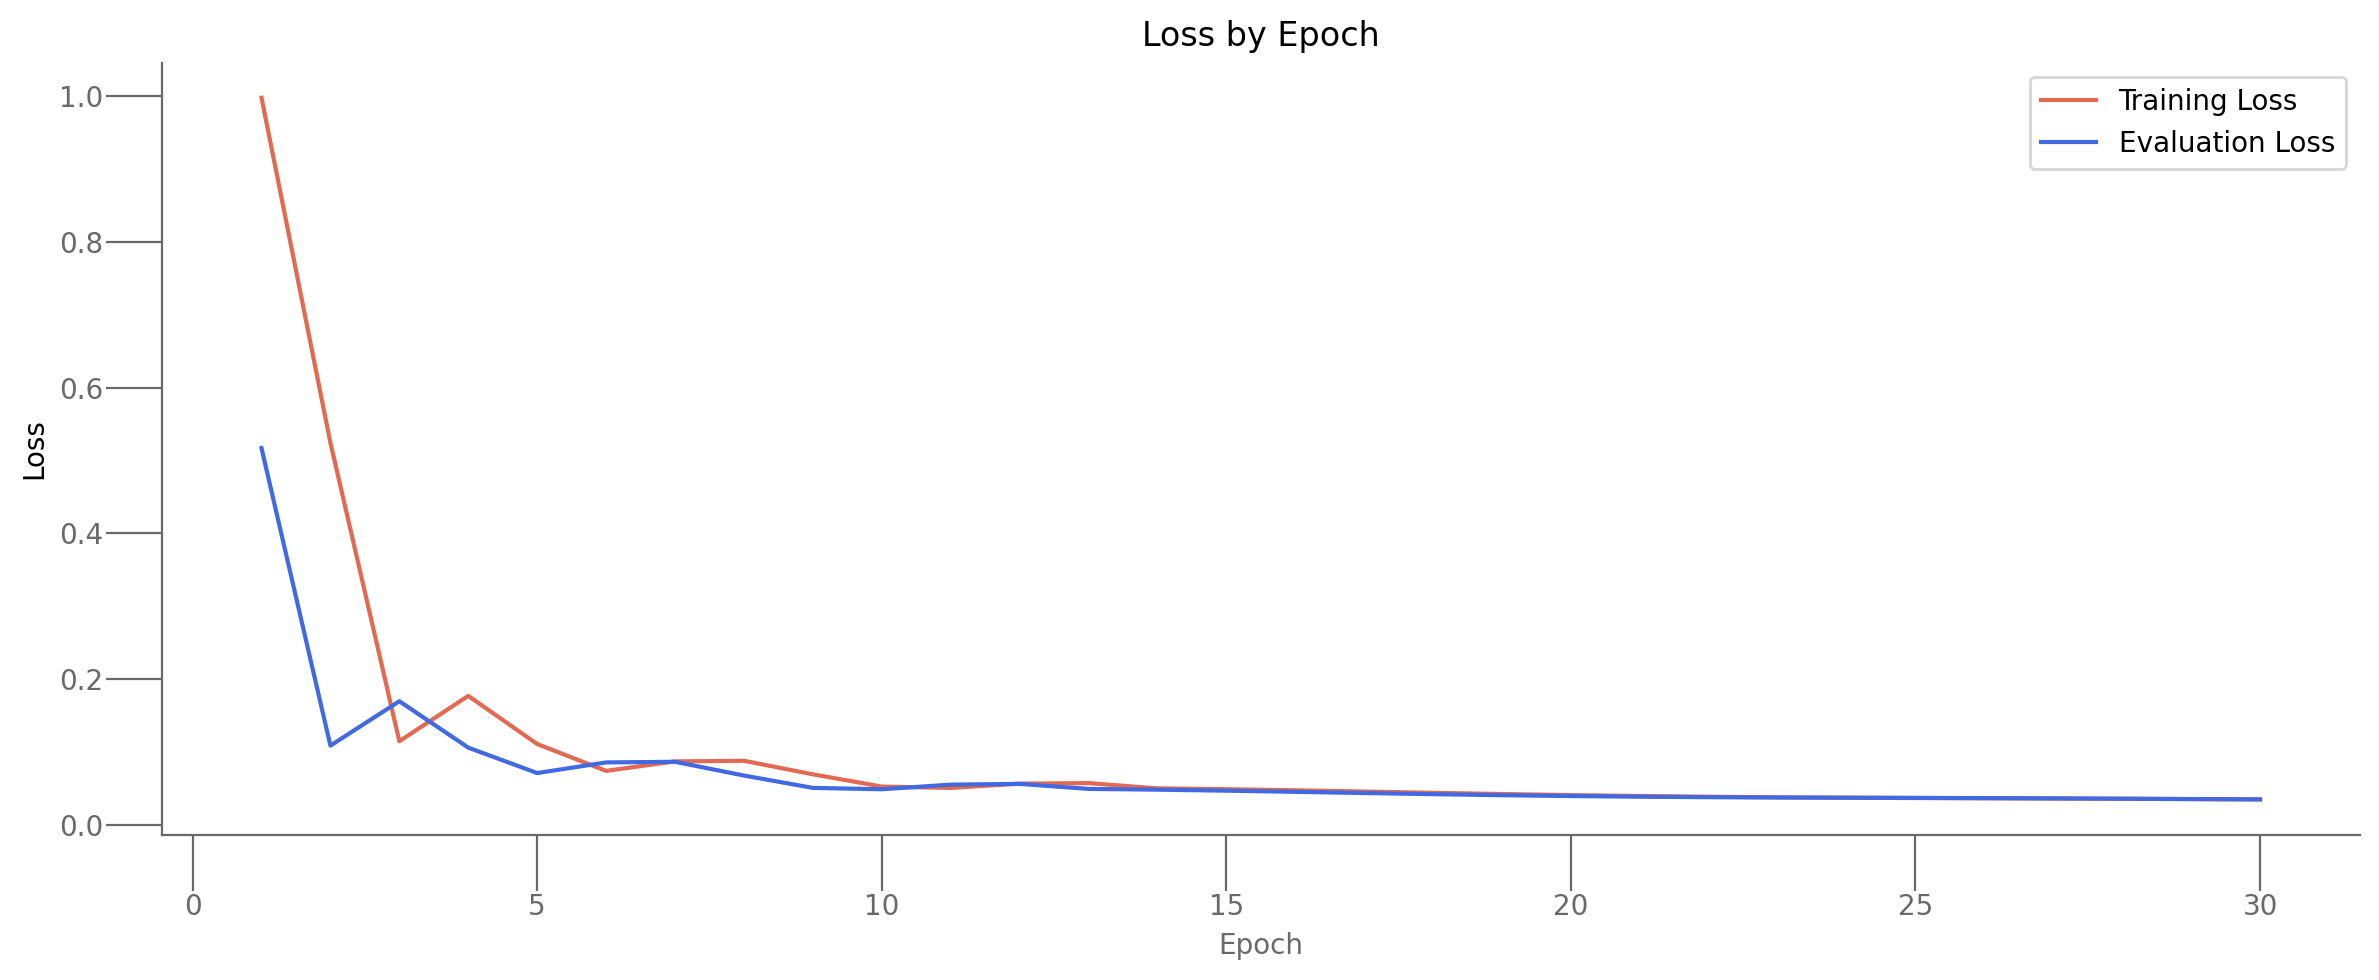


==================== TEST INFO ===================

Test_loss:0.0375, Test_r2:0.1548


In [53]:

model_bt = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")


num_early_stop = 0
num_epochs = 30
lr = 0.01


losses,eval_losses, r2scores, h = train(model_bt, dataloader_bt, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bt, real_bt = test(model_bt, dataloader_bt, h)


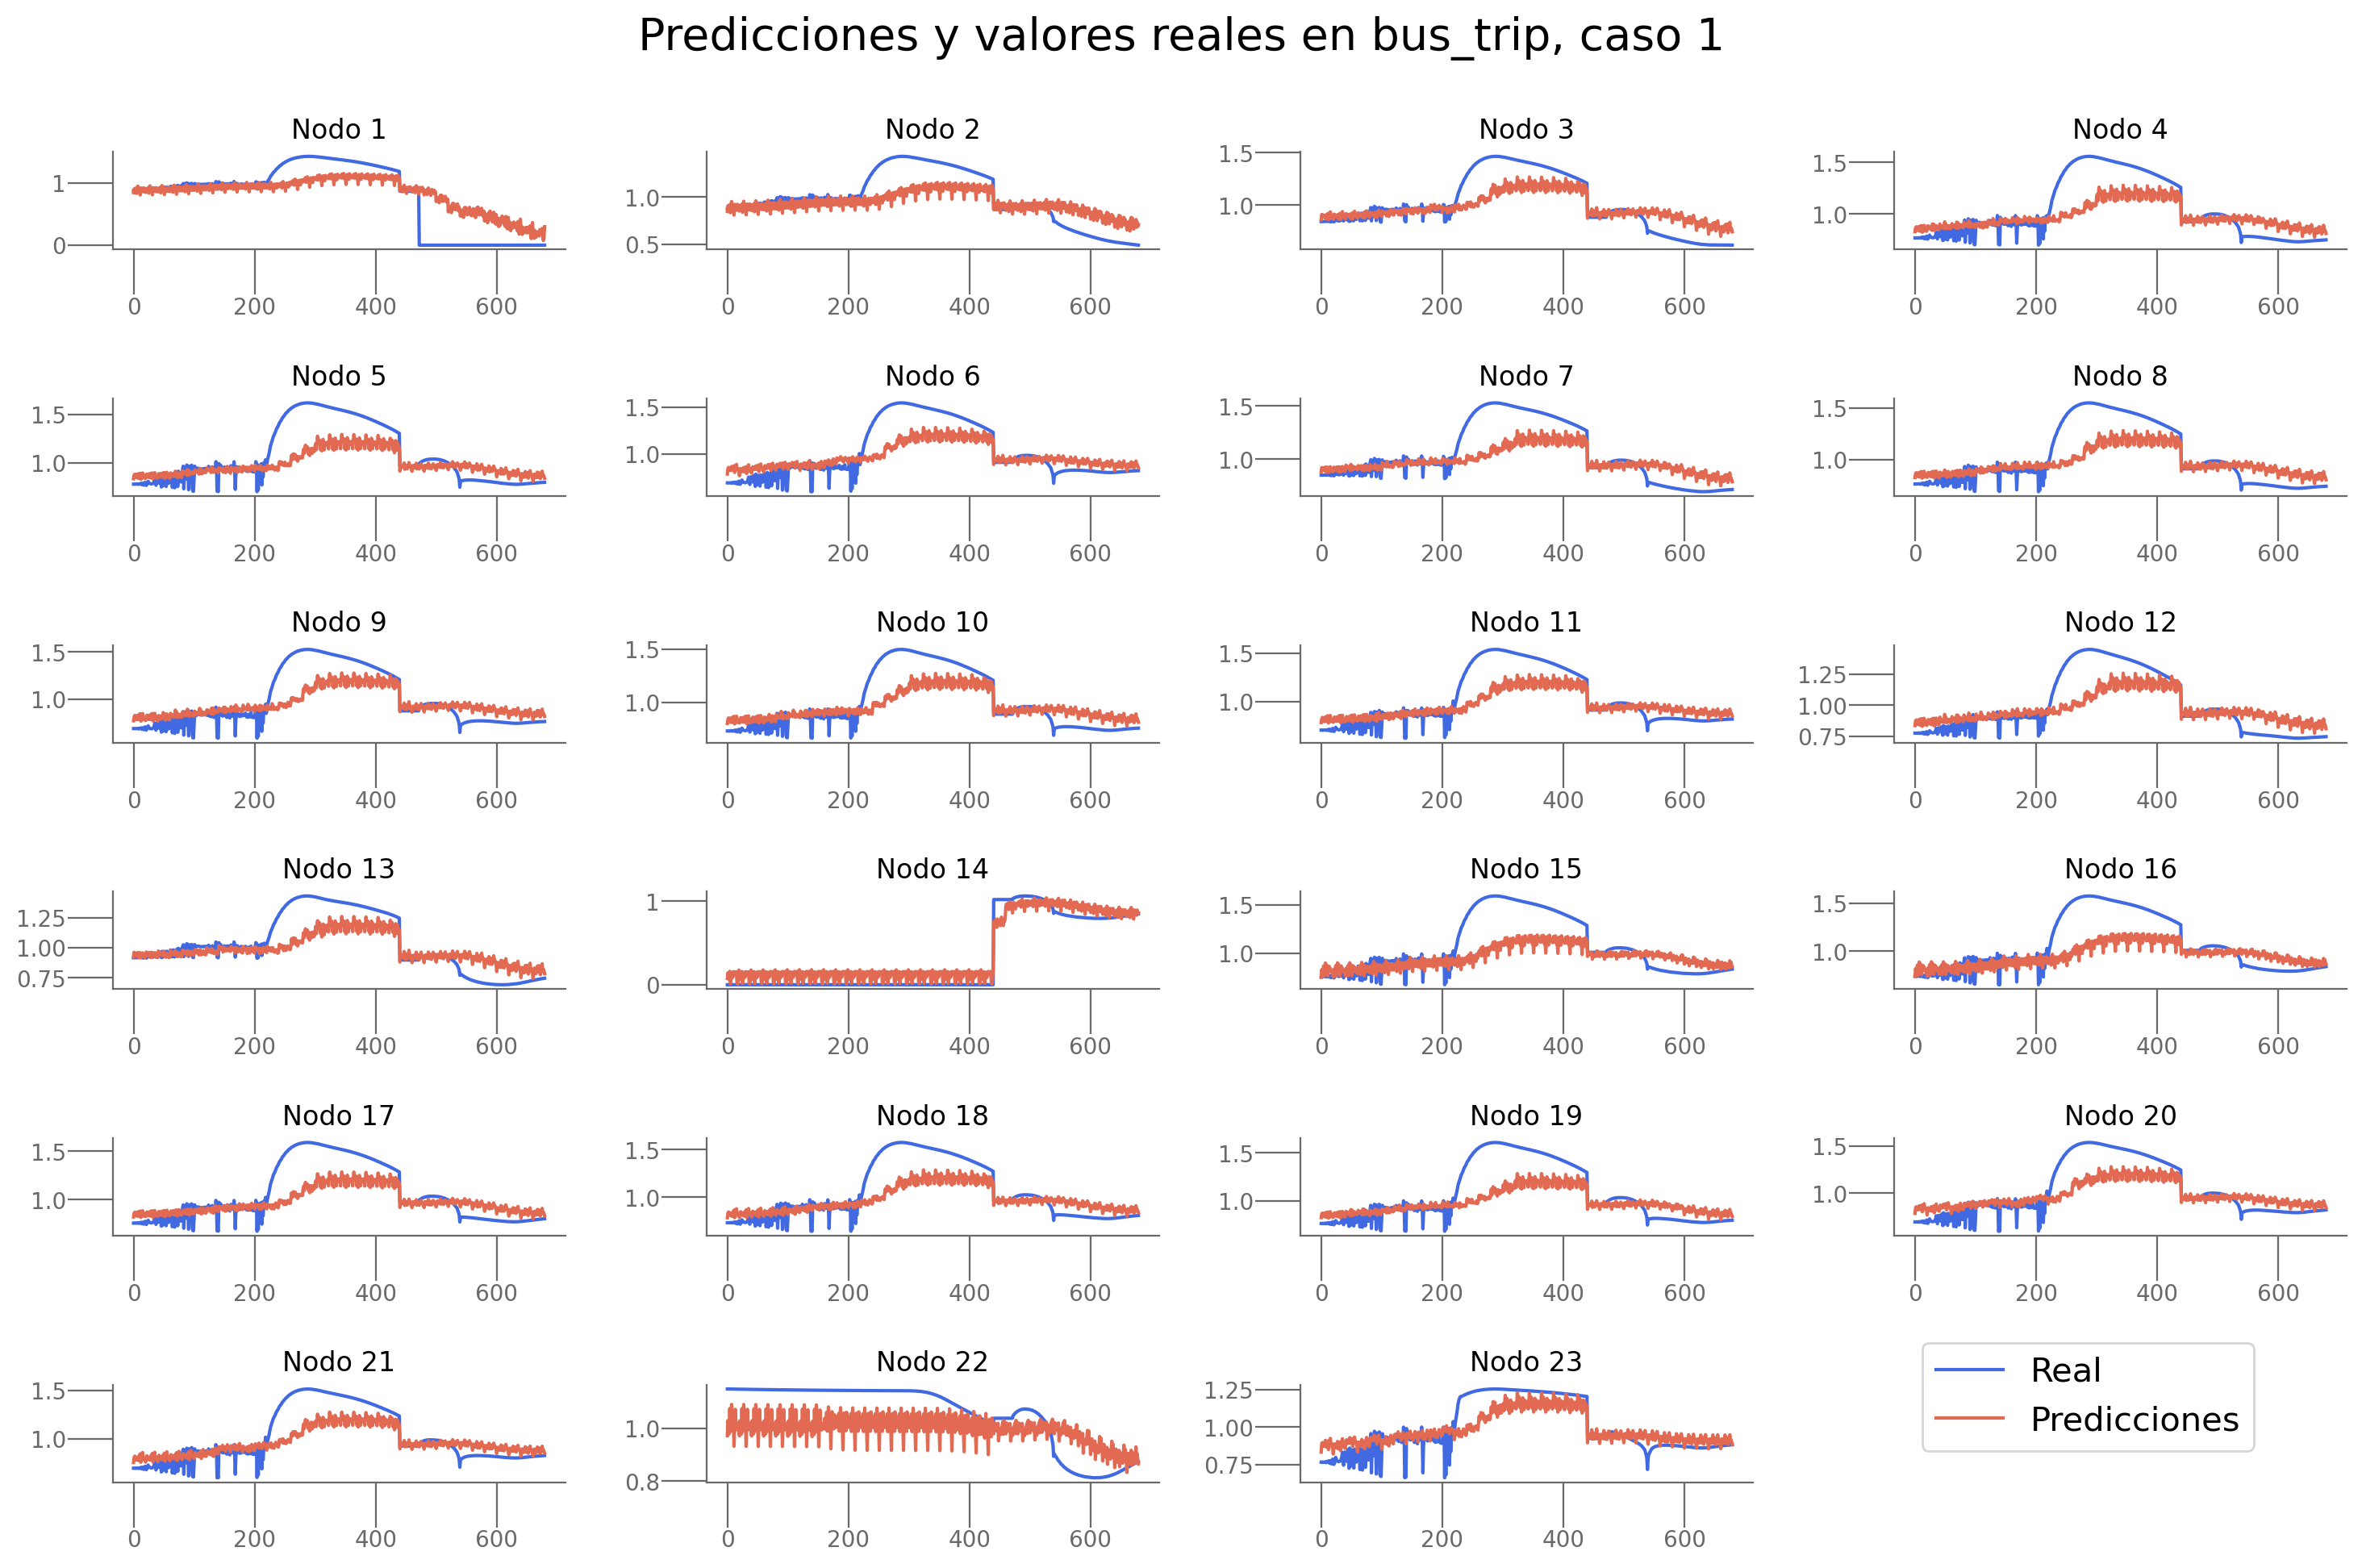

In [54]:
plot_predictions(predictions_bt, real_bt, n_target, 1, n_div_bt, problem_bt)

#### Ajuste de parámetros 

In [23]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

modelo_bt,params_bt,resultados_final_bt, resultados_bt, h = entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader_bt, num_early_stop, num_epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]


==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0742 | Eval Loss: 0.3988 | Eval R2: -12.1772 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.4033 | Eval Loss: 0.1891 | Eval R2: -5.6730 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1935 | Eval Loss: 0.1539 | Eval R2: -4.5235 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1603 | Eval Loss: 0.0819 | Eval R2: -1.5523 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0871 | Eval Loss: 0.0800 | Eval R2: -1.0695 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0836 | Eval Loss: 0.0996 | Eval R2: -1.5891 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.1020 | Eval Loss: 0.0953 | Eval R2: -1.4292 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0970 | Eval Loss: 0.0748 | Eval R2: -0.8094 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0766 | Eval Loss: 0.0591 | Eval R2: -0.4777 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0608 | Eval Loss: 0.0563 | Eval R2: -0.6215 | LR: 0.010000
Epoch 11/30 | Train Loss: 0.0578 | Eval Loss: 0.0575 | Eval R2: -0.8117 | LR: 0.0100

 12%|█▎        | 1/8 [06:25<44:56, 385.17s/it]

Test_loss:0.0312, Test_r2:0.1890
Parámetros:  add 1 1
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.030043017119169235, 'r2_eval_final': 0.24925290314062662, 'loss_eval_final': 0.029540809904139532, 'r2_test': 0.18898968576568162, 'loss_test': 0.031198040577095694, 'loss_nodes': [0.030855895951390266, 0.03306085243821144, 0.02559652552008629, 0.03495469316840172, 0.03809471055865288, 0.03804665058851242, 0.028537843376398087, 0.04011991620063782, 0.040717653930187225, 0.03233088552951813, 0.03654977306723595, 0.026790250092744827, 0.01657184585928917, 0.02628682553768158, 0.02802109532058239, 0.024961229413747787, 0.036641739308834076, 0.031753454357385635, 0.03893491253256798, 0.033020421862602234, 0.033652156591415405, 0.01726628839969635, 0.02478930726647377]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0235 | Eval Loss: 0.5431 | Eval R2: -16.8607 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5496 | Eval Loss: 0.1242 | Eval R2: -

 25%|██▌       | 2/8 [13:19<40:13, 402.28s/it]

Test_loss:0.0890, Test_r2:-1.2264
Parámetros:  add 1 2
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.0895724669098854, 'r2_eval_final': -0.9263420073755723, 'loss_eval_final': 0.08324228962321348, 'r2_test': -1.226390276861722, 'loss_test': 0.08897531923599715, 'loss_nodes': [0.17812494933605194, 0.06370517611503601, 0.056935884058475494, 0.12383344024419785, 0.07019504904747009, 0.07135120034217834, 0.05591868609189987, 0.12813523411750793, 0.0769125372171402, 0.11897437274456024, 0.06870836764574051, 0.05193328857421875, 0.0348014272749424, 0.11144769936800003, 0.10326167941093445, 0.046962130814790726, 0.16693954169750214, 0.05959136039018631, 0.1274961233139038, 0.1402186155319214, 0.06334982067346573, 0.03081992082297802, 0.09681626409292221]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0469 | Eval Loss: 0.6350 | Eval R2: -19.8758 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6570 | Eval Loss: 0.1287 | Eval R2: -2.5105 | LR: 0.

 38%|███▊      | 3/8 [22:55<40:07, 481.57s/it]

Parámetros:  add 2 1
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.027592333033680916, 'r2_eval_final': 0.3119048545175961, 'loss_eval_final': 0.027613044599199603, 'r2_test': 0.28558664034658465, 'loss_test': 0.029372386800580075, 'loss_nodes': [0.033924609422683716, 0.033185701817274094, 0.02014904096722603, 0.03367293253540993, 0.03574095293879509, 0.03396439179778099, 0.02693840116262436, 0.037239786237478256, 0.03693782165646553, 0.02939426526427269, 0.032948512583971024, 0.02447226271033287, 0.016124356538057327, 0.030437316745519638, 0.028319697827100754, 0.02226118929684162, 0.034304678440093994, 0.028066596016287804, 0.038563746958971024, 0.030658701434731483, 0.02889997325837612, 0.01697005145251751, 0.022389959543943405]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0205 | Eval Loss: 0.7332 | Eval R2: -23.8889 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7299 | Eval Loss: 0.1605 | Eval R2: -3.4076 | LR: 0.010000
Epoch 3/3

 50%|█████     | 4/8 [32:53<35:11, 527.79s/it]

Parámetros:  add 2 2
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.020831579342484474, 'r2_eval_final': 0.28734080589259403, 'loss_eval_final': 0.019951658336253, 'r2_test': 0.3274864394887766, 'loss_test': 0.021473132615345857, 'loss_nodes': [0.022424345836043358, 0.0250595360994339, 0.015039521269500256, 0.024278968572616577, 0.025002850219607353, 0.027513286098837852, 0.0186904389411211, 0.02651253342628479, 0.026251692324876785, 0.021154988557100296, 0.022297270596027374, 0.0172655638307333, 0.010524756275117397, 0.021686429157853127, 0.0191186536103487, 0.01501468289643526, 0.027600238099694252, 0.01907418668270111, 0.02715448848903179, 0.026190944015979767, 0.022885063663125038, 0.012121650390326977, 0.02101994678378105]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0633 | Eval Loss: 0.5975 | Eval R2: -19.2646 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5959 | Eval Loss: 0.1377 | Eval R2: -3.7188 | LR: 0.010000
Epoch 3/30 | T

 62%|██████▎   | 5/8 [40:24<25:00, 500.09s/it]

Parámetros:  mean 1 1
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.015585387125611305, 'r2_eval_final': 0.599226981030637, 'loss_eval_final': 0.015161787028874045, 'r2_test': 0.5561501007391957, 'loss_test': 0.0162671503497201, 'loss_nodes': [0.012346855364739895, 0.013770419172942638, 0.012597077526152134, 0.01988494209945202, 0.017955200746655464, 0.020045896992087364, 0.015779150649905205, 0.02117941342294216, 0.02230188064277172, 0.016246333718299866, 0.019948158413171768, 0.015271022915840149, 0.008626526221632957, 0.012197485193610191, 0.015216076746582985, 0.011485553346574306, 0.021111998707056046, 0.01633497141301632, 0.021324913948774338, 0.017438845708966255, 0.017729762941598892, 0.009809259325265884, 0.015542750246822834]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0357 | Eval Loss: 0.7963 | Eval R2: -26.2660 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7995 | Eval Loss: 0.2221 | Eval R2: -5.6120 | LR: 0.010000
Epoc

 75%|███████▌  | 6/8 [47:37<15:54, 477.01s/it]

Test_loss:0.0576, Test_r2:-0.5438
Parámetros:  mean 1 2
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.05503934249281883, 'r2_eval_final': -0.4834560570156455, 'loss_eval_final': 0.05461086552943392, 'r2_test': -0.5438029126837479, 'loss_test': 0.05758446275668089, 'loss_nodes': [0.11827492713928223, 0.0638536736369133, 0.04231627658009529, 0.062354881316423416, 0.06521650403738022, 0.06376441568136215, 0.04731913283467293, 0.06619566679000854, 0.06357239931821823, 0.05779717490077019, 0.06146525964140892, 0.04230993241071701, 0.02985161915421486, 0.07759169489145279, 0.0485256053507328, 0.043169159442186356, 0.0643051266670227, 0.052991658449172974, 0.06839706748723984, 0.05972197651863098, 0.05613178387284279, 0.029428012669086456, 0.039888784289360046]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0665 | Eval Loss: 0.6223 | Eval R2: -20.6222 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6347 | Eval Loss: 0.1350 | Eval R2: -3.2071 

 88%|████████▊ | 7/8 [57:05<08:26, 506.91s/it]

Test_loss:0.0190, Test_r2:0.4699
Parámetros:  mean 2 1
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.01697964407503605, 'r2_eval_final': 0.476675560512632, 'loss_eval_final': 0.01776549413896583, 'r2_test': 0.46989498337765484, 'loss_test': 0.018997652999526108, 'loss_nodes': [0.014366754330694675, 0.023010438308119774, 0.0140493493527174, 0.021920667961239815, 0.02051793783903122, 0.02482576295733452, 0.017722558230161667, 0.022478438913822174, 0.023536114022135735, 0.017134472727775574, 0.021269097924232483, 0.017553752288222313, 0.008946498855948448, 0.016260948032140732, 0.01831723004579544, 0.014831791631877422, 0.024600420147180557, 0.017601441591978073, 0.02439747378230095, 0.022702544927597046, 0.02026425674557686, 0.011264125816524029, 0.01937398500740528]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9920 | Eval Loss: 0.6586 | Eval R2: -20.9078 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6711 | Eval Loss: 0.1448 | Eval R

100%|██████████| 8/8 [1:07:29<00:00, 506.20s/it]

Test_loss:0.0859, Test_r2:-1.0359
Parámetros:  mean 2 2
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.087540403008461, 'r2_eval_final': -0.8367694129887238, 'loss_eval_final': 0.08408827620890291, 'r2_test': -1.0359084171268085, 'loss_test': 0.08594639765445229, 'loss_nodes': [0.16147467494010925, 0.05963809788227081, 0.05210496857762337, 0.12116412073373795, 0.0697273463010788, 0.06812240183353424, 0.05437587946653366, 0.12025832384824753, 0.06926310062408447, 0.1167270764708519, 0.06526710093021393, 0.04834779351949692, 0.035018693655729294, 0.10436880588531494, 0.10724905133247375, 0.04780445992946625, 0.16573011875152588, 0.05818170681595802, 0.124314084649086, 0.14377741515636444, 0.06005914509296417, 0.03331075608730316, 0.09048210084438324]}


In [24]:
losses_tst, r2score_tst, loss_nodes_bt, predictions_bt_ajuste, real_bt_ajuste = test(modelo_bt, dataloader_bt, modelo_bt.h)



==================== TEST INFO ===================

Test_loss:0.0163, Test_r2:0.5562


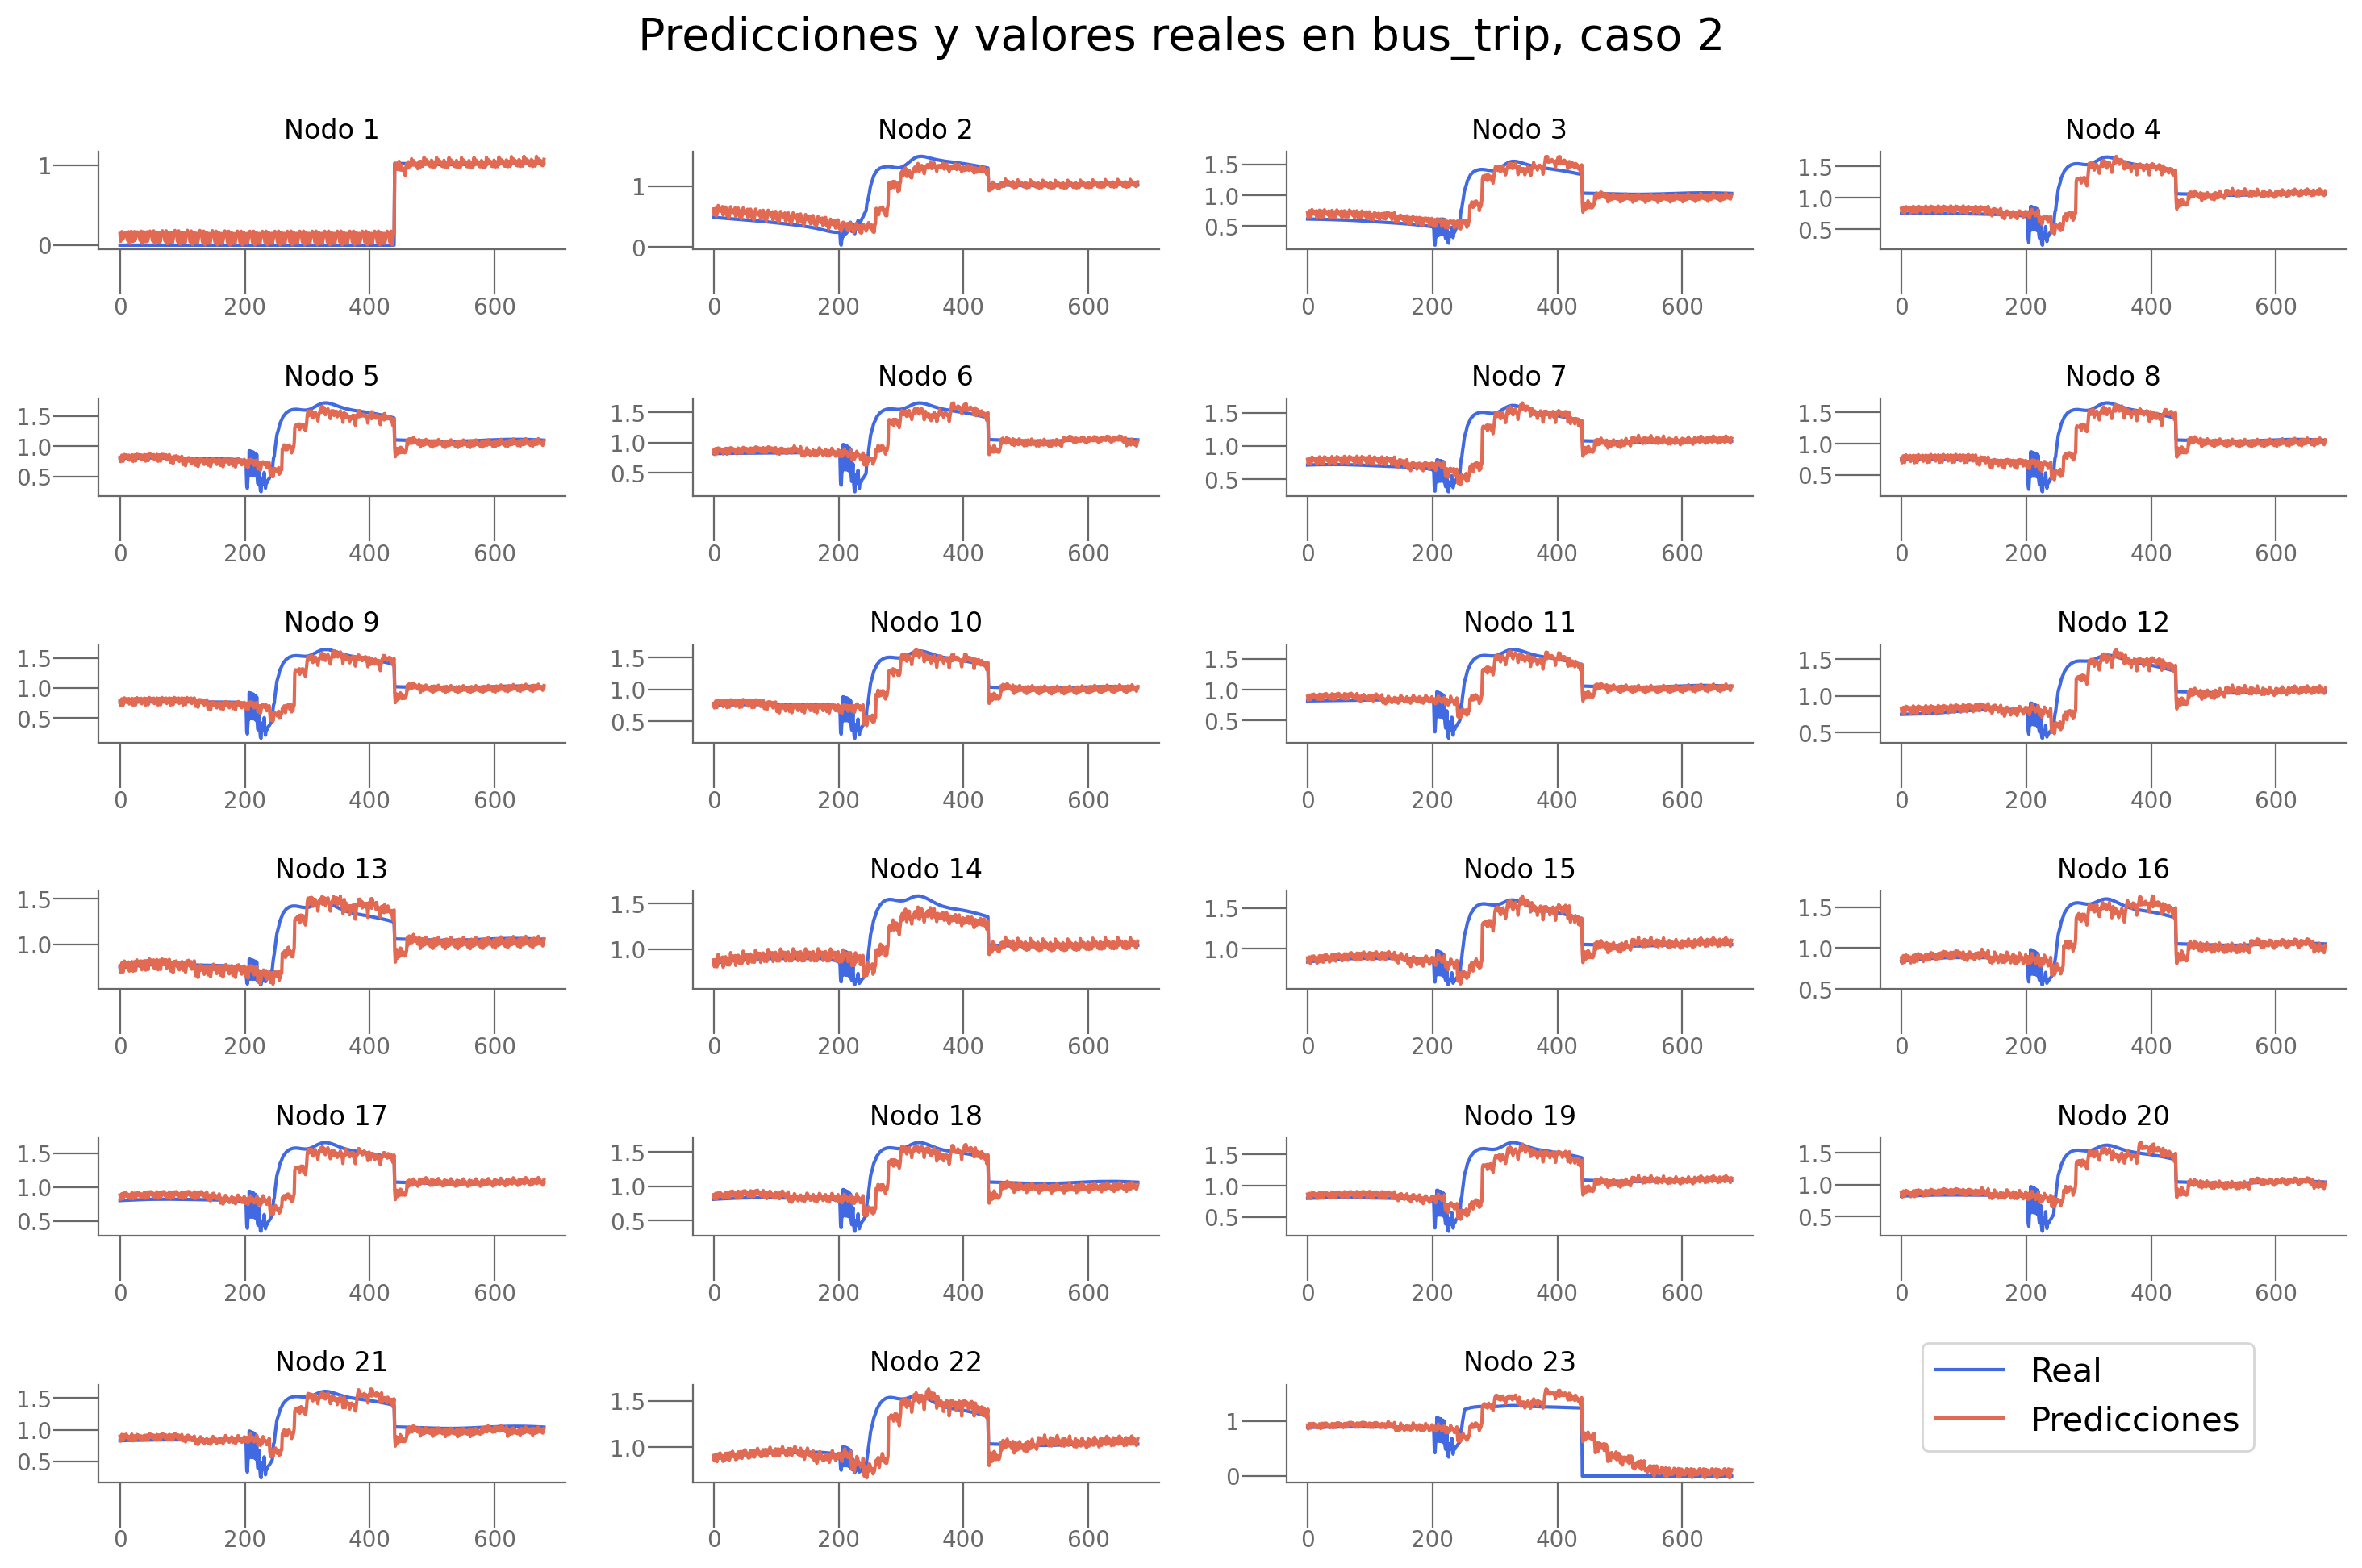

In [28]:
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 2, n_div_bt, problem_bt)

In [29]:
path_save_experiment_bt = results_save_path+f"/{problem_bt}"+ f"/ajustes/{name_model}_results.csv"
resultados_bt.to_csv(path_save_experiment_bt, index=False)

In [32]:
guardar_resultados(modelo_bt, "DryGrEncoder", problem_bt, resultados_final_bt, results_save_path, path_save_experiment_bt, params_bt)


==================== GUARDANDO RESULTADOS ===================

         Modelo        Params  \
0          LSTM           NaN   
1  DryGrEncoder  (mean, 1, 1)   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.005105  0.924924   
1  ./results/bus_trip/ajustes/DryGrEncoder_result...  0.016267  0.556150   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.00321016 0.00406848 0.00364592 0.00553952 0... -1.715052   0.163971   
1  [0.012346855364739895, 0.013770419172942638, 0...  0.599227   0.015162   

   Loss_final  
0    0.004536  
1    0.015585  

==================== RESULTADOS GUARDADOS ===================



### Bus fault

In [34]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [35]:
n_div_bf = loader.div

In [37]:
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
embedding_dim =5



dataloader_bf = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430


#### Sencilla 


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1089 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5601 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8616 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0742 | Eval Loss: 0.0858 | Eval R2: -1.1448 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0872 | Eval Loss: 0.0867 | Eval R2: -1.1407 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0678 | Eval R2: -0.5723 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0695 | Eval Loss: 0.0509 | Eval R2: -0.1620 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0527 | Eval Loss: 0.0490 

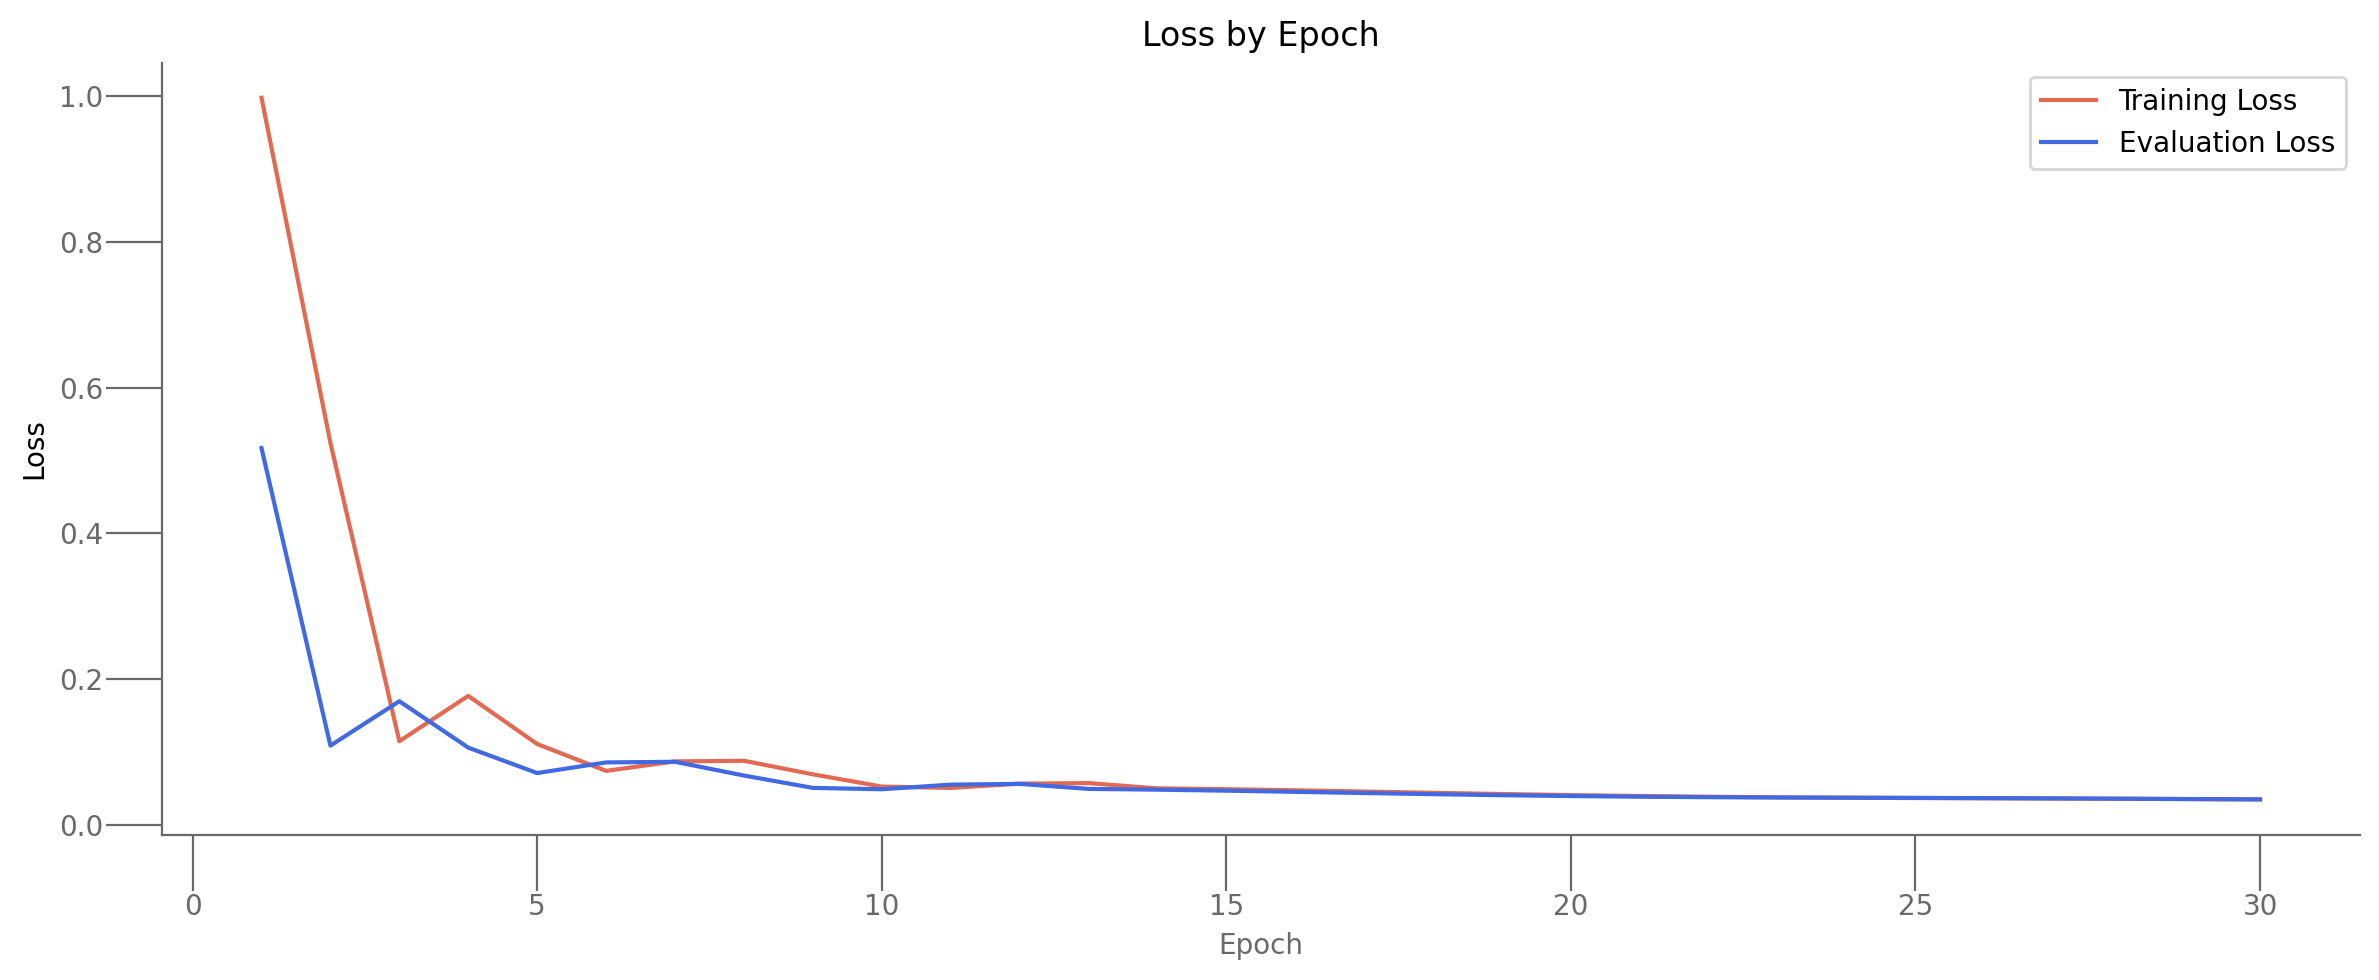


==================== TEST INFO ===================

Test_loss:0.0375, Test_r2:0.1548


In [58]:

model_bf = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")

num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_bf, dataloader_bf, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes_bf, predictions_bf, real_bf = test(model_bf, dataloader_bf, h)


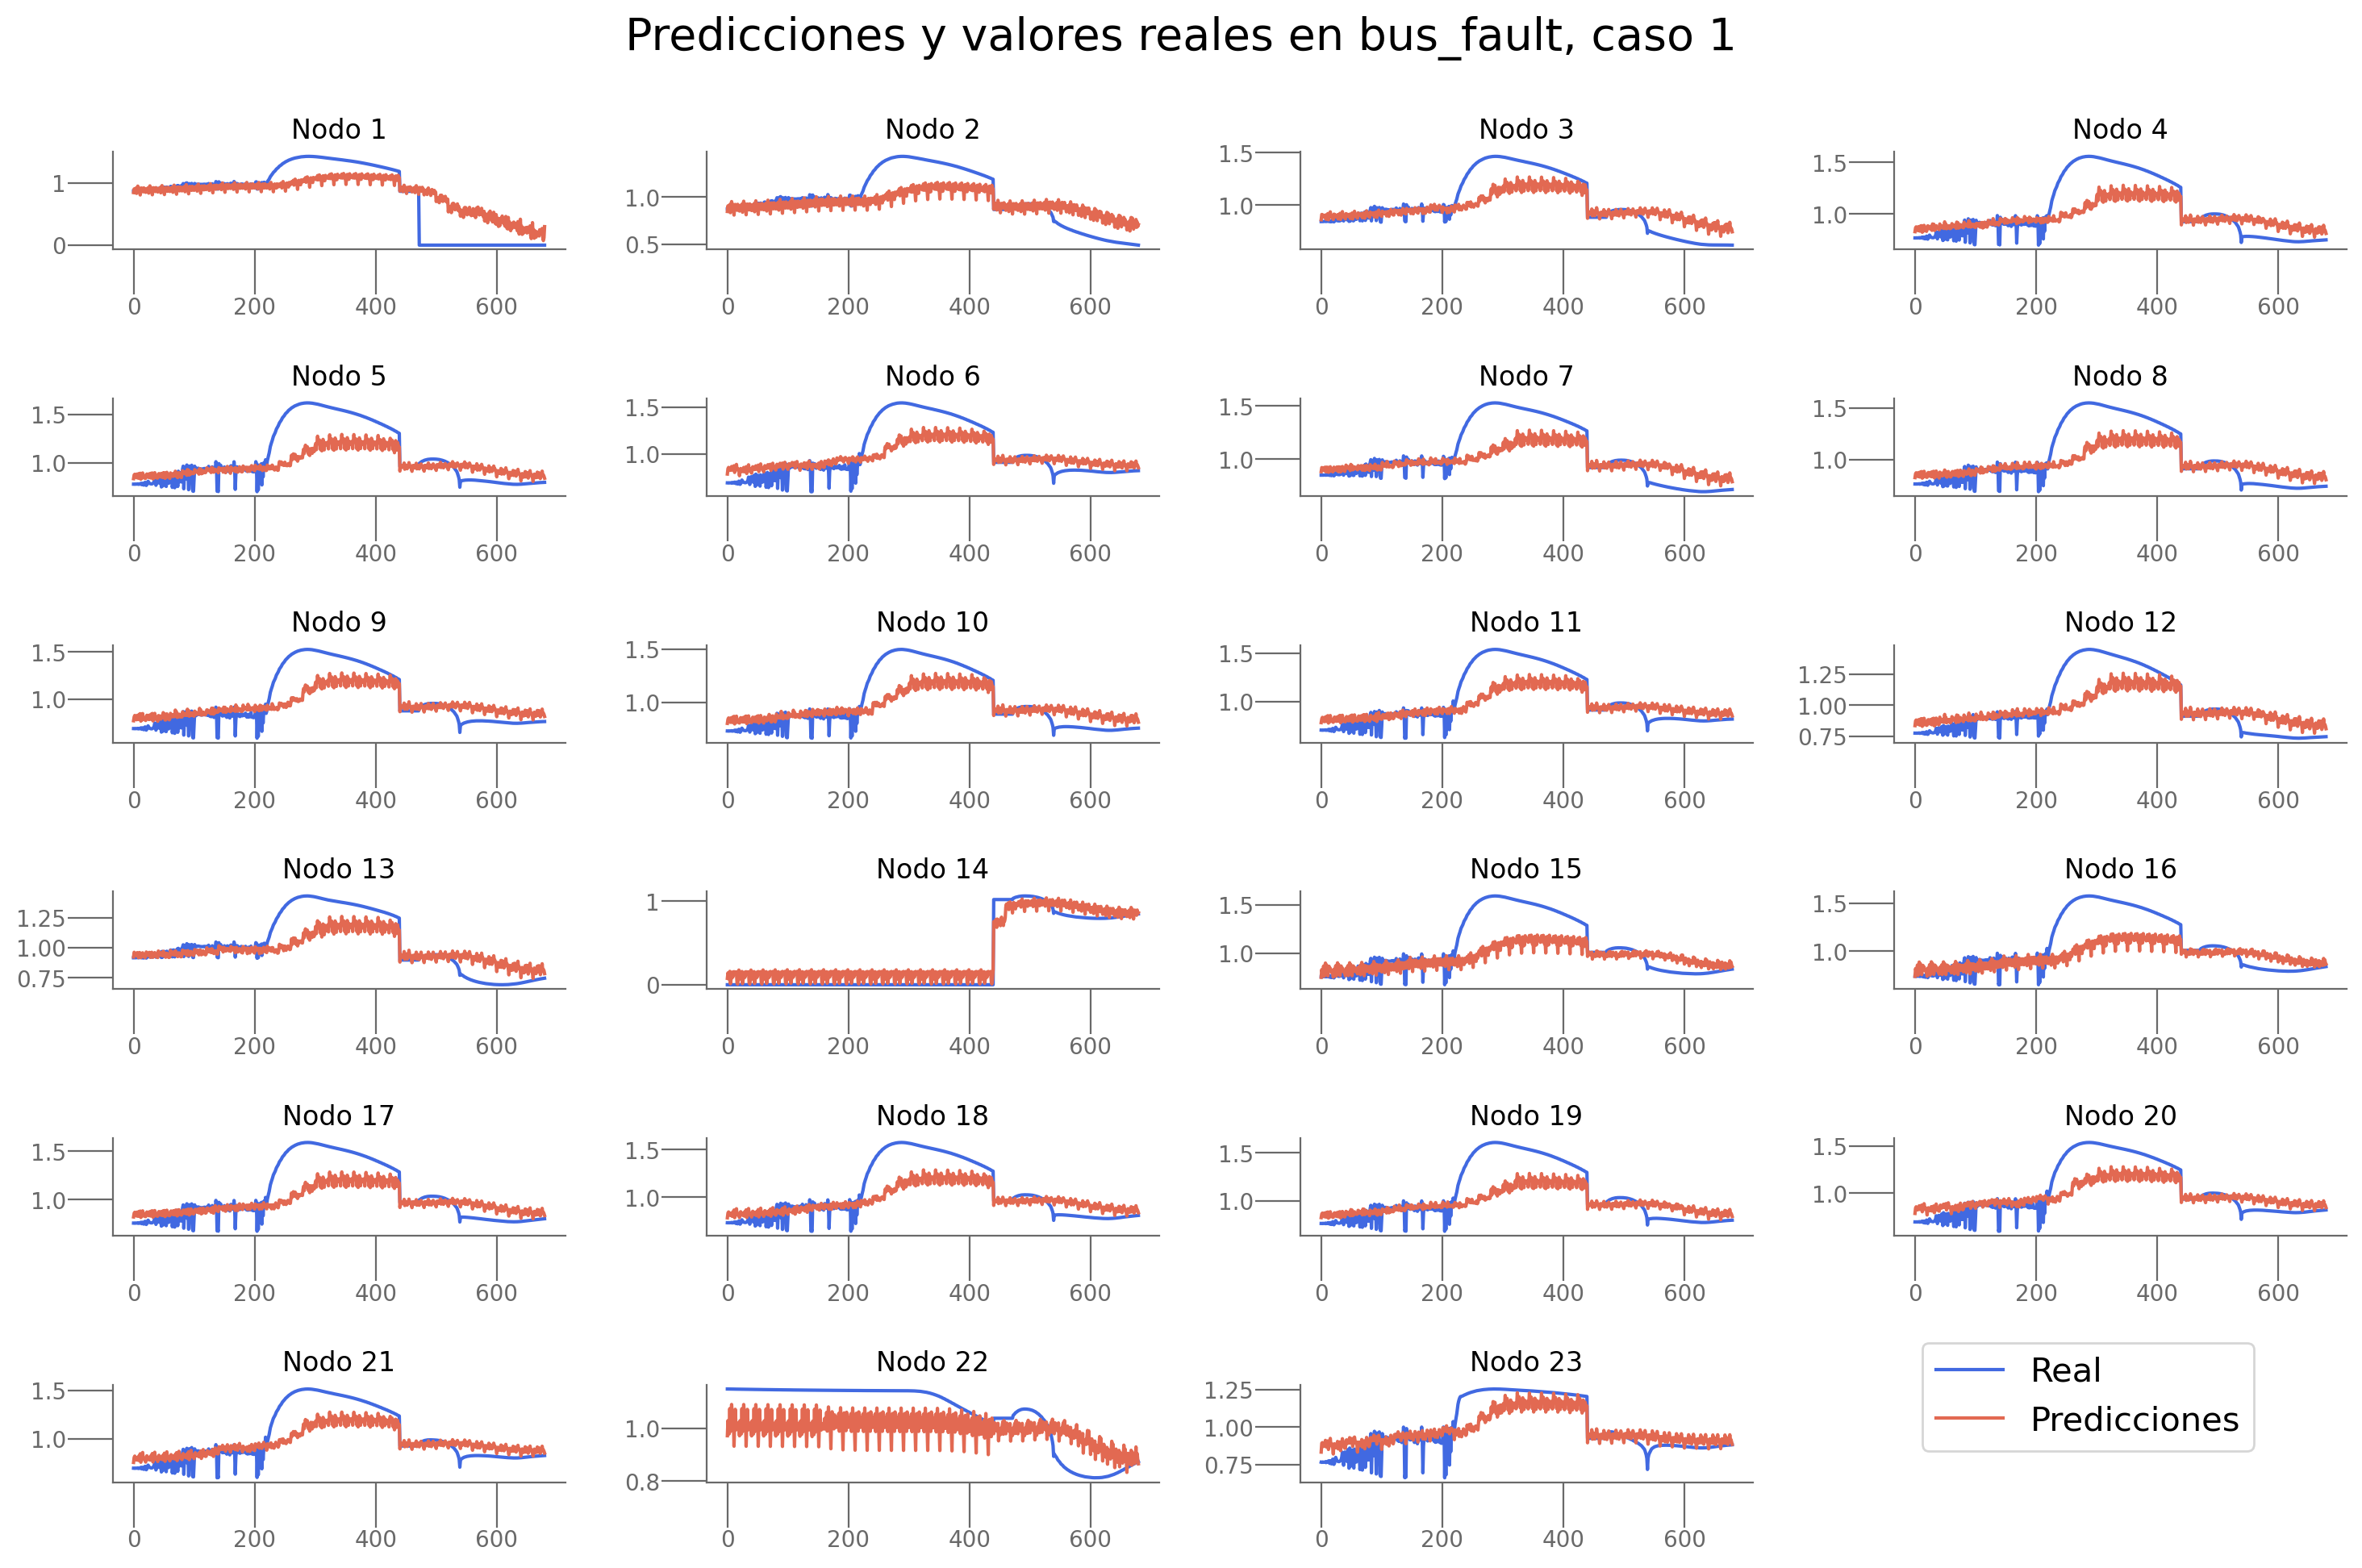

In [59]:
plot_predictions(predictions_bf, real_bf, n_target, 1,n_div_bf, problem_bf)

#### Ajuste de parámetros 

In [38]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

modelo_bf,params_bf,resultados_final_bf, resultados_bf, h = entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader_bf, num_early_stop, num_epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]


==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1092 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5600 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8607 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0742 | Eval Loss: 0.0861 | Eval R2: -1.1589 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0874 | Eval Loss: 0.0869 | Eval R2: -1.1426 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0677 | Eval R2: -0.5673 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0695 | Eval Loss: 0.0507 | Eval R2: -0.1592 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0527 | Eval Loss: 0.0491 | Eval R2: -0.3331 | LR: 0.010000
Epoch 11/30 | Train Loss: 0.0509 | Eval Loss: 0.0556 | Eval R2: -0.7378 | LR: 0.0100

 12%|█▎        | 1/8 [06:41<46:50, 401.49s/it]

Test_loss:0.0375, Test_r2:0.1483
Parámetros:  add 1 1
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.03504887595772743, 'r2_eval_final': 0.2149667754506941, 'loss_eval_final': 0.03508453184053644, 'r2_test': 0.14829678195282814, 'loss_test': 0.037457264519599805, 'loss_nodes': [0.02961997129023075, 0.031524479389190674, 0.030795307829976082, 0.04326203092932701, 0.04835682734847069, 0.04622136056423187, 0.03576618805527687, 0.04792538657784462, 0.04710523784160614, 0.03914264589548111, 0.04478836804628372, 0.03211897239089012, 0.02164134569466114, 0.03148755431175232, 0.03465857729315758, 0.031522538512945175, 0.04413169249892235, 0.03953021764755249, 0.048732928931713104, 0.04104926064610481, 0.040634240955114365, 0.023137642070651054, 0.02836431749165058]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9998 | Eval Loss: 0.6646 | Eval R2: -21.3004 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6670 | Eval Loss: 0.1435 | Eval R2: -3.2673

 25%|██▌       | 2/8 [13:14<39:40, 396.73s/it]

Parámetros:  add 1 2
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.01299922913312912, 'r2_eval_final': 0.5370138364009504, 'loss_eval_final': 0.013931121967261893, 'r2_test': 0.5771102815805799, 'loss_test': 0.014084230070977017, 'loss_nodes': [0.01208098791539669, 0.014354287646710873, 0.011046727187931538, 0.017093447968363762, 0.015017243102192879, 0.017043402418494225, 0.013402557000517845, 0.017635982483625412, 0.018838955089449883, 0.014193867333233356, 0.015436897985637188, 0.013206482864916325, 0.007062685675919056, 0.012002873234450817, 0.012795981019735336, 0.009762617759406567, 0.018446078523993492, 0.01295623928308487, 0.01776382140815258, 0.015441064722836018, 0.014988859184086323, 0.007971541956067085, 0.015394716523587704]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0298 | Eval Loss: 0.5931 | Eval R2: -18.4529 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6060 | Eval Loss: 0.1793 | Eval R2: -5.4291 | LR: 0.010000
Epo

 38%|███▊      | 3/8 [22:24<38:51, 466.36s/it]

Test_loss:0.0153, Test_r2:0.5725
Parámetros:  add 2 1
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.013187841512262821, 'r2_eval_final': 0.5832831548605094, 'loss_eval_final': 0.015145501725097326, 'r2_test': 0.5724551253719028, 'loss_test': 0.015254601721413607, 'loss_nodes': [0.010763081721961498, 0.015327143482863903, 0.012233758345246315, 0.016374805942177773, 0.018517687916755676, 0.01956702023744583, 0.01302228681743145, 0.019314611330628395, 0.018941659480333328, 0.015684030950069427, 0.017963632941246033, 0.012151314876973629, 0.009410545229911804, 0.01148101594299078, 0.013909951783716679, 0.011401558294892311, 0.021081259474158287, 0.014885538257658482, 0.019211694598197937, 0.018061721697449684, 0.01692074164748192, 0.008876585401594639, 0.015754180029034615]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0262 | Eval Loss: 0.8002 | Eval R2: -26.9340 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7923 | Eval Loss: 0.1396 | Ev

 50%|█████     | 4/8 [31:56<33:53, 508.31s/it]

Test_loss:0.0815, Test_r2:-1.0093
Parámetros:  add 2 2
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.08331742882728577, 'r2_eval_final': -0.7672409076153324, 'loss_eval_final': 0.07733388944721685, 'r2_test': -1.009345695427818, 'loss_test': 0.0814963566485879, 'loss_nodes': [0.1477009505033493, 0.05984247475862503, 0.053681399673223495, 0.0966196358203888, 0.0680009052157402, 0.06806721538305283, 0.05400148779153824, 0.11497095972299576, 0.07087310403585434, 0.10881857573986053, 0.06507346779108047, 0.04942227900028229, 0.034102555364370346, 0.09574396908283234, 0.09755118936300278, 0.04643400013446808, 0.15426048636436462, 0.05715508013963699, 0.11846041679382324, 0.13483071327209473, 0.0602218396961689, 0.03118930011987686, 0.08739445358514786]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0127 | Eval Loss: 0.4534 | Eval R2: -13.4972 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.4624 | Eval Loss: 0.2409 | Eval R2: -7.8839 | LR: 0.

 62%|██████▎   | 5/8 [38:52<23:44, 474.88s/it]

Test_loss:0.0373, Test_r2:0.0544
Parámetros:  mean 1 1
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.03529909998178482, 'r2_eval_final': 0.13370438296945542, 'loss_eval_final': 0.035494785639725024, 'r2_test': 0.054368034901816534, 'loss_test': 0.03729903924733747, 'loss_nodes': [0.04385227710008621, 0.039648838341236115, 0.029447952285408974, 0.04306529834866524, 0.0441952683031559, 0.04191944748163223, 0.033967021852731705, 0.04793332889676094, 0.046092644333839417, 0.03910441696643829, 0.04168543219566345, 0.031240299344062805, 0.02055537700653076, 0.03631974756717682, 0.035231783986091614, 0.02806115336716175, 0.04453185945749283, 0.03602321818470955, 0.047064296901226044, 0.03969750553369522, 0.03736977279186249, 0.021178070455789566, 0.02969295345246792]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9976 | Eval Loss: 0.6626 | Eval R2: -21.3945 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6620 | Eval Loss: 0.1482 | Eval R2: -3

 75%|███████▌  | 6/8 [45:44<15:07, 453.50s/it]

Test_loss:0.0776, Test_r2:-0.8489
Parámetros:  mean 1 2
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.07819387316703796, 'r2_eval_final': -0.6340584201364261, 'loss_eval_final': 0.07381195671262283, 'r2_test': -0.8489035720780548, 'loss_test': 0.07755276716834064, 'loss_nodes': [0.14559414982795715, 0.05726493522524834, 0.049633532762527466, 0.10204965621232986, 0.06773649901151657, 0.06497487425804138, 0.05328913778066635, 0.10725124925374985, 0.0679982528090477, 0.0998312383890152, 0.06313128769397736, 0.04744795337319374, 0.03327077254652977, 0.09524816274642944, 0.090144582092762, 0.0458340086042881, 0.13659775257110596, 0.056129343807697296, 0.10971079021692276, 0.12184446305036545, 0.057695746421813965, 0.032508403062820435, 0.07852695137262344]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0250 | Eval Loss: 0.5622 | Eval R2: -17.8070 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5584 | Eval Loss: 0.1987 | Eval R2: -5.8415 | L

 88%|████████▊ | 7/8 [54:52<08:04, 484.49s/it]

Test_loss:0.0304, Test_r2:0.1683
Parámetros:  mean 2 1
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.029198188334703445, 'r2_eval_final': 0.15346683464637734, 'loss_eval_final': 0.02975892587083167, 'r2_test': 0.1683303942092141, 'loss_test': 0.030398150917879025, 'loss_nodes': [0.04218930006027222, 0.03647483512759209, 0.026378212496638298, 0.03377194702625275, 0.03377347066998482, 0.03643910214304924, 0.026040155440568924, 0.035057950764894485, 0.034402091056108475, 0.029124373570084572, 0.0322098582983017, 0.023859769105911255, 0.015505751594901085, 0.0339953675866127, 0.027956081554293633, 0.025433752685785294, 0.035061635076999664, 0.02854005992412567, 0.03730747476220131, 0.03320879489183426, 0.030856478959321976, 0.016008885577321053, 0.025562189519405365]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0628 | Eval Loss: 0.8605 | Eval R2: -28.6735 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.8622 | Eval Loss: 0.1891 | Eval R2:

100%|██████████| 8/8 [1:04:59<00:00, 487.50s/it]

Test_loss:0.0810, Test_r2:-0.9101
Parámetros:  mean 2 2
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.0825948715209961, 'r2_eval_final': -0.7274237965688775, 'loss_eval_final': 0.07804089078048095, 'r2_test': -0.9100995974718089, 'loss_test': 0.08096241064607924, 'loss_nodes': [0.14877820014953613, 0.05635567009449005, 0.05013884976506233, 0.1063566729426384, 0.06777995824813843, 0.06555211544036865, 0.05324350669980049, 0.1098012775182724, 0.06622827053070068, 0.10889091342687607, 0.06287404894828796, 0.04709934815764427, 0.03397751227021217, 0.09841068089008331, 0.09884274750947952, 0.04644152894616127, 0.1524505913257599, 0.05639757961034775, 0.11609839648008347, 0.1389385610818863, 0.05763187259435654, 0.03356781229376793, 0.0862792506814003]}


In [43]:
losses_tst, r2score_tst, loss_nodes_bf, predictions_bf_ajuste, real_bf_ajuste = test(modelo_bf, dataloader_bf, modelo_bf.h)



==================== TEST INFO ===================

Test_loss:0.0141, Test_r2:0.5771


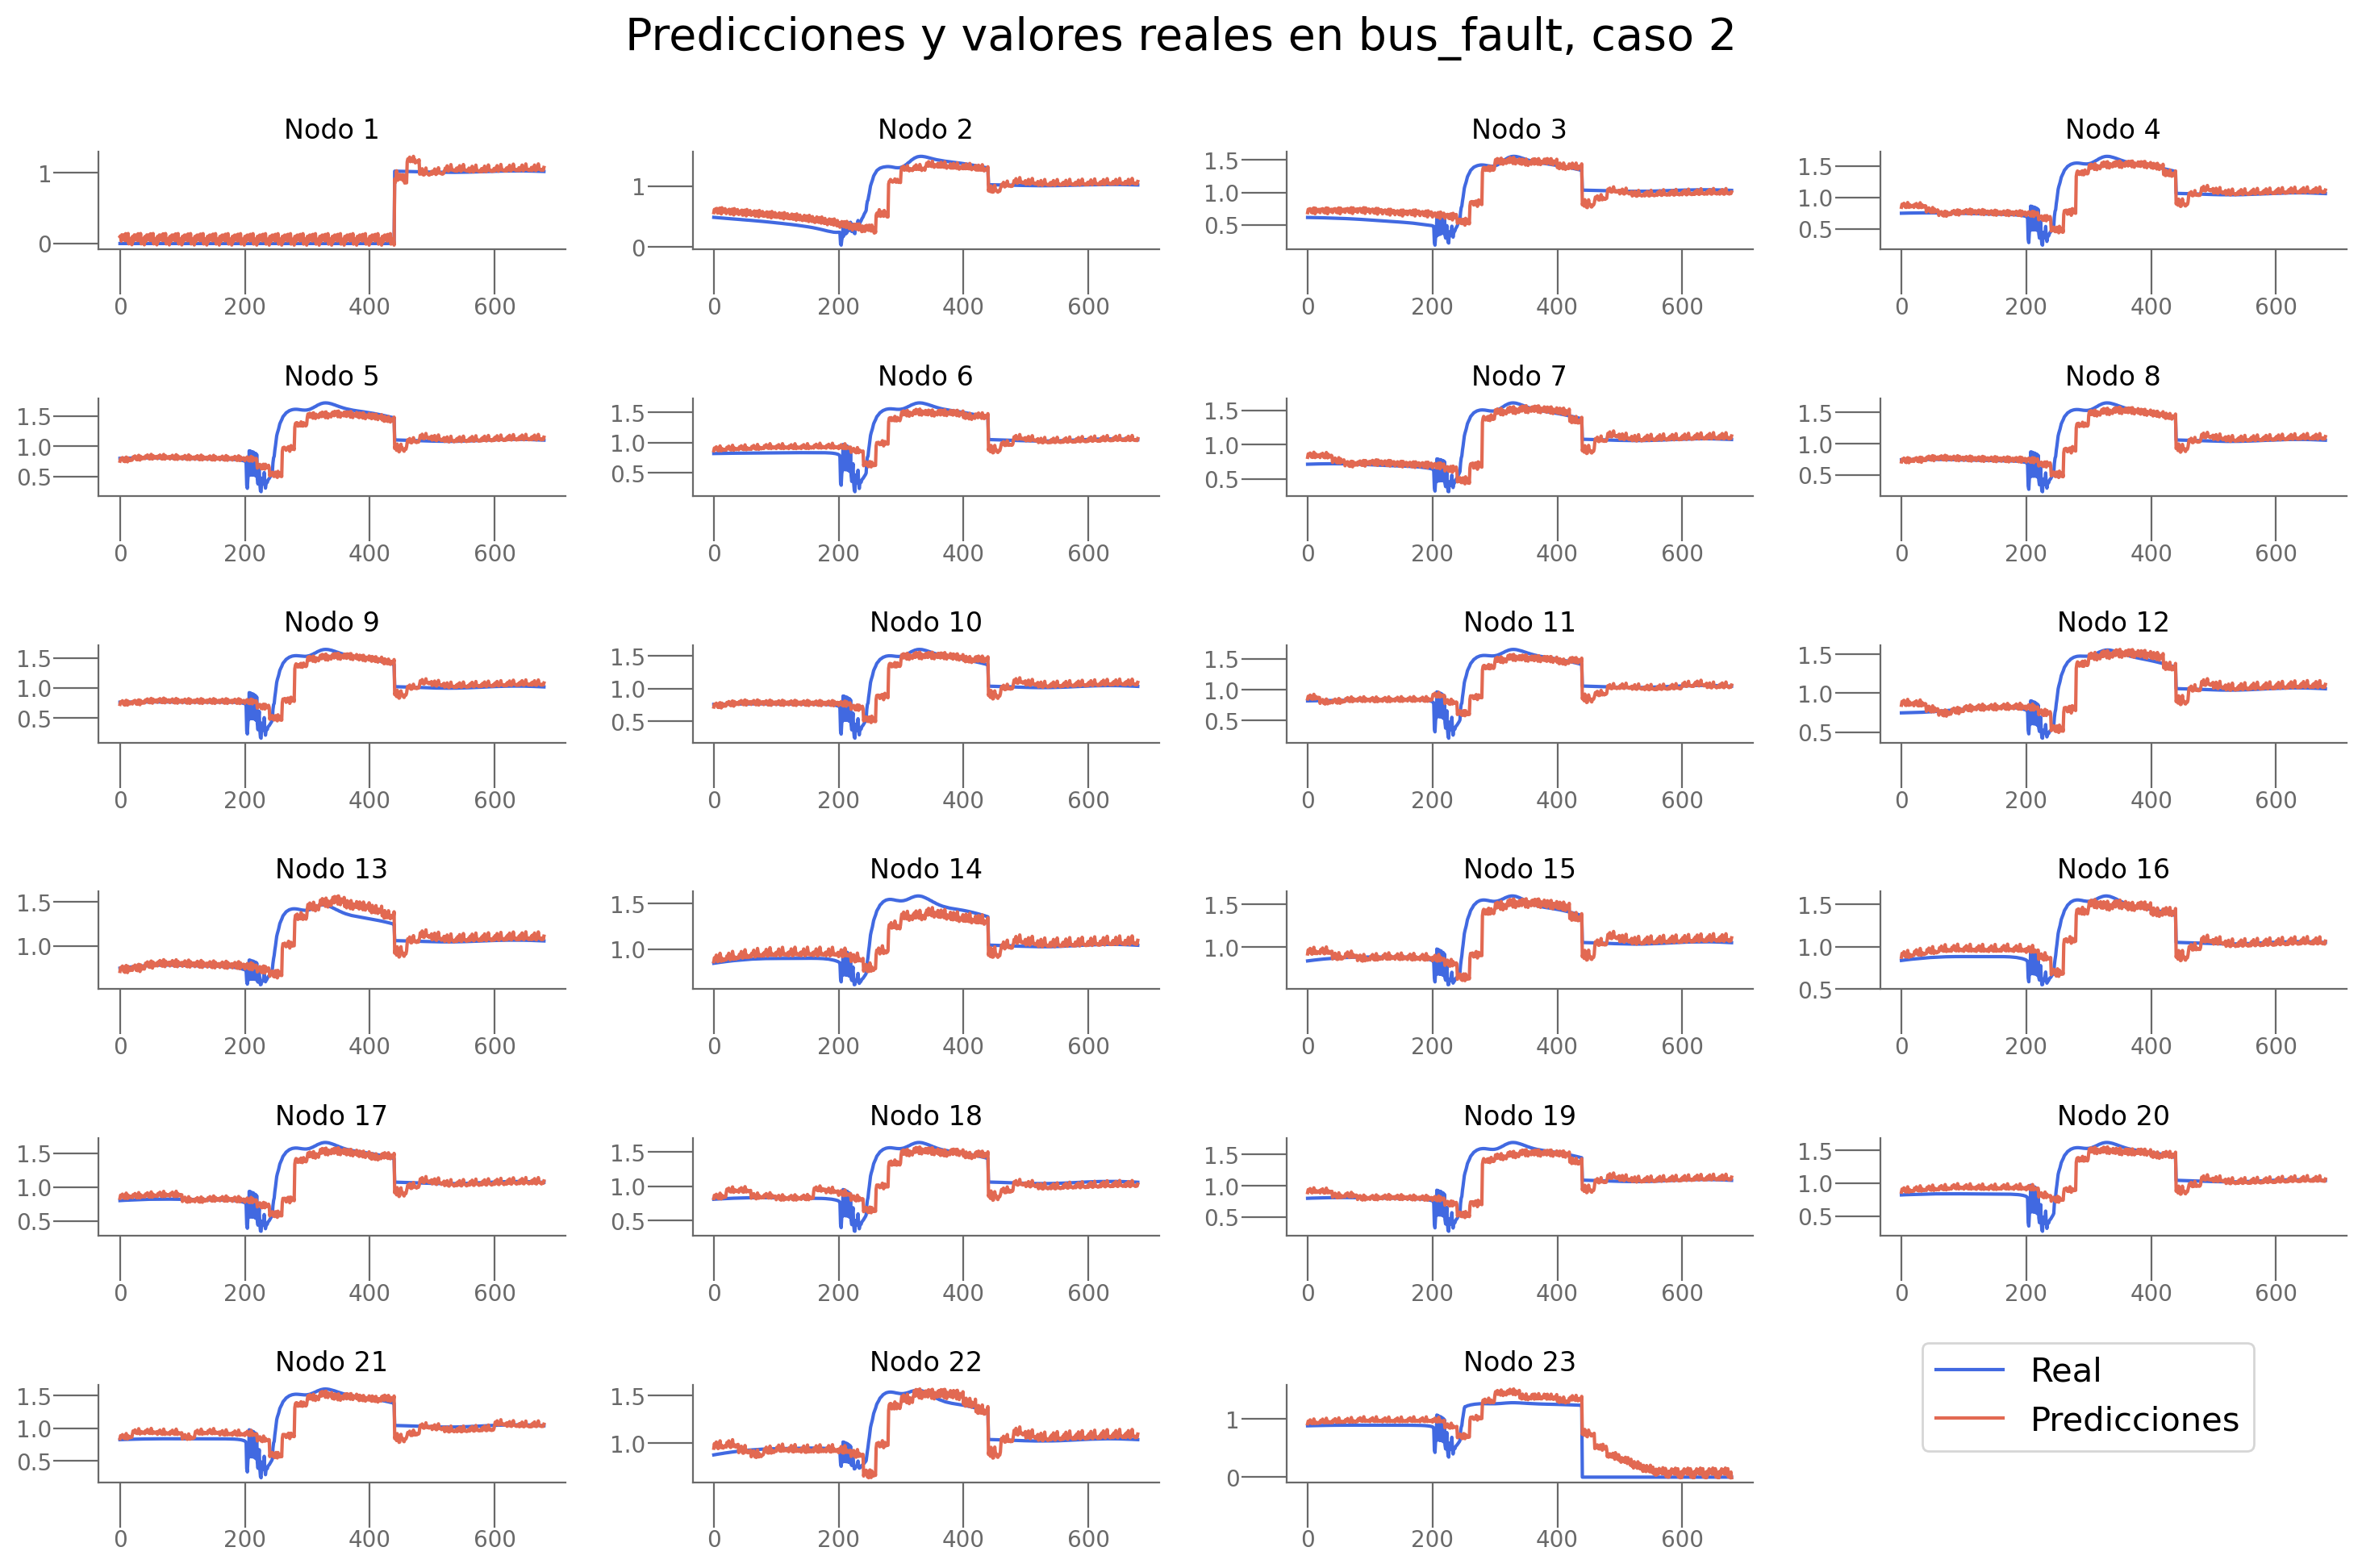

In [44]:
plot_predictions(predictions_bf_ajuste, real_bf_ajuste, n_target, 2, n_div_bf, problem_bf)

In [39]:
path_save_experiment_bf = results_save_path+f"/{problem_bf}"+ f"/ajustes/{name_model}_results.csv"
resultados_bf.to_csv(path_save_experiment_bf, index=False)

In [40]:
guardar_resultados(modelo_bf, "DryGrEncoder", problem_bf, resultados_final_bf, results_save_path, path_save_experiment_bf, params_bf)


==================== GUARDANDO RESULTADOS ===================

         Modelo       Params  \
0          LSTM          NaN   
1  DryGrEncoder  (add, 1, 2)   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.016884  0.601978   
1  ./results/bus_fault/ajustes/DryGrEncoder_resul...  0.014084  0.577110   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.01173629 0.00995132 0.0126239  0.01929585 0... -7.654841   0.181827   
1  [0.01208098791539669, 0.014354287646710873, 0....  0.537014   0.013931   

   Loss_final  
0    0.016603  
1    0.012999  

==================== RESULTADOS GUARDADOS ===================



### Branch Fault

In [46]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [47]:
n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
embedding_dim =5

dataloader_brf = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430


#### Sencilla 


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1089 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5601 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8616 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0742 | Eval Loss: 0.0858 | Eval R2: -1.1448 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0872 | Eval Loss: 0.0867 | Eval R2: -1.1407 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0678 | Eval R2: -0.5723 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0695 | Eval Loss: 0.0509 | Eval R2: -0.1620 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0527 | Eval Loss: 0.0490 

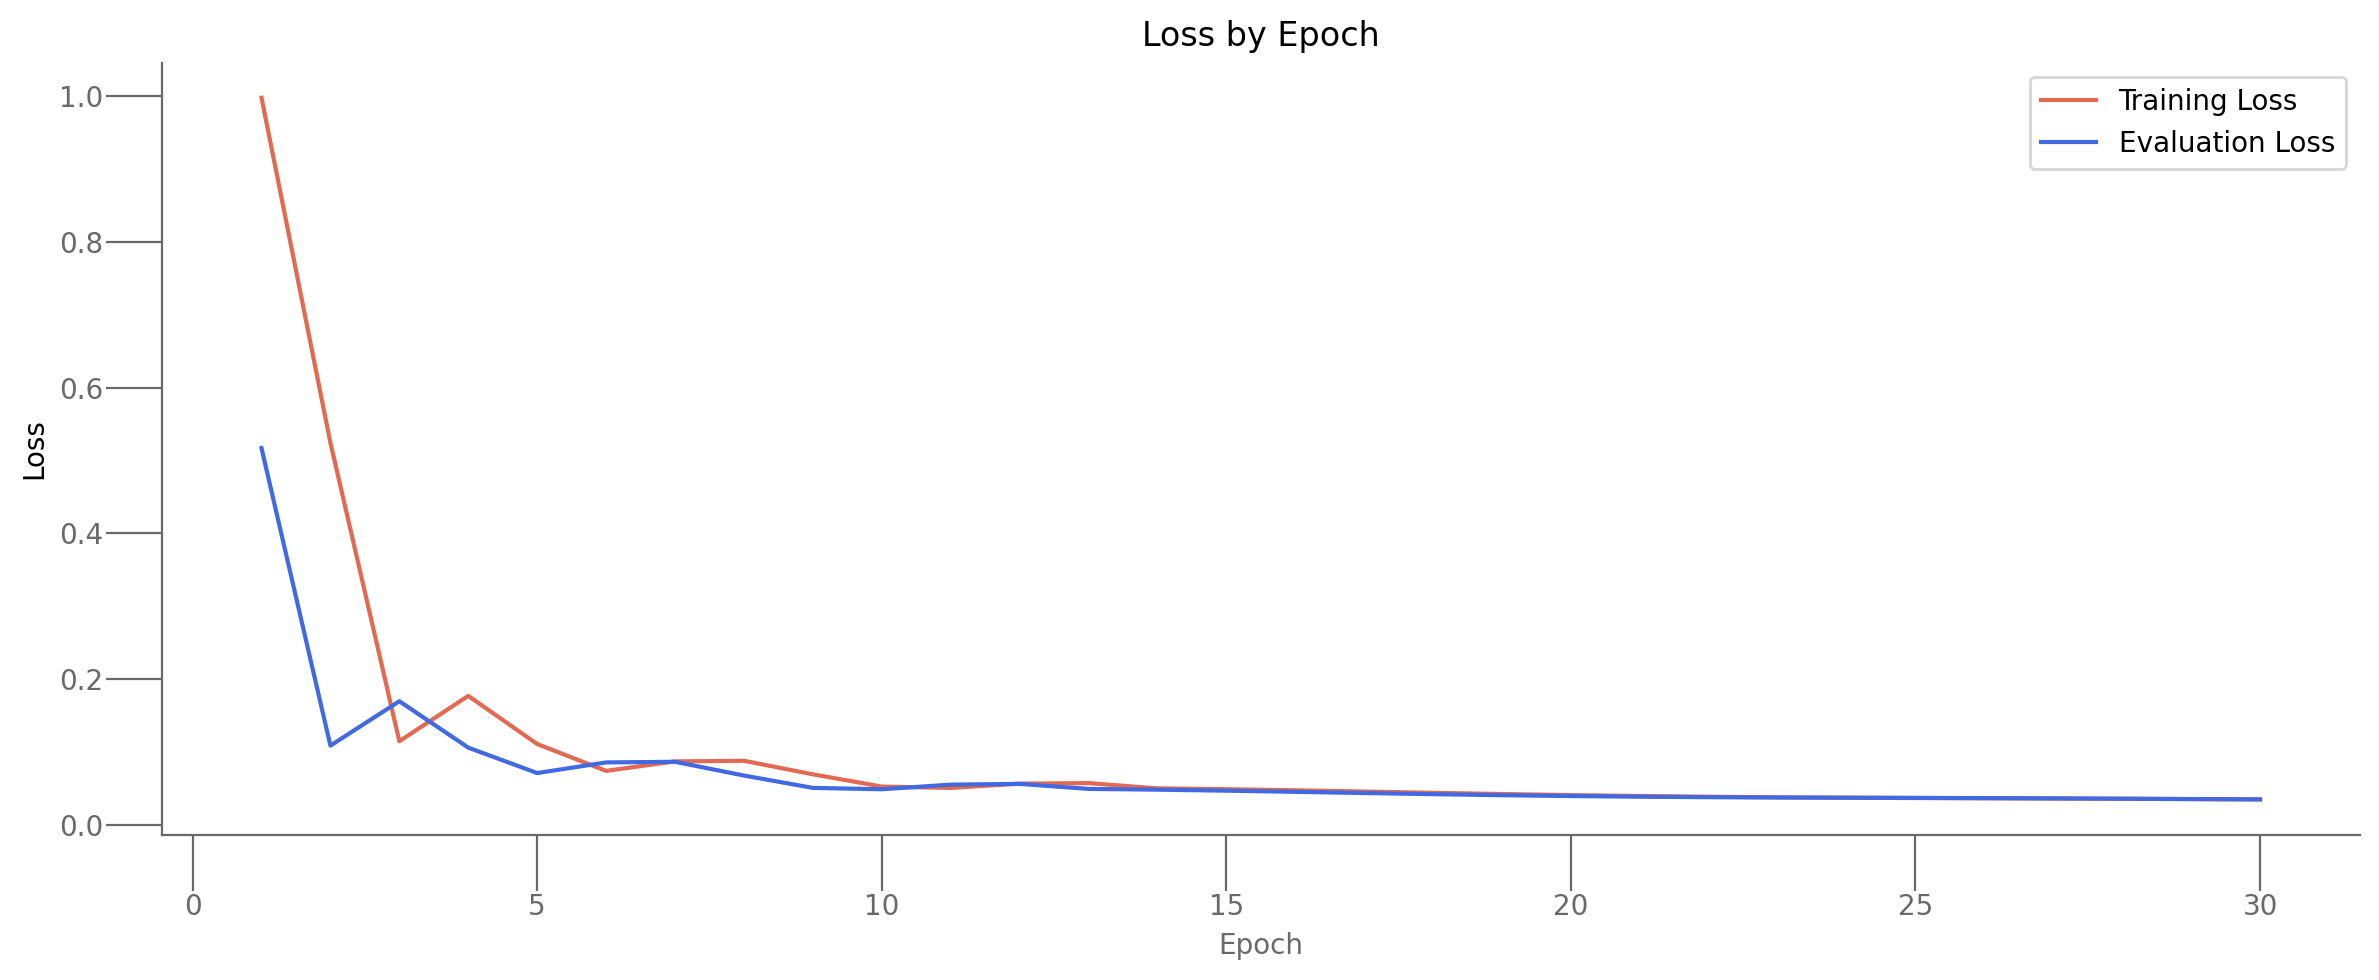


==================== TEST INFO ===================

Test_loss:0.0375, Test_r2:0.1548


In [63]:

model_brf = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")


num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_brf, dataloader_brf, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes_brf, predictions_brf, real_brf = test(model_brf, dataloader_brf, h)


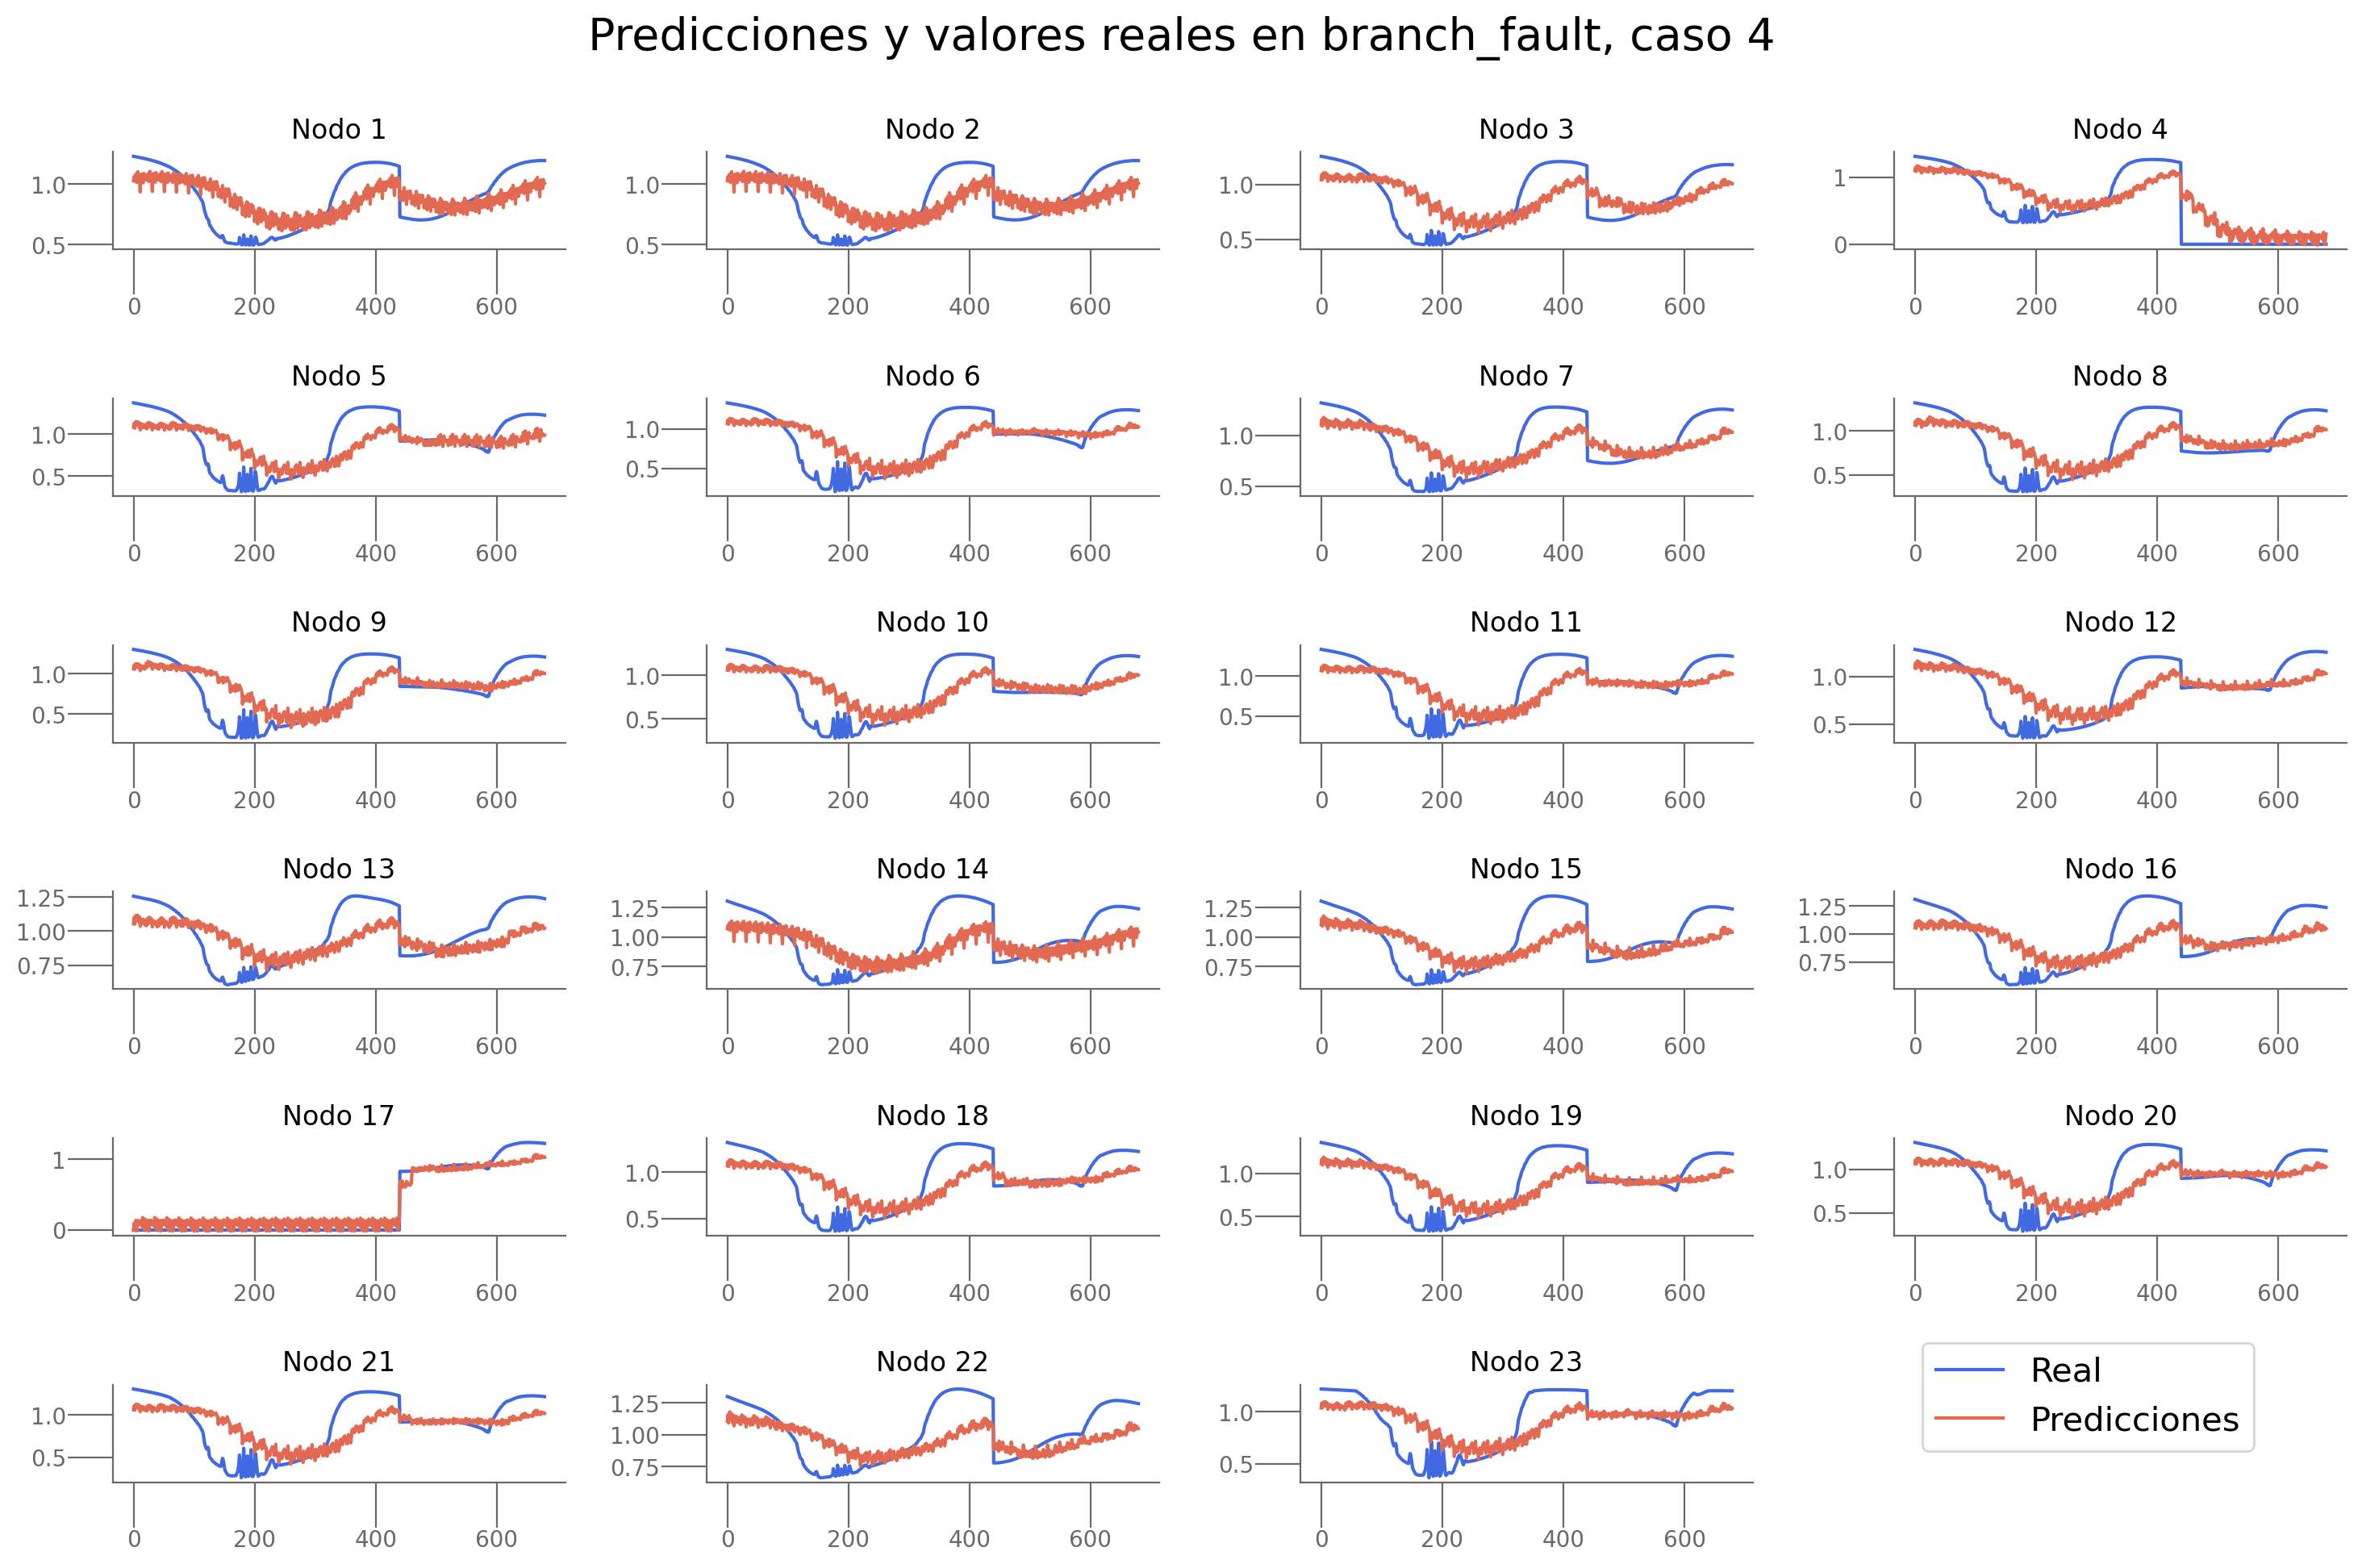

In [64]:
plot_predictions(predictions_brf, real_brf, n_target, 4,  n_div_brf, problem_brf)

#### Ajuste de parámetros 

In [48]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

modelo_brf,params_brf,resultados_final_brf, resultados_brf, h = entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader_brf, num_early_stop, num_epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]


==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1092 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5601 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8605 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0741 | Eval Loss: 0.0860 | Eval R2: -1.1578 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0873 | Eval Loss: 0.0870 | Eval R2: -1.1532 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0678 | Eval R2: -0.5686 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0694 | Eval Loss: 0.0507 | Eval R2: -0.1581 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0525 | Eval Loss: 0.0491 | Eval R2: -0.3337 | LR: 0.010000
Epoch 11/30 | Train Loss: 0.0508 | Eval Loss: 0.0557 | Eval R2: -0.7409 | LR: 0.0100

 12%|█▎        | 1/8 [07:32<52:48, 452.71s/it]

Test_loss:0.0376, Test_r2:0.1470
Parámetros:  add 1 1
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.034898336976766586, 'r2_eval_final': 0.21504550967261102, 'loss_eval_final': 0.03489645688858783, 'r2_test': 0.14700801744577482, 'loss_test': 0.037610419444620694, 'loss_nodes': [0.029657339677214622, 0.03162076324224472, 0.031009431928396225, 0.043395791202783585, 0.048472434282302856, 0.046266108751297, 0.03606223315000534, 0.0481371209025383, 0.04723349213600159, 0.03914602845907211, 0.04493648186326027, 0.03229491785168648, 0.021830009296536446, 0.03166819363832474, 0.03501151502132416, 0.031788527965545654, 0.04401923343539238, 0.03970915824174881, 0.04910982772707939, 0.04113893210887909, 0.04078132286667824, 0.023532342165708542, 0.028218451887369156]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9998 | Eval Loss: 0.6646 | Eval R2: -21.3004 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6670 | Eval Loss: 0.1435 | Eval R2: -3.267

 25%|██▌       | 2/8 [14:02<41:35, 415.87s/it]

Parámetros:  add 1 2
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.014402590692043304, 'r2_eval_final': 0.5373121225791289, 'loss_eval_final': 0.014043626115368357, 'r2_test': 0.5068902925655494, 'loss_test': 0.014330437694416316, 'loss_nodes': [0.012768067419528961, 0.014942342415452003, 0.011256908066570759, 0.01665751449763775, 0.015761448070406914, 0.01738525927066803, 0.012543552555143833, 0.018028896301984787, 0.018849432468414307, 0.0142911896109581, 0.0168781541287899, 0.012666907161474228, 0.006821800488978624, 0.012806480750441551, 0.012706641107797623, 0.01046826969832182, 0.019223704934120178, 0.01336523424834013, 0.01836307905614376, 0.016046572476625443, 0.015583908185362816, 0.007484883069992065, 0.014699828810989857]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0298 | Eval Loss: 0.5931 | Eval R2: -18.4528 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6060 | Eval Loss: 0.1793 | Eval R2: -5.4291 | LR: 0.010000
Epoch 3/

 38%|███▊      | 3/8 [23:22<40:07, 481.48s/it]

Test_loss:0.0151, Test_r2:0.5764
Parámetros:  add 2 1
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.01305139809846878, 'r2_eval_final': 0.5761045225578307, 'loss_eval_final': 0.014627642092701775, 'r2_test': 0.5763977091014055, 'loss_test': 0.015149368036830755, 'loss_nodes': [0.010656297206878662, 0.014884302392601967, 0.011409108527004719, 0.016865000128746033, 0.017823554575443268, 0.020515672862529755, 0.014558813534677029, 0.01944584585726261, 0.01865542121231556, 0.014272346161305904, 0.017627444118261337, 0.013580474071204662, 0.007672708481550217, 0.011333012022078037, 0.013267319649457932, 0.012284837663173676, 0.02054498717188835, 0.014650348573923111, 0.019536959007382393, 0.01728695072233677, 0.017510855570435524, 0.007886119186878204, 0.016167132183909416]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0262 | Eval Loss: 0.8002 | Eval R2: -26.9340 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7923 | Eval Loss: 0.1396 | Eva

 50%|█████     | 4/8 [33:10<34:54, 523.74s/it]

Test_loss:0.0816, Test_r2:-1.0127
Parámetros:  add 2 2
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.0827062800526619, 'r2_eval_final': -0.7589251587760176, 'loss_eval_final': 0.07688174686159124, 'r2_test': -1.0126988026162012, 'loss_test': 0.08163887415037946, 'loss_nodes': [0.1478460282087326, 0.05998016893863678, 0.05354654788970947, 0.11025309562683105, 0.06774283945560455, 0.06815818697214127, 0.05392542481422424, 0.11235089600086212, 0.0711614266037941, 0.1081550121307373, 0.06468521058559418, 0.049031298607587814, 0.0340518057346344, 0.09575528651475906, 0.09762390702962875, 0.0463671050965786, 0.1504218578338623, 0.05701584741473198, 0.11621476709842682, 0.1342918872833252, 0.06012863665819168, 0.03119061514735222, 0.08779634535312653]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0127 | Eval Loss: 0.4534 | Eval R2: -13.4972 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.4624 | Eval Loss: 0.2409 | Eval R2: -7.8839 | LR: 0.010

 62%|██████▎   | 5/8 [40:40<24:51, 497.13s/it]

Test_loss:0.0373, Test_r2:0.0548
Parámetros:  mean 1 1
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.03530774638056755, 'r2_eval_final': 0.13313500556943447, 'loss_eval_final': 0.035541948247915026, 'r2_test': 0.054811222091265356, 'loss_test': 0.037291344214057505, 'loss_nodes': [0.04382775351405144, 0.03962980583310127, 0.029425423592329025, 0.04313505440950394, 0.04417826235294342, 0.04184902831912041, 0.03408745303750038, 0.047893572598695755, 0.046003639698028564, 0.039105117321014404, 0.04160553589463234, 0.031249497085809708, 0.02067824825644493, 0.036333173513412476, 0.035219043493270874, 0.02799091301858425, 0.044537611305713654, 0.036054592579603195, 0.04719534516334534, 0.039643432945013046, 0.03729494661092758, 0.02121555246412754, 0.02954791486263275]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9976 | Eval Loss: 0.6626 | Eval R2: -21.3945 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6620 | Eval Loss: 0.1482 | Eval R2

 75%|███████▌  | 6/8 [47:42<15:42, 471.42s/it]

Test_loss:0.0769, Test_r2:-0.8329
Parámetros:  mean 1 2
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.07766705751419067, 'r2_eval_final': -0.619289690050435, 'loss_eval_final': 0.07318528472263923, 'r2_test': -0.8328988383088375, 'loss_test': 0.07689817694643902, 'loss_nodes': [0.14568981528282166, 0.05732891336083412, 0.04966719448566437, 0.10034050792455673, 0.06769074499607086, 0.06499951332807541, 0.05331782251596451, 0.10592413693666458, 0.06802035123109818, 0.09788740426301956, 0.06316447257995605, 0.04753883183002472, 0.03334666043519974, 0.09524030238389969, 0.08879043161869049, 0.04582660272717476, 0.13458353281021118, 0.05621473118662834, 0.1092253103852272, 0.11725223809480667, 0.05767892301082611, 0.032575465738773346, 0.07635410875082016]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0250 | Eval Loss: 0.5622 | Eval R2: -17.8070 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5584 | Eval Loss: 0.1987 | Eval R2: -5.8415 | L

 88%|████████▊ | 7/8 [57:15<08:24, 504.61s/it]

Test_loss:0.0307, Test_r2:0.1512
Parámetros:  mean 2 1
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.029506031423807144, 'r2_eval_final': 0.1504807778466676, 'loss_eval_final': 0.02973193853783111, 'r2_test': 0.1512260775714821, 'loss_test': 0.030679818148573124, 'loss_nodes': [0.04257325828075409, 0.03664974495768547, 0.027749227359890938, 0.03373339772224426, 0.03432494401931763, 0.0361621230840683, 0.025996681302785873, 0.03570340573787689, 0.035580821335315704, 0.029871195554733276, 0.03244080767035484, 0.024391334503889084, 0.015959594398736954, 0.03416033089160919, 0.028431573882699013, 0.025617701932787895, 0.03516598045825958, 0.0290470439940691, 0.0377771370112896, 0.03305293247103691, 0.030488494783639908, 0.016297077760100365, 0.02446109615266323]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0628 | Eval Loss: 0.8605 | Eval R2: -28.6735 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.8622 | Eval Loss: 0.1891 | Eval R2: -4.9

100%|██████████| 8/8 [1:56:25<00:00, 873.17s/it] 

Test_loss:0.0809, Test_r2:-0.9024
Parámetros:  mean 2 2
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.08243588358163834, 'r2_eval_final': -0.7247105924565855, 'loss_eval_final': 0.07798472188959091, 'r2_test': -0.9023727237222608, 'loss_test': 0.08090812303883911, 'loss_nodes': [0.14909639954566956, 0.05645189434289932, 0.05000859498977661, 0.10581401735544205, 0.06736220419406891, 0.06504202634096146, 0.052905935794115067, 0.10885363072156906, 0.06553184241056442, 0.10855589061975479, 0.06240737810730934, 0.04647891968488693, 0.03428354114294052, 0.0984354093670845, 0.09795170277357101, 0.0462726466357708, 0.152042418718338, 0.0562928281724453, 0.1183067262172699, 0.14066435396671295, 0.05744049325585365, 0.03365693613886833, 0.08703125268220901]}


In [49]:
losses_tst, r2score_tst, loss_nodes_brf, predictions_brf_ajuste, real_brf_ajuste = test(modelo_brf, dataloader_brf, modelo_brf.h)



==================== TEST INFO ===================

Test_loss:0.0143, Test_r2:0.5069


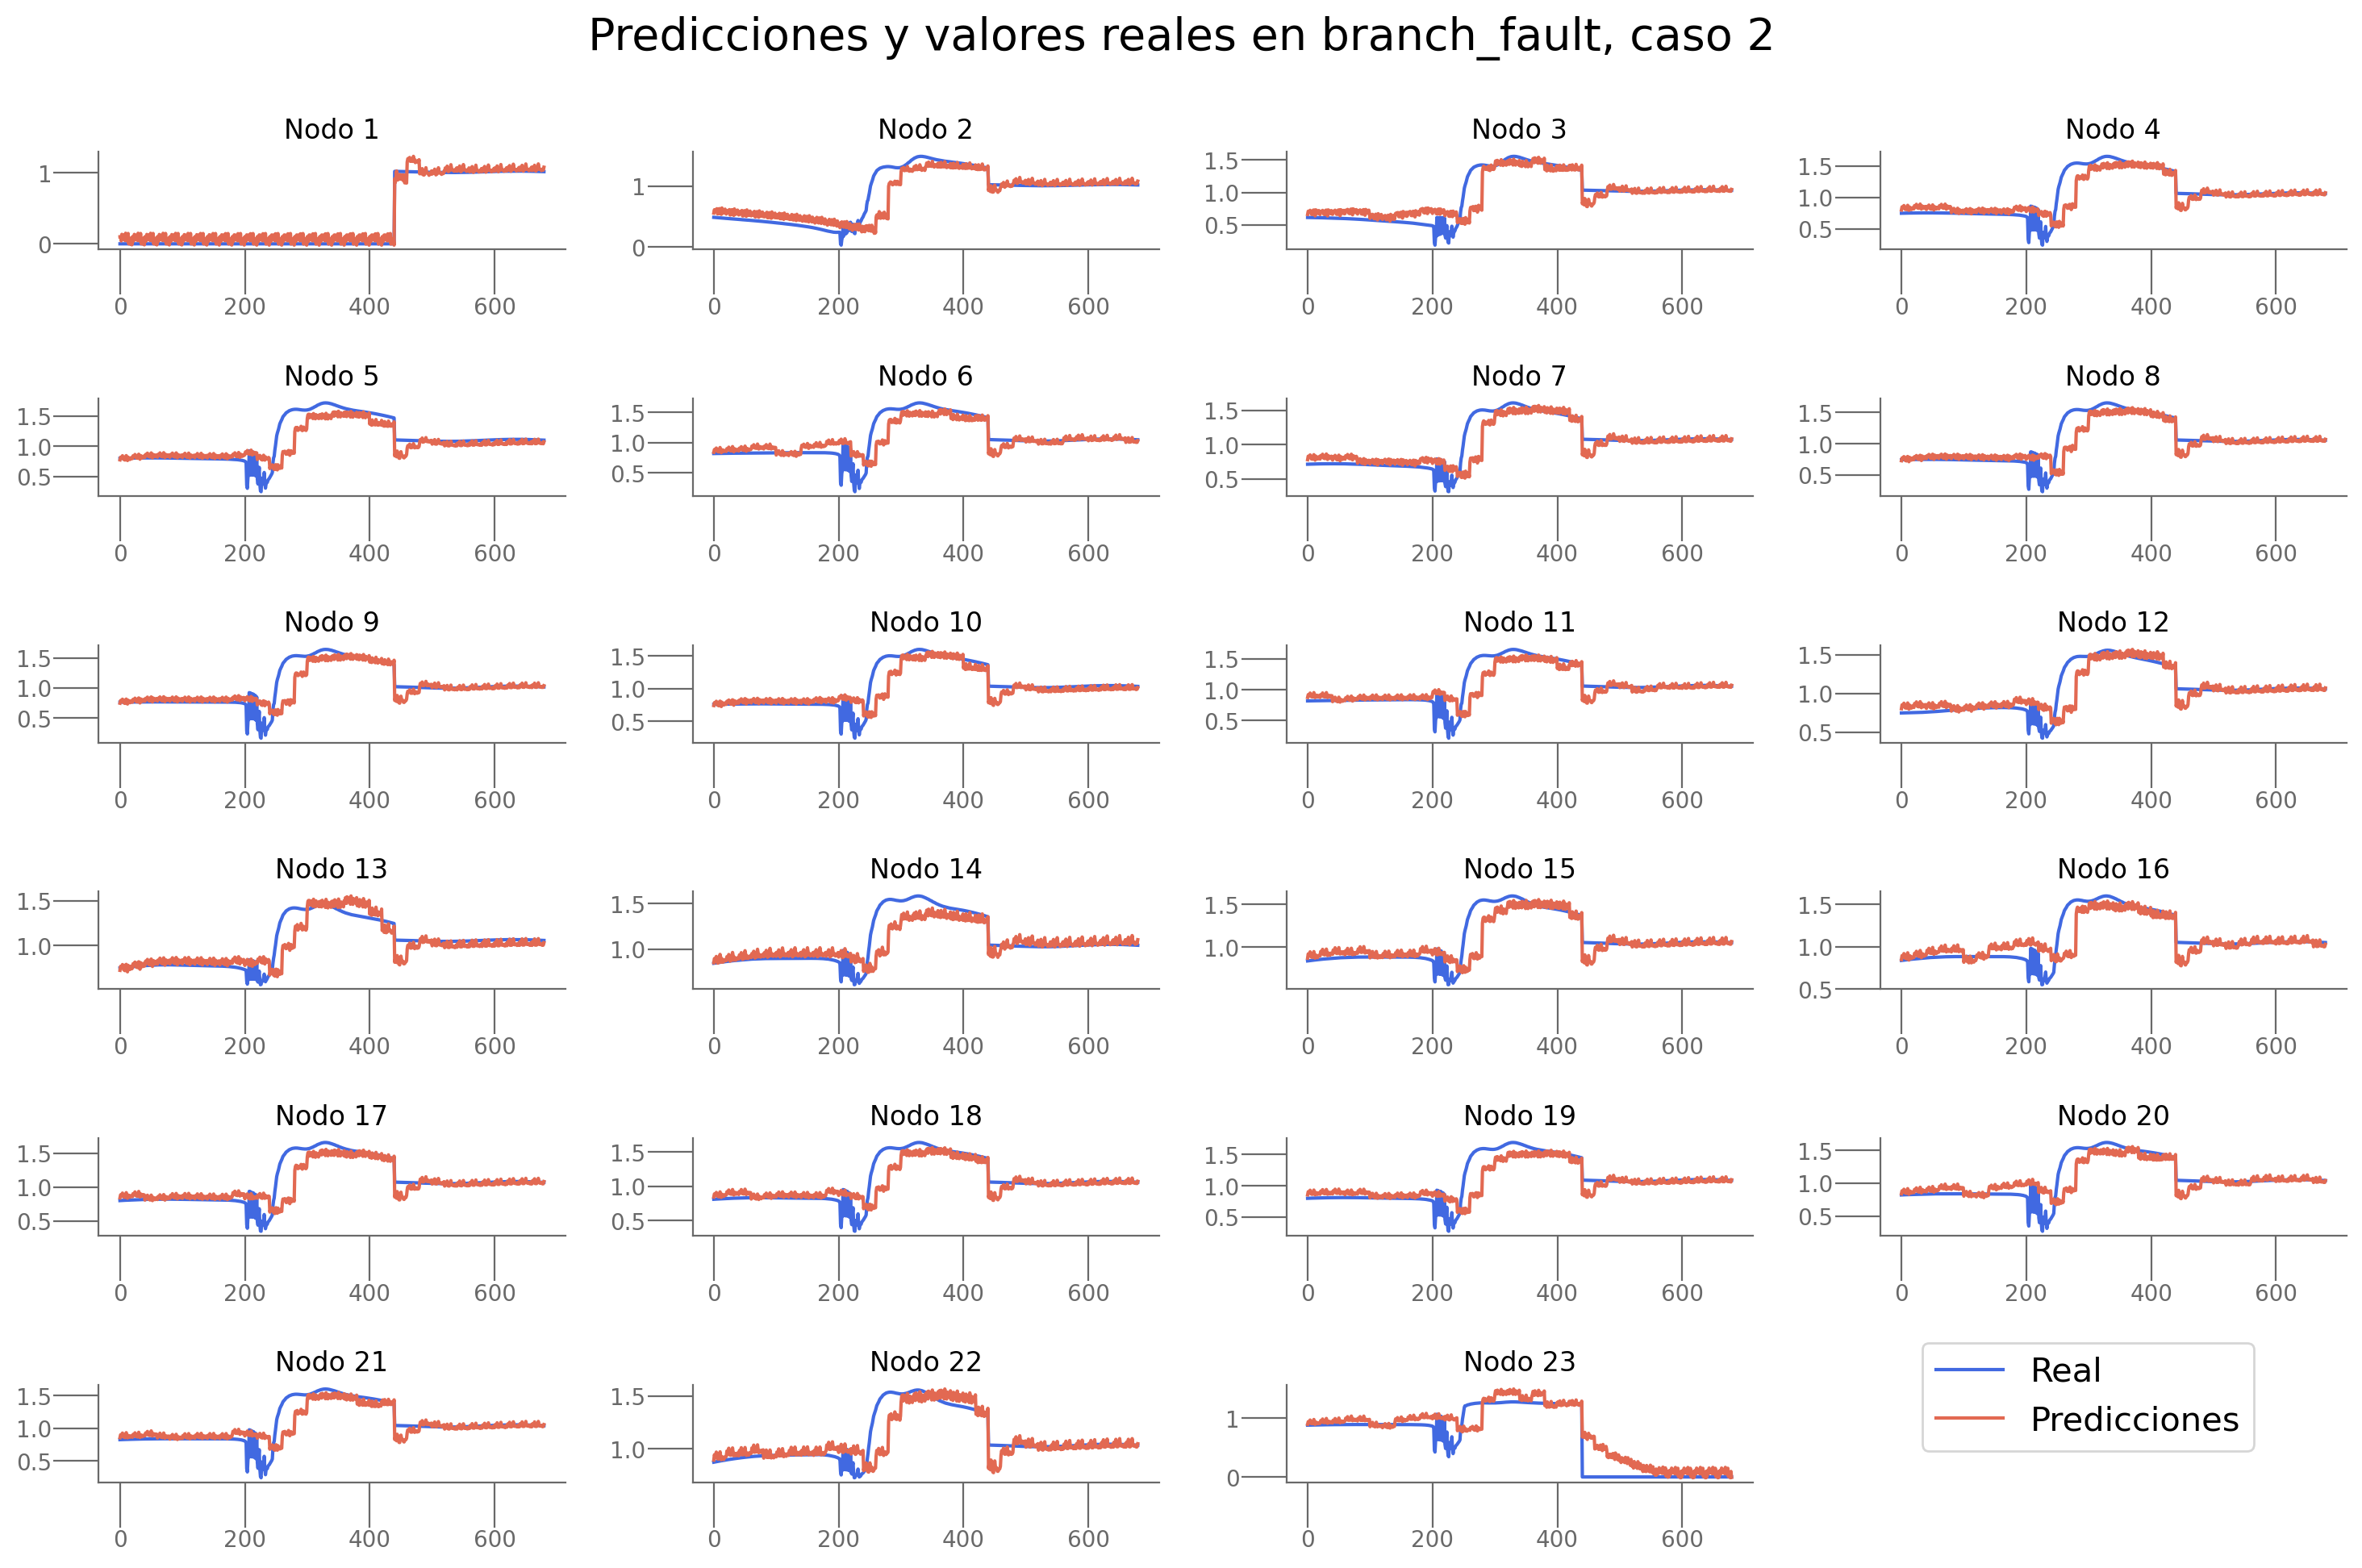

In [50]:
plot_predictions(predictions_brf_ajuste, real_brf_ajuste, n_target, 2, n_div_brf, problem_brf)

In [51]:
path_save_experiment_brf = results_save_path+f"/{problem_brf}"+ f"/ajustes/{name_model}_results.csv"
resultados_brf.to_csv(path_save_experiment_brf, index=False)

In [58]:
guardar_resultados(modelo_brf, "DryGrEncoder", problem_brf, resultados_final_brf, results_save_path, path_save_experiment_brf, params_brf)


==================== GUARDANDO RESULTADOS ===================

         Modelo       Params  \
0          LSTM          NaN   
1  DryGrEncoder  (add, 1, 2)   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.019392  0.702621   
1  ./results/branch_fault/ajustes/DryGrEncoder_re...  0.014330  0.506890   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.00679742 0.00685346 0.01119131 0.02153048 0... -4.979866   0.237984   
1  [0.012768067419528961, 0.014942342415452003, 0...  0.537312   0.014044   

   Loss_final  
0    0.017030  
1    0.014403  

==================== RESULTADOS GUARDADOS ===================



### Branch trip

In [18]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [19]:
n_div_brt = loader.div

In [20]:
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
embedding_dim =5

dataloader_brt = trainer.train_test_val_split(dataset_brt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])


==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505


#### Sencilla 


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1089 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5601 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8616 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0742 | Eval Loss: 0.0858 | Eval R2: -1.1448 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0872 | Eval Loss: 0.0867 | Eval R2: -1.1407 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0678 | Eval R2: -0.5723 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0695 | Eval Loss: 0.0509 | Eval R2: -0.1620 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0527 | Eval Loss: 0.0490 

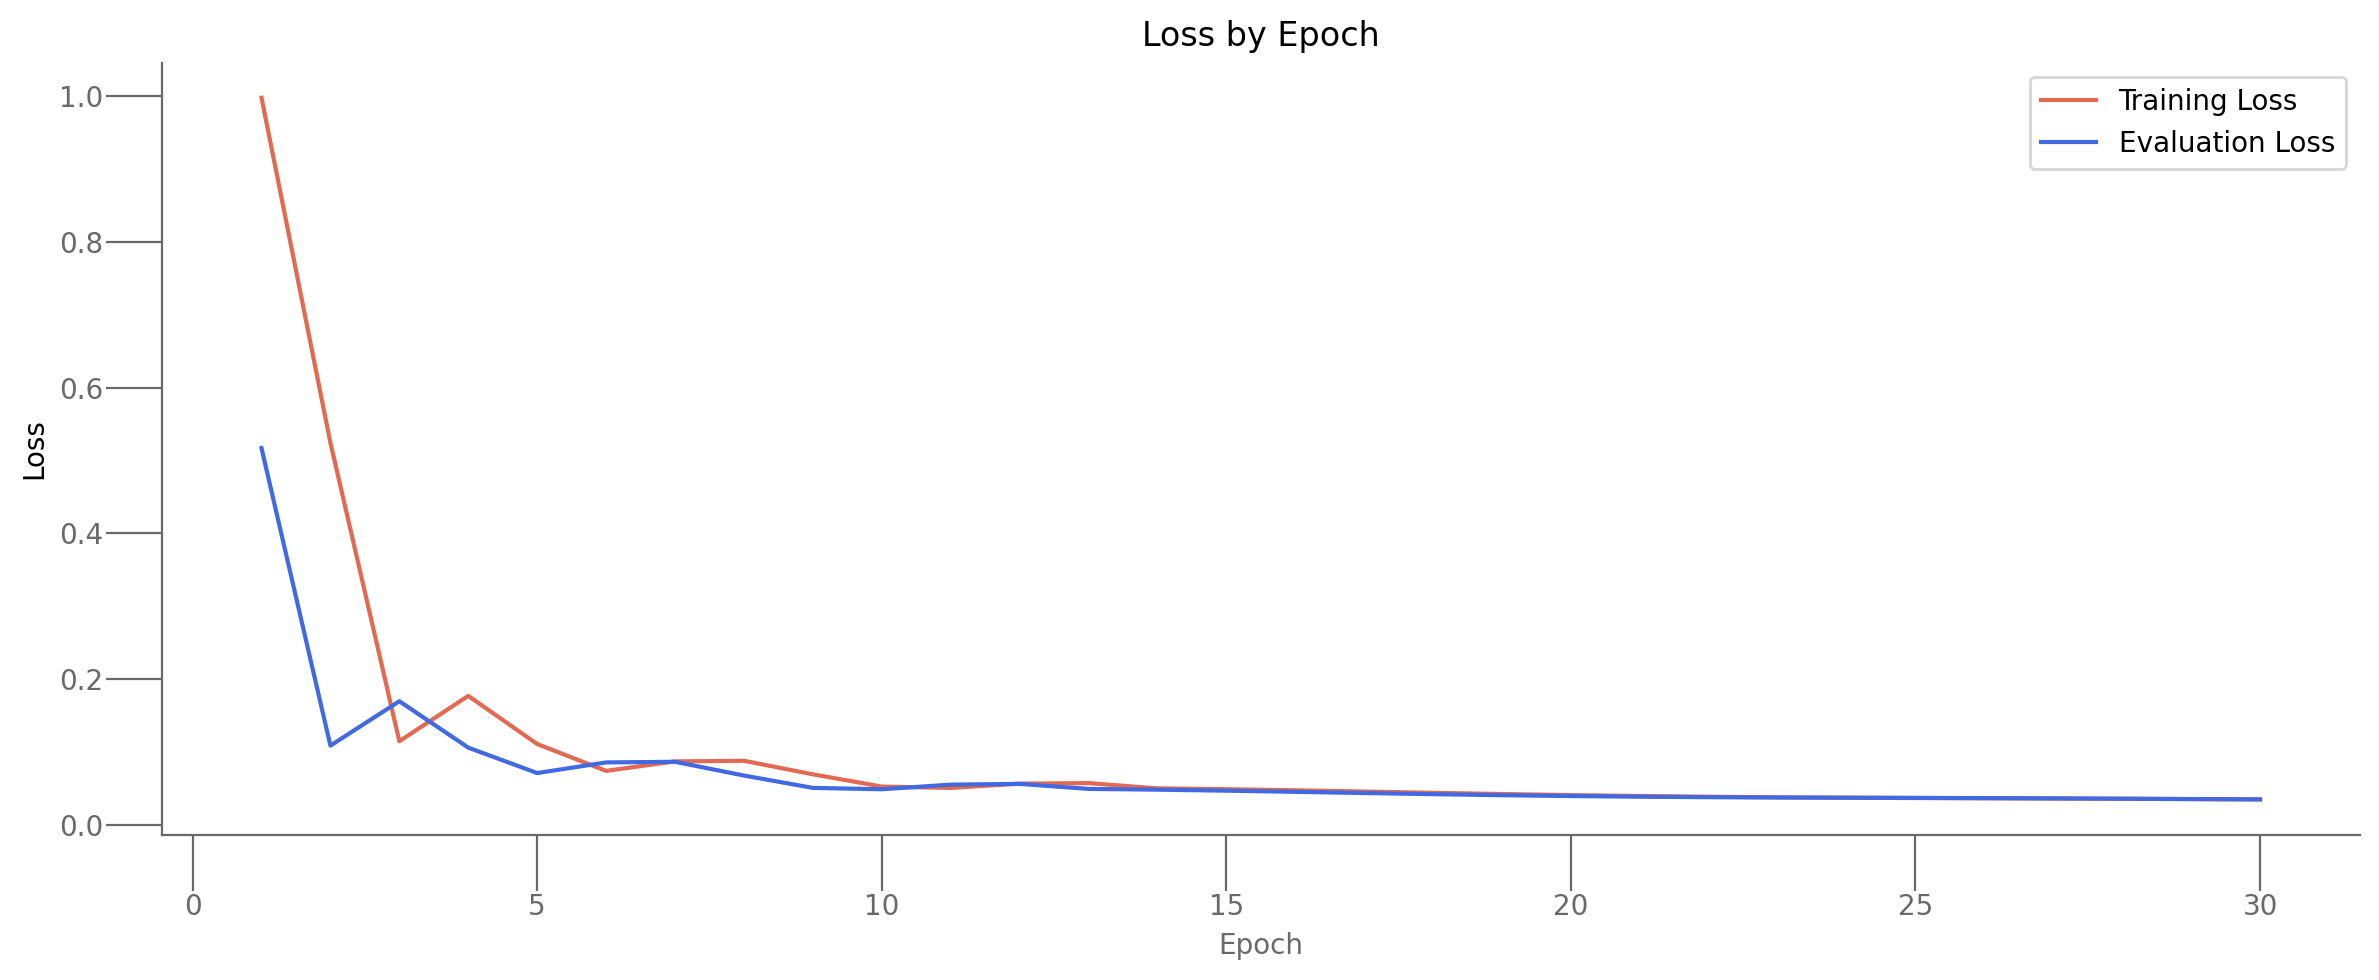


==================== TEST INFO ===================

Test_loss:0.0375, Test_r2:0.1548


In [68]:


model_brt = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")

num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_brt, dataloader_brt, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes_brt, predictions_brt, real_brt = test(model_brt, dataloader_brt, h)


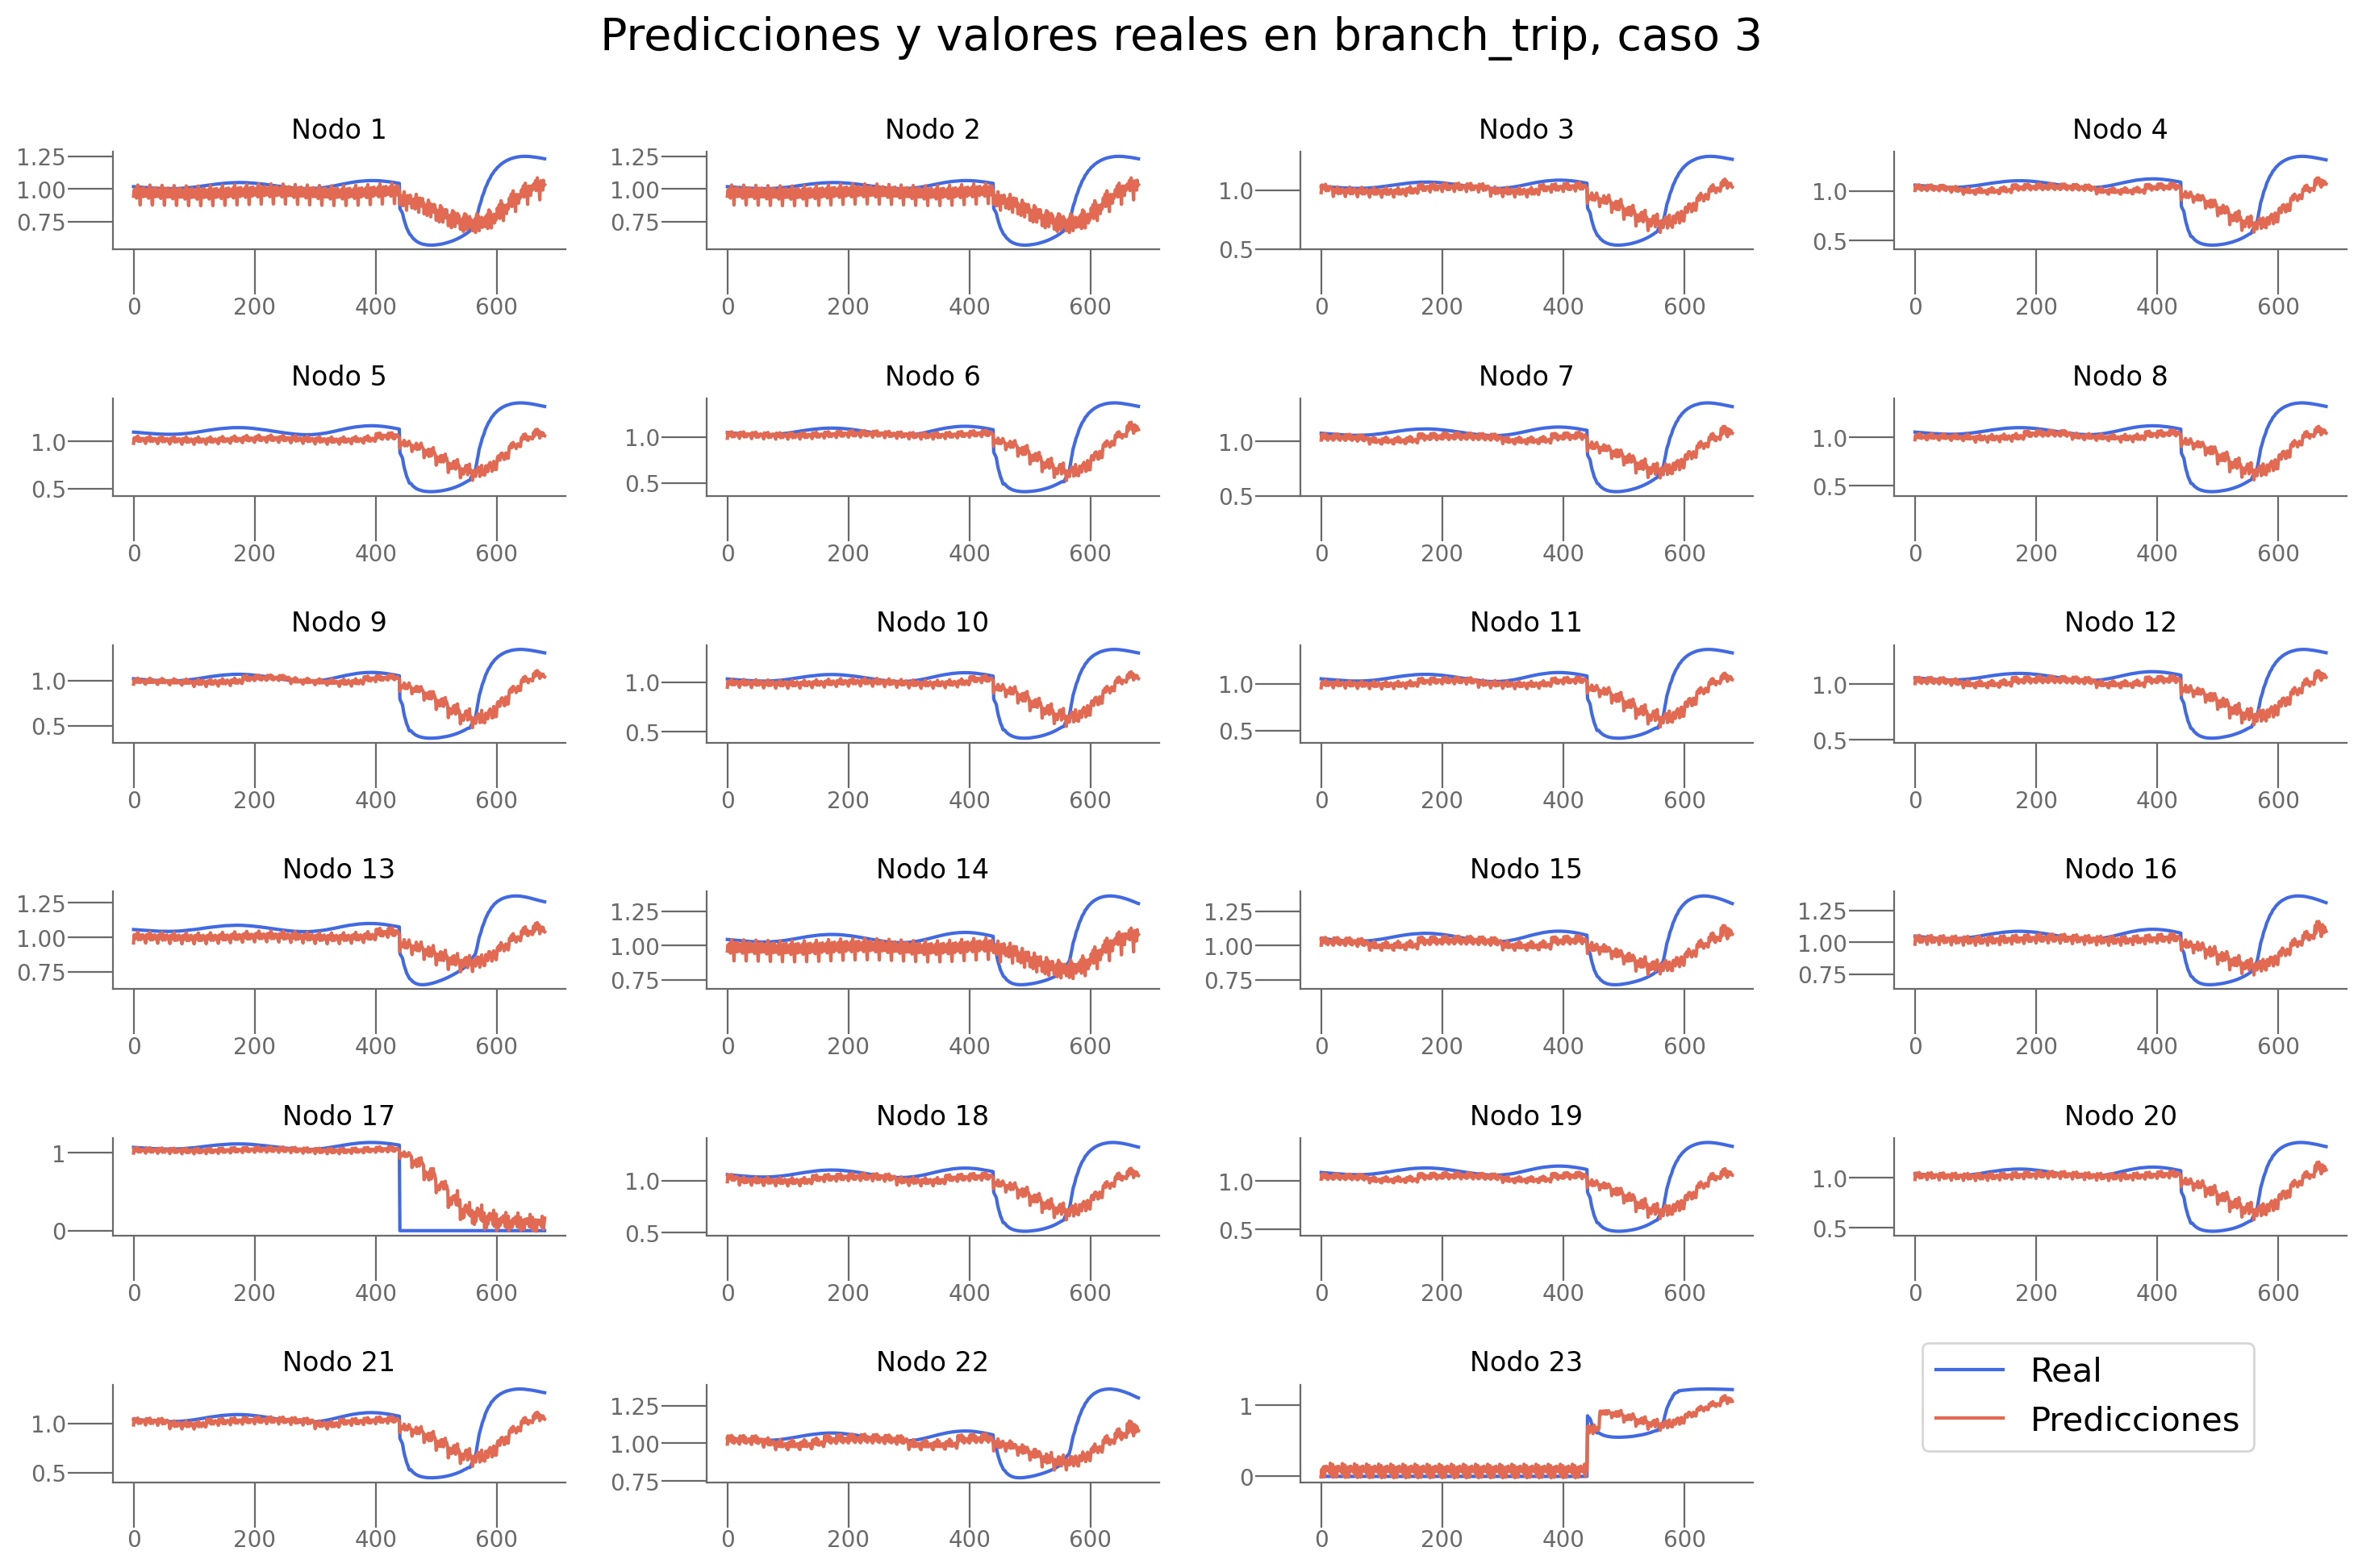

In [69]:
plot_predictions(predictions_brt, real_brt, n_target, 3, n_div_brt, problem_brt)

#### Ajuste de parámetros 

In [23]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

modelo_brt,params_brt, resultados_final_brt, resultados_brt, h = entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader_brt, num_early_stop, num_epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]


==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0043 | Eval Loss: 0.5253 | Eval R2: -442.8531 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5165 | Eval Loss: 0.0836 | Eval R2: -55.2140 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.0789 | Eval Loss: 0.1455 | Eval R2: -81.9884 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1443 | Eval Loss: 0.0996 | Eval R2: -50.0141 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0985 | Eval Loss: 0.0593 | Eval R2: -28.5015 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0562 | Eval Loss: 0.0659 | Eval R2: -42.7682 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0612 | Eval Loss: 0.0766 | Eval R2: -55.6577 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0711 | Eval Loss: 0.0684 | Eval R2: -49.2606 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0630 | Eval Loss: 0.0662 | Eval R2: -47.2382 | LR: 0.001000
Epoch 10/30 | Train Loss: 0.0608 | Eval Loss: 0.0629 | Eval R2: -44.1444 | LR: 0.001000
Epoch 11/30 | Train Loss: 0.0576 | Eval Loss: 0.0591 | Eval R2: -40.4094 |

 12%|█▎        | 1/8 [07:21<51:28, 441.28s/it]

Test_loss:0.0415, Test_r2:-16.6327
Parámetros:  add 1 1
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.03602133318781853, 'r2_eval_final': -15.474853741812577, 'loss_eval_final': 0.03906896098941455, 'r2_test': -16.632721709529065, 'loss_test': 0.041499528412402856, 'loss_nodes': [0.029318422079086304, 0.025621090084314346, 0.033978767693042755, 0.04766882210969925, 0.05318408086895943, 0.05383996292948723, 0.03847939148545265, 0.04983443021774292, 0.05704330652952194, 0.04722023010253906, 0.05237611010670662, 0.04036707431077957, 0.02312837541103363, 0.03460120037198067, 0.03756740316748619, 0.03602121025323868, 0.046007923781871796, 0.045304812490940094, 0.05085475370287895, 0.04702956601977348, 0.047923196107149124, 0.02896183356642723, 0.028157226741313934]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0078 | Eval Loss: 0.6661 | Eval R2: -558.1983 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6532 | Eval Loss: 0.0883 | Eval R2: -5

 25%|██▌       | 2/8 [17:45<54:54, 549.01s/it]

Test_loss:0.0480, Test_r2:-19.6482
Parámetros:  add 1 2
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.04083778336644173, 'r2_eval_final': -18.32444308769436, 'loss_eval_final': 0.043516777989719355, 'r2_test': -19.648215770841613, 'loss_test': 0.0480432974013251, 'loss_nodes': [0.03304613009095192, 0.029810212552547455, 0.038681600242853165, 0.05487861484289169, 0.06324039399623871, 0.06209415942430496, 0.0459851510822773, 0.05705513432621956, 0.06385084241628647, 0.05428950488567352, 0.060270894318819046, 0.04581879451870918, 0.028699874877929688, 0.039873890578746796, 0.043460000306367874, 0.042869932949543, 0.053564902395009995, 0.052608370780944824, 0.059743400663137436, 0.054060645401477814, 0.054888300597667694, 0.03407243639230728, 0.03213275223970413]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0462 | Eval Loss: 0.7143 | Eval R2: -599.0849 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7062 | Eval Loss: 0.1394 | Eval R2: -98

 38%|███▊      | 3/8 [28:16<48:51, 586.20s/it]

Test_loss:0.0129, Test_r2:-5.7763
Parámetros:  add 2 1
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.010423426516354084, 'r2_eval_final': -5.519814458340733, 'loss_eval_final': 0.011722813405475452, 'r2_test': -5.776269923309604, 'loss_test': 0.012905595631633729, 'loss_nodes': [0.013736667111515999, 0.011711248196661472, 0.009290861897170544, 0.01359925139695406, 0.014253590255975723, 0.01641157828271389, 0.01162872277200222, 0.012978325597941875, 0.016233813017606735, 0.010738556273281574, 0.015149926766753197, 0.010796034708619118, 0.008439073339104652, 0.018560675904154778, 0.01159826572984457, 0.010363913141191006, 0.012999774888157845, 0.012749837711453438, 0.016553465276956558, 0.014327780343592167, 0.014745245687663555, 0.008444119244813919, 0.011517968960106373]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0358 | Eval Loss: 0.7801 | Eval R2: -662.7780 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7806 | Eval Loss: 0.1151 | 

 50%|█████     | 4/8 [39:48<41:52, 628.18s/it]

Test_loss:0.0484, Test_r2:-20.3794
Parámetros:  add 2 2
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.0405568964779377, 'r2_eval_final': -19.045167268027622, 'loss_eval_final': 0.04351941084617055, 'r2_test': -20.379436845790288, 'loss_test': 0.048381391544780224, 'loss_nodes': [0.033594753593206406, 0.030667541548609734, 0.038982272148132324, 0.054701969027519226, 0.06389103084802628, 0.0623665414750576, 0.04641569405794144, 0.05670404061675072, 0.06287305057048798, 0.05416271463036537, 0.06033805012702942, 0.04531486704945564, 0.02971489727497101, 0.04101942107081413, 0.0438716858625412, 0.0440252348780632, 0.054073359817266464, 0.0530618280172348, 0.060020897537469864, 0.05448658764362335, 0.055103402584791183, 0.03471112996339798, 0.03267114982008934]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0145 | Eval Loss: 0.4683 | Eval R2: -393.3468 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.4649 | Eval Loss: 0.1965 | Eval R2: -136.49

 62%|██████▎   | 5/8 [49:18<30:21, 607.05s/it]

Test_loss:0.0379, Test_r2:-16.4956
Parámetros:  mean 1 1
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.03030419535934925, 'r2_eval_final': -15.317342941342647, 'loss_eval_final': 0.03389544132115392, 'r2_test': -16.495582245913933, 'loss_test': 0.03786844592587561, 'loss_nodes': [0.029239626601338387, 0.026166705414652824, 0.028119001537561417, 0.0428905226290226, 0.050767675042152405, 0.048571083694696426, 0.036399319767951965, 0.04395745322108269, 0.04773815721273422, 0.04092038422822952, 0.04531743377447128, 0.034544382244348526, 0.022654004395008087, 0.03793710842728615, 0.035243723541498184, 0.03285069018602371, 0.04194582626223564, 0.04044805467128754, 0.048378266394138336, 0.04256383702158928, 0.04170900210738182, 0.027748556807637215, 0.024863533675670624]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0070 | Eval Loss: 0.7344 | Eval R2: -618.2357 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7208 | Eval Loss: 0.1260 | Eval R

 75%|███████▌  | 6/8 [59:06<20:01, 600.74s/it]

Test_loss:0.0483, Test_r2:-19.0828
Parámetros:  mean 1 2
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.04210842400789261, 'r2_eval_final': -17.781676521878914, 'loss_eval_final': 0.04473290549997496, 'r2_test': -19.08277403089965, 'loss_test': 0.04826820944481999, 'loss_nodes': [0.03420006483793259, 0.03062024526298046, 0.03959587216377258, 0.055028825998306274, 0.0619644857943058, 0.06312569230794907, 0.04501552879810333, 0.057573769241571426, 0.06594834476709366, 0.0547872856259346, 0.061055853962898254, 0.046783965080976486, 0.027609240263700485, 0.039633311331272125, 0.04313815012574196, 0.042450543493032455, 0.05325499549508095, 0.05257164686918259, 0.05884107947349548, 0.05480676889419556, 0.05578360706567764, 0.03348855674266815, 0.03289089351892471]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0424 | Eval Loss: 0.5933 | Eval R2: -499.0458 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5865 | Eval Loss: 0.1789 | Eval R2: -124

 88%|████████▊ | 7/8 [1:12:53<11:14, 674.66s/it]

Test_loss:0.0286, Test_r2:-12.3491
Parámetros:  mean 2 1
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.023758741095662117, 'r2_eval_final': -12.311278992582258, 'loss_eval_final': 0.026296675000476704, 'r2_test': -12.349071772553895, 'loss_test': 0.028624208787188746, 'loss_nodes': [0.025929076597094536, 0.023319484665989876, 0.02175319567322731, 0.03243858739733696, 0.03801380842924118, 0.034494586288928986, 0.027200190350413322, 0.03198130056262016, 0.035131849348545074, 0.02843089960515499, 0.03275858238339424, 0.026389922946691513, 0.018832124769687653, 0.03223997354507446, 0.027106722816824913, 0.025664106011390686, 0.03135954216122627, 0.02927696704864502, 0.03723994642496109, 0.03042338229715824, 0.029365966096520424, 0.02039913274347782, 0.01860736310482025]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0757 | Eval Loss: 0.8910 | Eval R2: -750.9626 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.8802 | Eval Loss: 0.1789 | Eval

100%|██████████| 8/8 [1:28:15<00:00, 661.89s/it]

Test_loss:0.0483, Test_r2:-19.7224
Parámetros:  mean 2 2
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.04094712808728218, 'r2_eval_final': -18.40670950671962, 'loss_eval_final': 0.044130526079029286, 'r2_test': -19.722358575507204, 'loss_test': 0.04834803679155757, 'loss_nodes': [0.03351955488324165, 0.030349576845765114, 0.03904501348733902, 0.05510444566607475, 0.0630984827876091, 0.06273604929447174, 0.04599399492144585, 0.05736227333545685, 0.06463346630334854, 0.05464092642068863, 0.06077172979712486, 0.046289827674627304, 0.0286558847874403, 0.04008626192808151, 0.043466851115226746, 0.0429290272295475, 0.05374136194586754, 0.05290922150015831, 0.05975513532757759, 0.054637081921100616, 0.05546872317790985, 0.03409856557846069, 0.032711468636989594]}


In [24]:
losses_tst, r2score_tst, loss_nodes_brt, predictions_brt_ajuste, real_brt_ajuste = test(modelo_brt, dataloader_brt, modelo_brt.h)



==================== TEST INFO ===================

Test_loss:0.0129, Test_r2:-5.7763


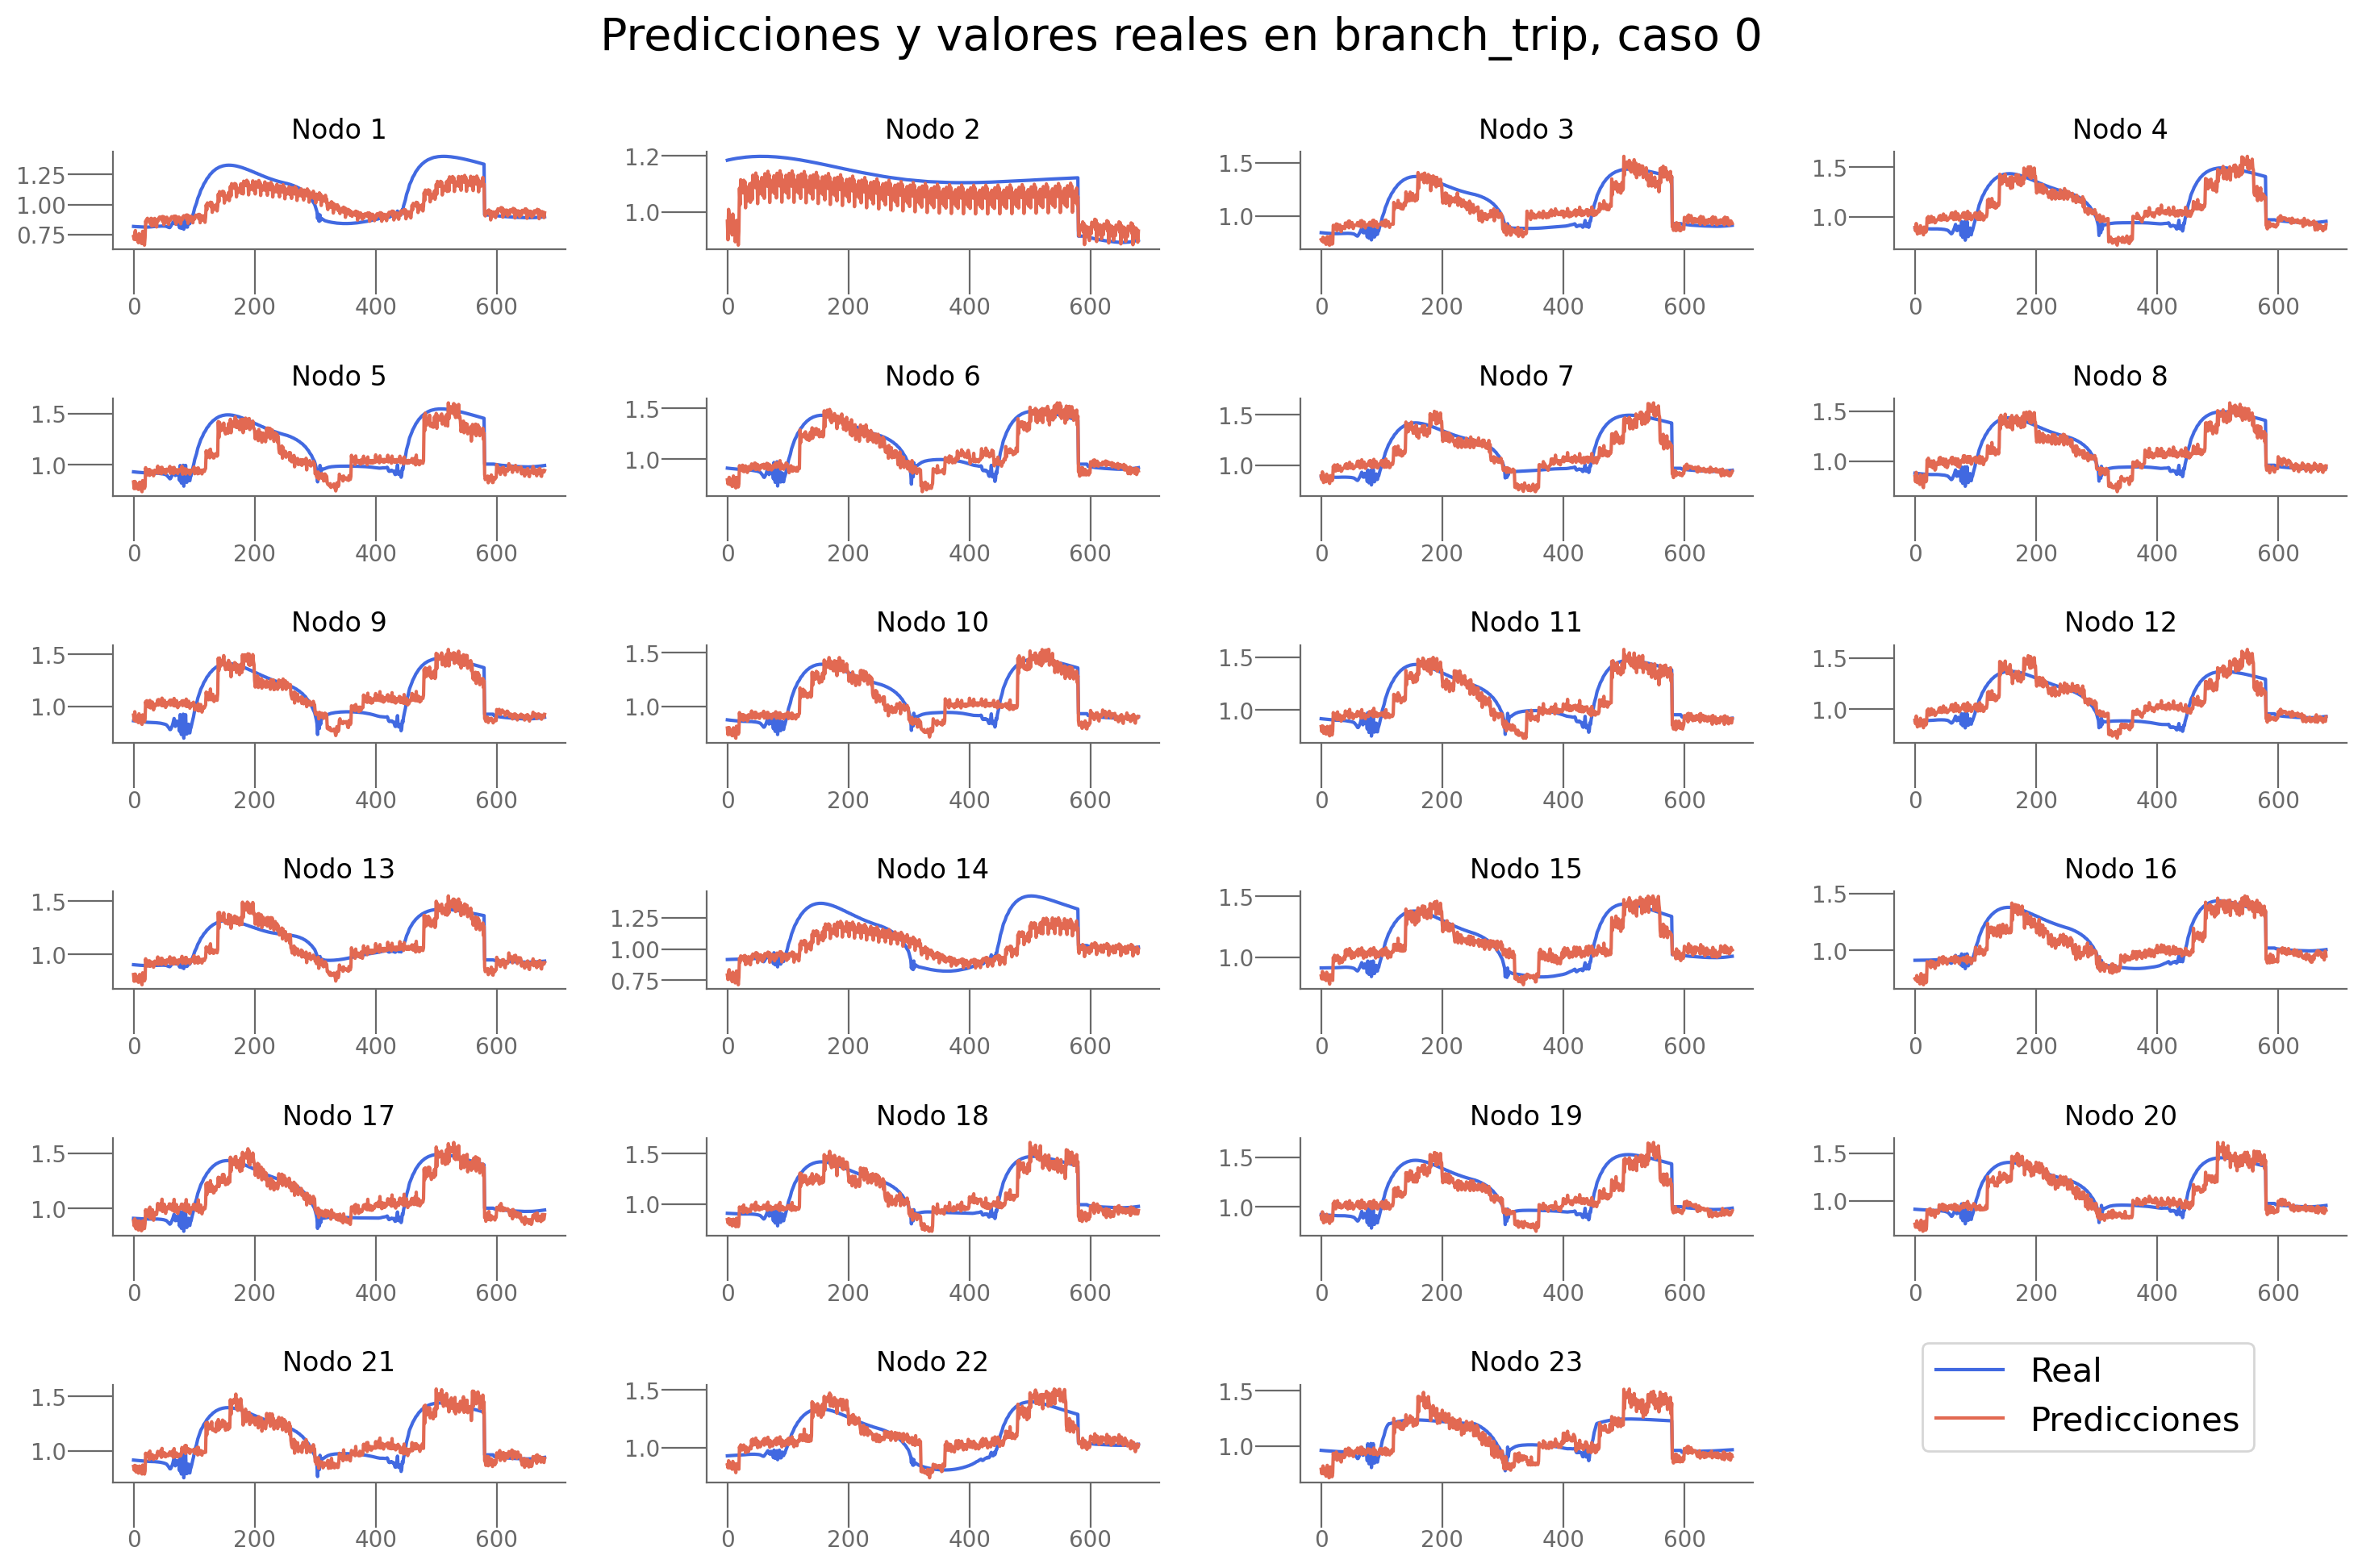

In [26]:
plot_predictions(predictions_brt_ajuste, real_brt_ajuste, n_target, 0, n_div_brt, problem_brt)

In [27]:
path_save_experiment_brt = results_save_path+f"/{problem_brt}"+ f"/ajustes/{name_model}_results.csv"
resultados_brt.to_csv(path_save_experiment_brt, index=False)

In [28]:
guardar_resultados(modelo_brt, "DryGrEncoder", problem_brt, resultados_final_brt, results_save_path, path_save_experiment_brt, params_brt)


==================== GUARDANDO RESULTADOS ===================

         Modelo       Params  \
0          LSTM          NaN   
1  DryGrEncoder  (add, 2, 1)   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.002611  0.583308   
1  ./results/branch_trip/ajustes/DryGrEncoder_res...  0.012906 -5.776270   

                                          Loss_nodes    R2_eval  Loss_eval  \
0  [0.00258036 0.00122066 0.00166373 0.00299849 0... -31.054981   0.105248   
1  [0.013736667111515999, 0.011711248196661472, 0...  -5.519814   0.011723   

   Loss_final  
0    0.002907  
1    0.010423  

==================== RESULTADOS GUARDADOS ===================

